# Preparation
## Imports

In [13]:
%config IPCompleter.greedy=True

In [225]:
import os
import warnings
import logging
import pickle
import sys
import time
import collections
from itertools import groupby

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn
import seaborn as sns

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer

from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report   
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold



from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, SMOTENC
from imblearn.over_sampling import ADASYN

import config
try:
    del sys.modules['feutils']
except:
    pass
from feutils import DataHandler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

## Data loading

In [172]:
#matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0409_14-52-24Features-157015.xlsx')
#matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0410_17-50-48Features-agent-157015.xlsx')
#matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0411_14-05-24Features-nophase.xlsx')
#matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') 
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0411_15-30-16Features-agent-nophase.xlsx') 

def prepare_df(df):
    # Replace 3 classes (low, medium, high) by 5 classes (ie, score rounded)
    #df['Presence Class'] = df['Presence Score'].round()
    #df['Co-presence Class'] = df['Co-presence Score'].round()
    #df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def prepare_agent_df(df):
    df = prepare_df(df)
    df = df.drop(['PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score', 'Duration', 'Expert'], axis=1)
    agent_cols_rename = {}
    for col in df.columns:
        if col not in ['Candidate', 'Environment']:
            agent_cols_rename[col] = col + '_agent'
    df = df.rename(index=str, columns=agent_cols_rename)
    return df
    
def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases)
subject_p_df = prepare_df(subject_p_df)
print("   Subject(phases): %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases)
agent_p_df = prepare_agent_df(agent_p_df)
print("   Agent(phases): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_p_df = pd.merge(agent_p_df, subject_p_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(phases-merged): %d samples" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase)
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase)
agent_np_df = prepare_agent_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_np_df = pd.merge(agent_np_df, subject_np_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(no phase-merged): %d samples" % len(agent_np_df))

subject_p_df.index = [subject_p_df['Candidate'], subject_p_df['Environment']]
agent_p_df.index = [agent_p_df['Candidate'], agent_p_df['Environment']]
subject_np_df.index = [subject_np_df['Candidate'], subject_np_df['Environment']]
agent_np_df.index = [agent_np_df['Candidate'], agent_np_df['Environment']]

intersect = set(subject_p_df.index) & set(agent_p_df.index) & set(subject_np_df.index) & set(agent_np_df.index)
print("  samples intersection %d" % len(intersect))

rejected_from_subject_p_df = set(subject_p_df.index) - intersect
rejected_from_subject_np_df = set(subject_np_df.index) - intersect
rejected_from_agent_p_df = set(agent_p_df.index) - intersect
rejected_from_agent_np_df = set(agent_np_df.index) - intersect

# restrict each dataset to the common samples
subject_p_df = subject_p_df.loc[list(intersect)].reset_index(drop=True)
subject_np_df = subject_np_df.loc[list(intersect)].reset_index(drop=True)
agent_p_df = agent_p_df.loc[list(intersect)].reset_index(drop=True)
agent_np_df = agent_np_df.loc[list(intersect)].reset_index(drop=True)

all_p_df = pd.merge(subject_p_df, agent_p_df.drop(['Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score'], axis=1), on=['Candidate', 'Environment'], 
                    how='inner', suffixes=(False, False))
#all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(phases): %d samples " % len(all_p_df))

all_np_df = pd.merge(subject_np_df, agent_np_df.drop(['Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score'], axis=1), on=['Candidate', 'Environment'], 
                     how='inner', suffixes=(False, False))
#all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(no phase): %d samples " % len(all_np_df))

print("")
print("Additional info:")
print("   samples rejected from subject / phases   %d" % len(rejected_from_subject_p_df))
for item in sorted(list(rejected_from_subject_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from subject / no phase %d" % len(rejected_from_subject_np_df))
for item in sorted(list(rejected_from_subject_np_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / phases     %d" % len(rejected_from_agent_p_df))
for item in sorted(list(rejected_from_agent_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / no phase   %d" % len(rejected_from_agent_np_df))
for item in sorted(list(rejected_from_agent_np_df)) : print("     %s / %s" % (item[0], item[1]))


Loading data - phases split ...
   Subject(phases): 99 samples
   Agent(phases): 103 samples
   Agent(phases-merged): 98 samples
   Subject(no phase): 99 samples
   Agent(no phase): 98 samples
   Agent(no phase-merged): 97 samples
  samples intersection 96
   Merge(phases): 96 samples 
   Merge(no phase): 96 samples 

Additional info:
   samples rejected from subject / phases   3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from subject / no phase 3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from agent / phases     2
     E11E / Cave
     E3C / Cave
   samples rejected from agent / no phase   1
     N22D / Casque


## Train/Test split

In [175]:
test_size = 0.10

sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_STATE)
#sss = StratifiedKFold(n_splits=2, shuffle=False, random_state=RANDOM_STATE)

print('Support:')
print('presence: %s' % str(np.unique(all_p_df['PresenceClass'], return_counts=True)[1]))
for split in sss.split(np.zeros(len(all_p_df)), all_p_df['PresenceClass']):
    train_pres_idx, test_pres_idx = split[0], split[1]
print('   Train %s' % str(np.unique(all_p_df.loc[train_pres_idx]['PresenceClass'], return_counts=True)[1]))
print('   Test %s' % str(np.unique(all_p_df.loc[test_pres_idx]['PresenceClass'], return_counts=True)[1]))

print('co-presence %s' % str(np.unique(all_p_df['CopresenceClass'], return_counts=True)[1]))
for split in sss.split(np.zeros(len(all_p_df)), all_p_df['CopresenceClass']):
    train_copres_idx, test_copres_idx = split[0], split[1]
print('   Train %s' 
      % str(np.unique(all_p_df.loc[train_copres_idx]['CopresenceClass'], return_counts=True)[1]))
print('   Test %s' 
      % str(np.unique(all_p_df.loc[test_copres_idx]['CopresenceClass'], return_counts=True)[1]))

Support:
presence: [18 35 43]
   Train [16 31 39]
   Test [2 4 4]
co-presence [12 43 41]
   Train [11 38 37]
   Test [1 5 4]


## Discretization of presence and co-presence scores

96
96


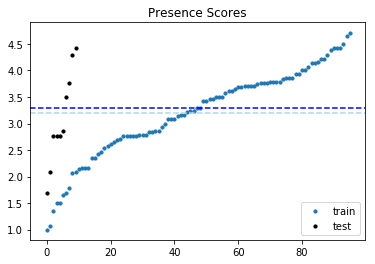

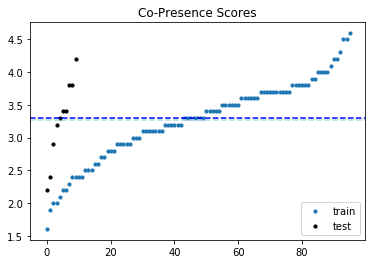

In [176]:
presence = all_p_df.sort_values(by=['Presence Score'])['Presence Score']
copresence = all_p_df.sort_values(by=['Co-presence Score'])['Co-presence Score']
orig_pres = all_p_df.sort_values(by=['Presence Score'])['PresenceClass']
orig_copres = all_p_df.sort_values(by=['Co-presence Score'])['CopresenceClass']
print(len(presence))
print(len(orig_pres))
#presence = all_p_df.loc[train_pres_idx].sort_values(by=['Presence Score'])['Presence Score']
#copresence = all_p_df.loc[train_pres_idx].sort_values(by=['Co-presence Score'])['Co-presence Score']
presence_test = all_p_df.loc[test_pres_idx].sort_values(by=['Presence Score'])['Presence Score']
copresence_test = all_p_df.loc[test_pres_idx].sort_values(by=['Co-presence Score'])['Co-presence Score']

plt.scatter(np.arange(len(presence)), presence.values, label='train', s=10)
plt.scatter(np.arange(len(presence_test)), presence_test.values, color='black', label='test', s=10)
plt.axhline(y=np.mean(presence.values), color='lightblue', ls='--')
plt.axhline(y=np.median(presence.values), color='blue', ls='--')
plt.title('Presence Scores')
plt.legend()
plt.show()

plt.scatter(np.arange(len(copresence)), copresence.values, label='train', s=10)
plt.scatter(np.arange(len(copresence_test)), copresence_test.values, color='black', label='test', s=10)
plt.axhline(y=np.mean(copresence.values), color='lightblue', ls='--')
plt.axhline(y=np.median(copresence.values), color='blue', ls='--')
plt.title('Co-Presence Scores')
plt.legend()
plt.show()

(0, {'n_bins': 2, 'strategy': 'uniform'})


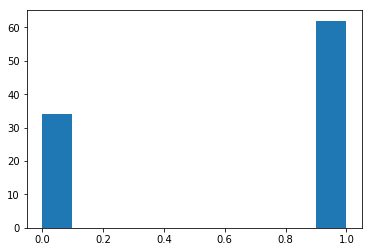

(1, {'n_bins': 2, 'strategy': 'quantile'})


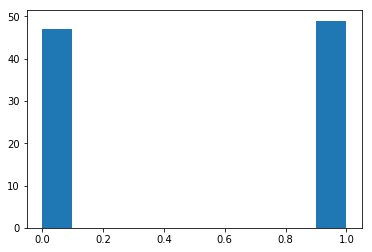

(2, {'n_bins': 2, 'strategy': 'kmeans'})


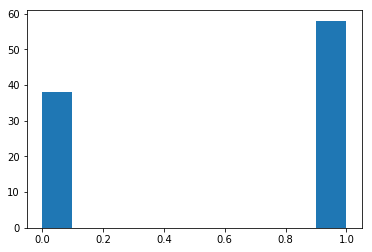

(3, {'n_bins': 3, 'strategy': 'uniform'})


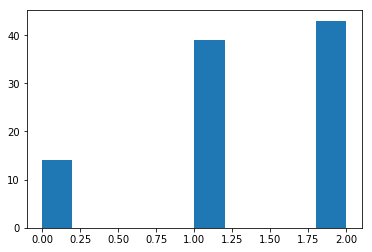

(4, {'n_bins': 3, 'strategy': 'quantile'})


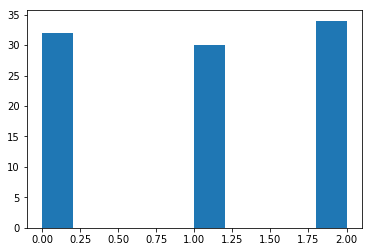

(5, {'n_bins': 3, 'strategy': 'kmeans'})


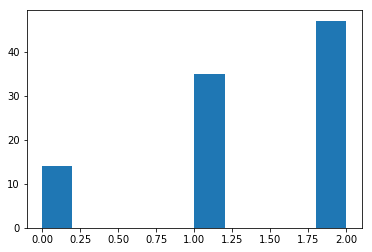

(6, {'n_bins': 4, 'strategy': 'uniform'})


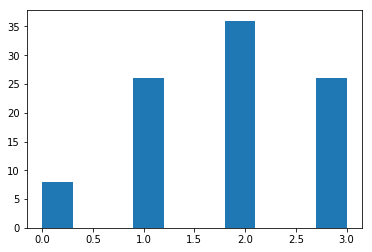

(7, {'n_bins': 4, 'strategy': 'quantile'})


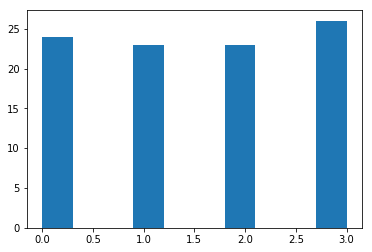

(8, {'n_bins': 4, 'strategy': 'kmeans'})


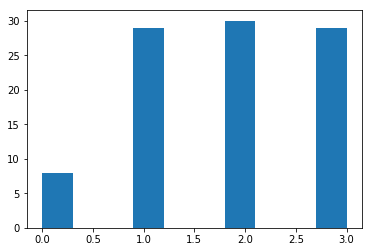

(9, {'n_bins': 5, 'strategy': 'uniform'})


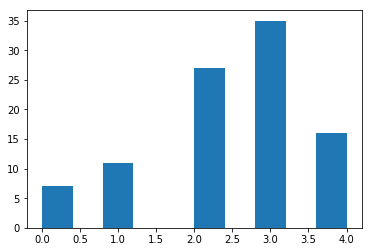

(10, {'n_bins': 5, 'strategy': 'quantile'})


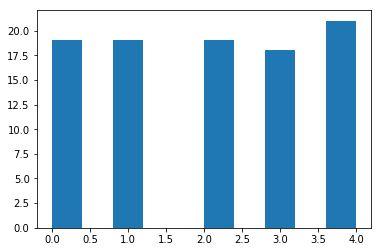

(11, {'n_bins': 5, 'strategy': 'kmeans'})


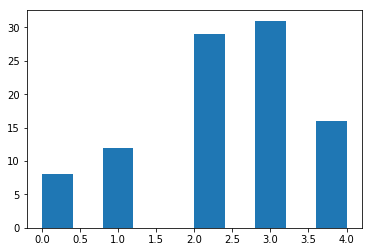

(12, {'n_bins': 6, 'strategy': 'uniform'})


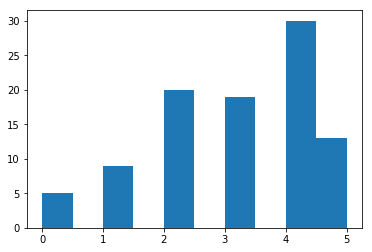

(13, {'n_bins': 6, 'strategy': 'quantile'})


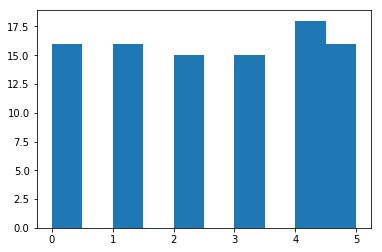

(14, {'n_bins': 6, 'strategy': 'kmeans'})


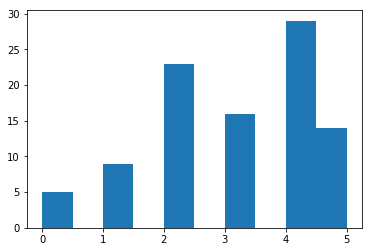

(15, {'n_bins': 7, 'strategy': 'uniform'})


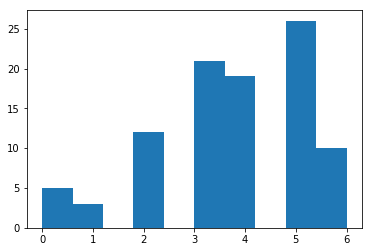

(16, {'n_bins': 7, 'strategy': 'quantile'})


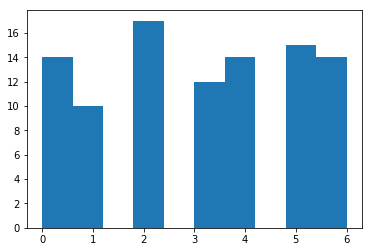

(17, {'n_bins': 7, 'strategy': 'kmeans'})


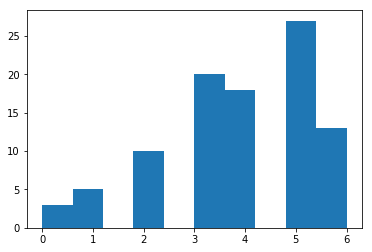

(18, {'n_bins': 8, 'strategy': 'uniform'})


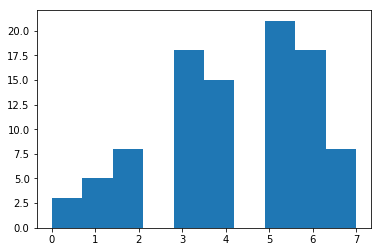

(19, {'n_bins': 8, 'strategy': 'quantile'})


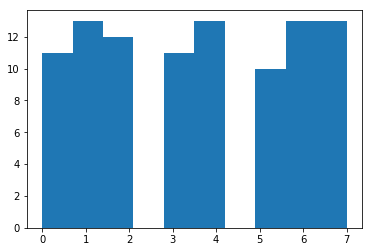

(20, {'n_bins': 8, 'strategy': 'kmeans'})


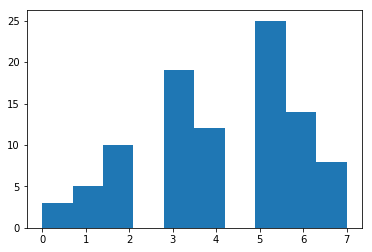

(21, {'n_bins': 9, 'strategy': 'uniform'})


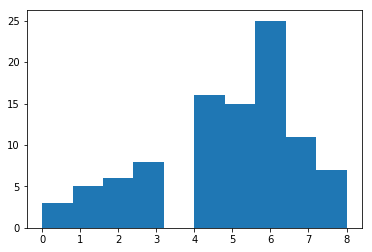

(22, {'n_bins': 9, 'strategy': 'quantile'})


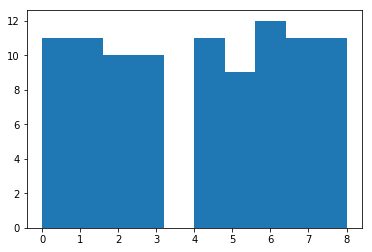

(23, {'n_bins': 9, 'strategy': 'kmeans'})


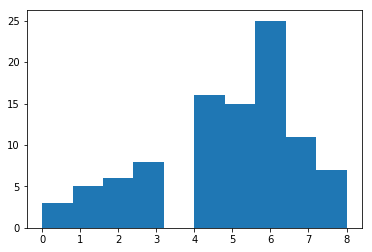

(24, {'n_bins': 10, 'strategy': 'uniform'})


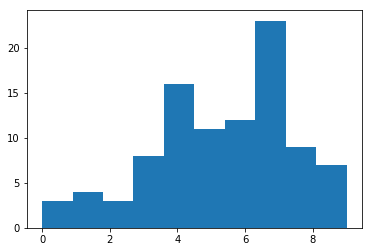

(25, {'n_bins': 10, 'strategy': 'quantile'})


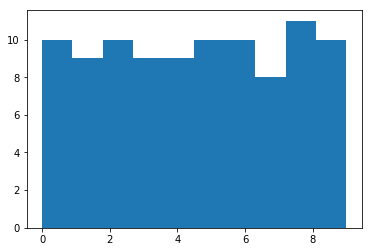

(26, {'n_bins': 10, 'strategy': 'kmeans'})


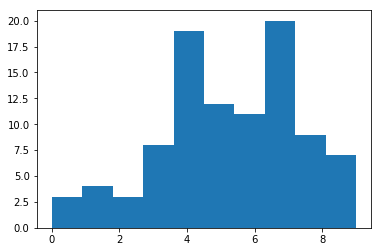

(0, {'n_bins': 2, 'strategy': 'uniform'})


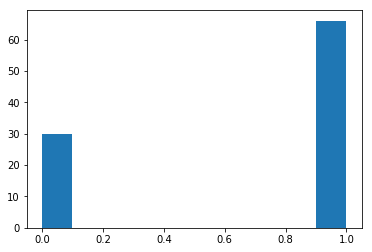

(1, {'n_bins': 2, 'strategy': 'quantile'})


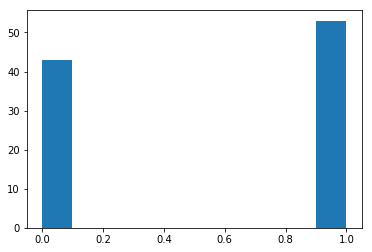

(2, {'n_bins': 2, 'strategy': 'kmeans'})


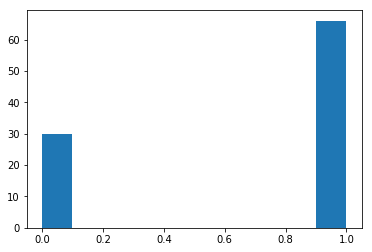

(3, {'n_bins': 3, 'strategy': 'uniform'})


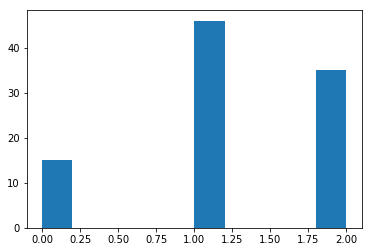

(4, {'n_bins': 3, 'strategy': 'quantile'})


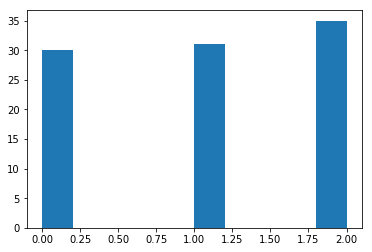

(5, {'n_bins': 3, 'strategy': 'kmeans'})


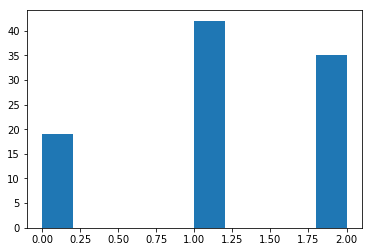

(6, {'n_bins': 4, 'strategy': 'uniform'})


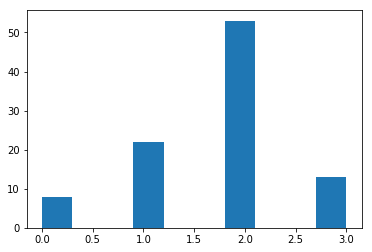

(7, {'n_bins': 4, 'strategy': 'quantile'})


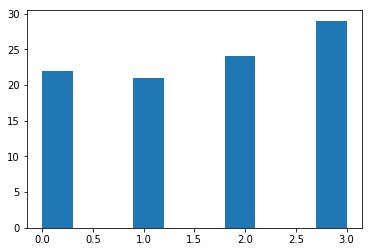

(8, {'n_bins': 4, 'strategy': 'kmeans'})


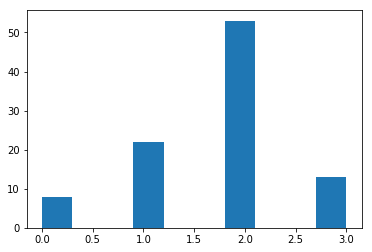

(9, {'n_bins': 5, 'strategy': 'uniform'})


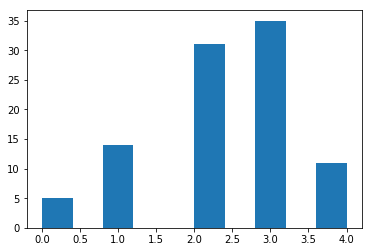

(10, {'n_bins': 5, 'strategy': 'quantile'})


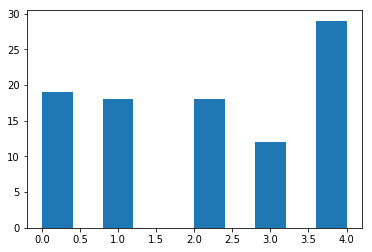

(11, {'n_bins': 5, 'strategy': 'kmeans'})


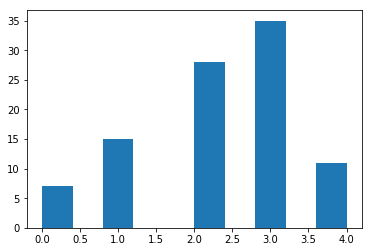

(12, {'n_bins': 6, 'strategy': 'uniform'})


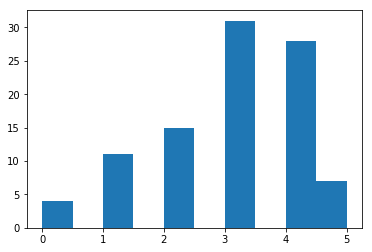

(13, {'n_bins': 6, 'strategy': 'quantile'})


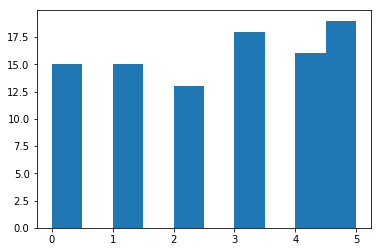

(14, {'n_bins': 6, 'strategy': 'kmeans'})


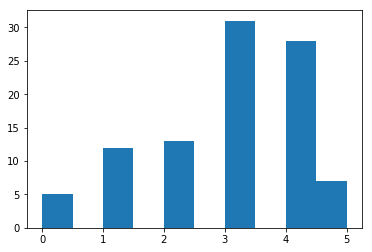

(15, {'n_bins': 7, 'strategy': 'uniform'})


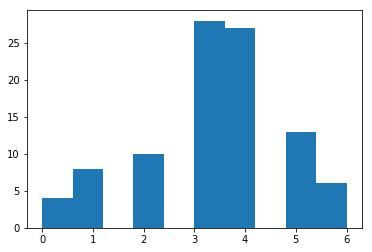

(16, {'n_bins': 7, 'strategy': 'quantile'})


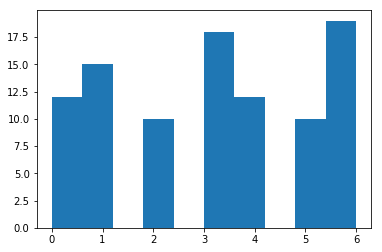

(17, {'n_bins': 7, 'strategy': 'kmeans'})


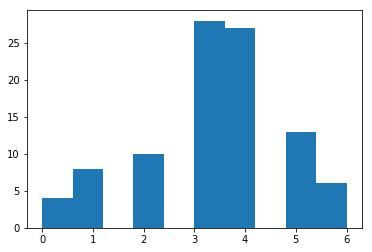

(18, {'n_bins': 8, 'strategy': 'uniform'})


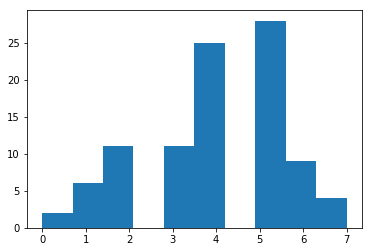

(19, {'n_bins': 8, 'strategy': 'quantile'})


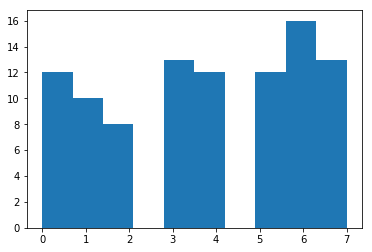

(20, {'n_bins': 8, 'strategy': 'kmeans'})


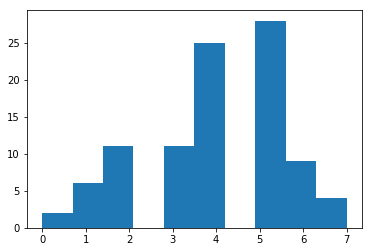

(21, {'n_bins': 9, 'strategy': 'uniform'})


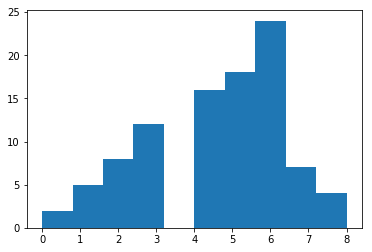

(22, {'n_bins': 9, 'strategy': 'quantile'})


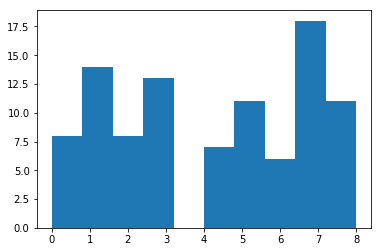

(23, {'n_bins': 9, 'strategy': 'kmeans'})


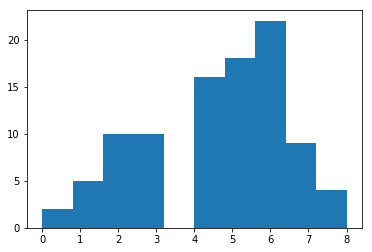

(24, {'n_bins': 10, 'strategy': 'uniform'})


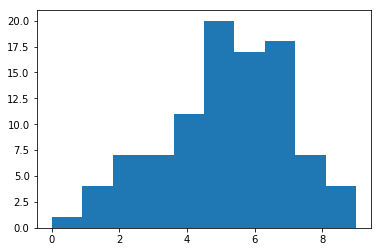

(25, {'n_bins': 10, 'strategy': 'quantile'})


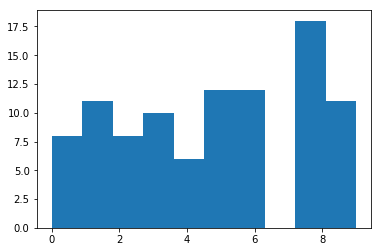

(26, {'n_bins': 10, 'strategy': 'kmeans'})


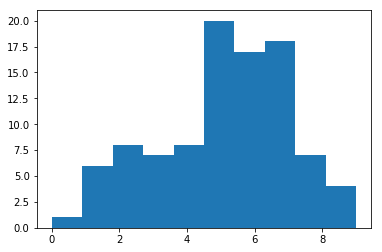

In [177]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics

#TODO MDLP discretizer ?

discretization_params = {
    'n_bins' : [2,3,4,5,6,7,8,9,10],
    'strategy' : ['uniform', 'quantile', 'kmeans']
}

def discretize(data, n_bins, strategy):
    enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    pres_arr = np.array(data).reshape(-1,1)
    pres_kmeans = enc.fit_transform(pres_arr)
    return pres_kmeans, enc

def compute_discretization_scores(data, labels):
    calinski = metrics.calinski_harabaz_score(data, labels)
    silhouette = metrics.silhouette_score(data, labels, metric='euclidean')
    db = metrics.davies_bouldin_score(data, labels)
    min_cluster = np.unique(labels, return_counts=True)[1].min()
    max_cluster = np.unique(labels, return_counts=True)[1].max()  
    return [calinski, silhouette, db, min_cluster, max_cluster]

def discretization_gridsearch(data, discretization_params, orig_discretization=None):
    data = np.array(data).reshape(-1, 1)
    discretization_params_grid = ParameterGrid(discretization_params)
    results = np.zeros(shape=(len(discretization_params_grid)+1, 5))
    for idx, param_set in enumerate(discretization_params_grid):
        print(idx, param_set)
        pres_kmeans, _ = discretize(data, n_bins=param_set['n_bins'], strategy=param_set['strategy'])

        plt.hist(pres_kmeans)
        plt.show()

        results[idx] = compute_discretization_scores(data, pres_kmeans)
    if orig_discretization is not None:
        results[-1] = compute_discretization_scores(data, orig_discretization)
    myindex = ["%s (%s)" % (p['n_bins'], p['strategy']) for p in discretization_params_grid]
    myindex.append("3 (orig)")
    cluster_results = pd.DataFrame(data=results, index=myindex, columns=['Calinski-Harabaz', 'Silhouette', 'Davies-Bouldin',
                                                                        'min cluster nb', 'max cluster nb'])
    cluster_results['C-H'] = (cluster_results['Calinski-Harabaz'] - cluster_results['Calinski-Harabaz'].mean()) / cluster_results['Calinski-Harabaz'].std()
    cluster_results['S'] = (cluster_results['Silhouette'] - cluster_results['Silhouette'].mean()) / cluster_results['Silhouette'].std()
    cluster_results['D-B'] = (cluster_results['Davies-Bouldin'] - cluster_results['Davies-Bouldin'].mean()) / cluster_results['Davies-Bouldin'].std()
    cluster_results['Weighted'] = cluster_results['D-B'] - cluster_results['C-H'] - cluster_results['S']
    return cluster_results

def highlight_max(x):
    return ['color: red' if v == x.max() else 'color: green' if v == x.min() else '' for v in x]

pres_clusters_results = discretization_gridsearch(presence, discretization_params, orig_pres)
copres_clusters_results = discretization_gridsearch(copresence, discretization_params, orig_copres)

In [178]:
#pres_clusters_results.style.apply(highlight_max).to_excel(os.path.join(config.OUT_PATH, 'presence_discretization.xlsx'))
#copres_clusters_results.style.apply(highlight_max).to_excel(os.path.join(config.OUT_PATH, 'copresence_discretization.xlsx'))

def highlight_low_clusters(s):
    if s['min cluster nb'] < 7.0: # because upsampling algorithms consider 6 neighbors
        return ['color: red']*9
    else:
        return ['background-color: white']*9

pres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1).to_excel(os.path.join(config.OUT_PATH, 'presence_discretization.xlsx'))
copres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1).to_excel(os.path.join(config.OUT_PATH, 'copresence_discretization.xlsx'))
pres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1)

,Calinski-Harabaz,Silhouette,Davies-Bouldin,min cluster nb,max cluster nb,C-H,S,D-B,Weighted
9 (uniform),632.591,0.574065,0.474734,3,25,1.69838,0.800036,-1.3589,-3.85731
9 (kmeans),632.591,0.574065,0.474734,3,25,1.69838,0.800036,-1.3589,-3.85731
7 (kmeans),525.204,0.59575,0.457989,3,27,1.02416,1.11433,-1.68679,-3.82528
8 (kmeans),591.18,0.562117,0.494403,3,25,1.43838,0.626878,-0.97373,-3.03899
10 (kmeans),699.687,0.567073,0.543536,3,20,2.11963,0.69871,-0.0115822,-2.82993
6 (kmeans),453.582,0.57037,0.493547,5,29,0.574484,0.746495,-0.99049,-2.31147
5 (uniform),378.675,0.564533,0.485732,7,35,0.104186,0.661892,-1.14352,-1.9096
5 (kmeans),408.641,0.577137,0.508318,8,31,0.292326,0.844563,-0.701241,-1.83813
3 (kmeans),270.133,0.603288,0.488965,14,47,-0.577284,1.22357,-1.08022,-1.72651
6 (uniform),417.412,0.539762,0.518357,5,30,0.347392,0.302877,-0.504643,-1.15491


In [179]:
copres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1)

,Calinski-Harabaz,Silhouette,Davies-Bouldin,min cluster nb,max cluster nb,C-H,S,D-B,Weighted
10 (uniform),553.374,0.563451,0.449277,1,20,2.05842,0.850565,-1.96611,-4.8751
10 (kmeans),560.007,0.560064,0.452267,1,20,2.11219,0.773608,-1.89505,-4.78085
9 (kmeans),546.185,0.575502,0.494125,2,22,2.00014,1.12433,-0.900526,-4.025
9 (uniform),498.372,0.556328,0.498711,2,24,1.61254,0.688736,-0.791544,-3.09282
10 (quantile),326.403,0.586206,0.485817,6,18,0.218448,1.36749,-1.09792,-2.68386
6 (kmeans),349.393,0.541206,0.482178,5,31,0.404813,0.345203,-1.18439,-1.9344
8 (uniform),415.214,0.541205,0.509388,2,28,0.938409,0.345183,-0.537874,-1.82147
8 (kmeans),415.214,0.541205,0.509388,2,28,0.938409,0.345183,-0.537874,-1.82147
9 (quantile),284.51,0.54056,0.47088,6,18,-0.121164,0.330537,-1.45283,-1.6622
6 (uniform),334.438,0.536719,0.50197,4,31,0.283583,0.243273,-0.714126,-1.24098


Best discretization corresponds to highest values for Calinsky-Harabaz and Silouhette, and lowest values for Davies-Bouldin indices.
Columns C-H, S and D-B are centered / reduced values of each index, weighted is D-B minus S and C-H. By looking at lowest values in 'Weighted' we hope to maximize C-H and S while minimizing D-B.
(lines in red are suppressed because they have too small cluster(s))

## Features definition
### Features

In [180]:
# features including phases

feats_df_index = ['type']
feats_df_columns = all_p_df.columns

feats_df = pd.DataFrame(index=feats_df_index, columns=feats_df_columns)
feats_df

,Candidate,Environment,Expert,Head_Entropy_Start,Head_Entropy_Mid,Head_Entropy_End,LeftWrist_Entropy_Start,LeftWrist_Entropy_Mid,LeftWrist_Entropy_End,RightWrist_Entropy_Start,...,Avg_SentenceLength_End_agent,Avg_IPUlen_Begin_agent,Avg_IPUlen_Middle_agent,Avg_IPUlen_End_agent,Ratio1_Begin_agent,Ratio1_Mid_agent,Ratio1_End_agent,Ratio2_Begin_agent,Ratio2_Mid_agent,Ratio2_End_agent
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Features sets

In [181]:
# features including phases

features_df_index = [
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015', 'Verbal', 'Non-Verbal', 'Multimodal']   #, 'Multimodal+Duration']
            ]
features_df_columns = ['precision', 'f1', 'recall', 'params']
features_df_multiindex = pd.MultiIndex.from_product(features_df_index, 
                                                  names=['Subject', 'Feature Set'])

features_df = pd.DataFrame(index=features_df_multiindex)
features_df

Empty DataFrame
Columns: []
Index: [(Doctor, No Phase), (Doctor, 157015), (Doctor, Verbal), (Doctor, Non-Verbal), (Doctor, Multimodal), (Agent, No Phase), (Agent, 157015), (Agent, Verbal), (Agent, Non-Verbal), (Agent, Multimodal), (Doctor+Agent, No Phase), (Doctor+Agent, 157015), (Doctor+Agent, Verbal), (Doctor+Agent, Non-Verbal), (Doctor+Agent, Multimodal)]

In [182]:
def get_features_set(subject_name, set_name):
    row = features_df.loc[(subject_name, set_name)]
    return features_df.columns[row == True]

# Load features sets definition
features_df = pd.read_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))
features_df.index = features_df_multiindex
features_df = features_df.drop(['Subject', 'Feature Set'], axis=1)
features_df

Expert  Head_Entropy_Start  Head_Entropy_Mid  \
Subject      Feature Set                                                 
Doctor       No Phase       True               False              True   
             157015         True                True              True   
             Verbal        False               False             False   
             Non-Verbal    False               False              True   
             Multimodal    False               False              True   
Agent        No Phase      False               False             False   
             157015        False               False             False   
             Verbal        False               False             False   
             Non-Verbal    False               False             False   
             Multimodal    False               False             False   
Doctor+Agent No Phase       True               False              True   
             157015         True                True              True   
             Verbal        False               False             False   
             Non-Verbal    False               False              True   
             Multimodal    False               False              True   

                          Head_Entropy_End  Avg_HandEntropy_Begin  \
Subject      Feature Set                                            
Doctor       No Phase                False                  False   
             157015                   True                   True   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   
Agent        No Phase                False                  False   
             157015                  False                  False   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   
Doctor+Agent No Phase                False                  False   
             157015                   True                   True   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   

                          Avg_HandEntropy_Mid  Avg_HandEntropy_End  \
Subject      Feature Set                                             
Doctor       No Phase                    True                False   
             157015                      True                 True   
             Verbal                     False                False   
             Non-Verbal                  True                False   
             Multimodal                  True                False   
Agent        No Phase                   False                False   
             157015                     False                False   
             Verbal                     False                False   
             Non-Verbal                 False                False   
             Multimodal                 False                False   
Doctor+Agent No Phase                    True                False   
             157015                      True                 True   
             Verbal                     False                False   
             Non-Verbal                  True                False   
             Multimodal                  True                False   

                          Avg_SentenceLength_Begin  Avg_SentenceLength_Mid  \
Subject      Feature Set                                                     
Doctor       No Phase                        False                    True   
             157015                           True                    True   
             Verbal                          False                    True   
            

In [12]:
### Optional - (re)initialize features sets if necessary

# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
#__features = ["Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
#             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
#             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
#                    "Ratio2_End", "Duration"]
subject_features = ['Expert', "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration"]
agent_features = [feat+'_agent' for feat in subject_features if feat not in ['Expert', 'Duration']] + ['Duration']
# not using "Expert" feature for agent features
#agent_features = subject_features - {"Expert"}
all_features = subject_features + agent_features[:-1]

features_df = pd.DataFrame(index=features_df_multiindex, columns=all_features)


# features - no phase

subject_features_nophase = [feat for feat in subject_features if not (feat.endswith('_Begin') 
                            or feat.endswith('_End') or feat.endswith('_Start'))]
#["Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
#                            "Ratio2_Mid", "Duration"]
agent_features_nophase = [feat for feat in agent_features if not (feat.endswith('_Begin_agent') 
                            or feat.endswith('_End_agent') or feat.endswith('_Start_agent'))]
print(agent_features)
print(agent_features_nophase)
all_features_nophase = subject_features_nophase + agent_features_nophase[:-1]


# for modalities verbal, non-verbal etc, we do not consider phases
# verbal features

subject_features_verbal = ["Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
agent_features_verbal = [feat+'_agent' for feat in subject_features_verbal]
all_features_verbal = subject_features_verbal + agent_features_verbal

# non-verbal features

subject_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
agent_features_nonverbal = [feat+'_agent' for feat in subject_features_nonverbal]
all_features_nonverbal = subject_features_nonverbal + agent_features_nonverbal

# multimodal features

subject_features_multimodal = subject_features_verbal + subject_features_nonverbal
agent_features_multimodal = [feat+'_agent' for feat in subject_features_multimodal]
all_features_multimodal = subject_features_multimodal + agent_features_multimodal

# multimodal + duration features

#subject_features_multimodal_duration = subject_features_multimodal + ['Duration']
#agent_features_multimodal_duration = agent_features_multimodal + ['Duration']
#all_features_multimodal_duration = subject_features_multimodal_duration + agent_features_multimodal

for feat in features_df.columns:
    features_df.loc[('Doctor', 'No Phase'), feat] = True if feat in subject_features_nophase else False
    features_df.loc[('Doctor', '157015'), feat] = True if feat in subject_features else False
    features_df.loc[('Doctor', 'Verbal'), feat] = True if feat in subject_features_verbal else False
    features_df.loc[('Doctor', 'Non-Verbal'), feat] = True if feat in subject_features_nonverbal else False
    features_df.loc[('Doctor', 'Multimodal'), feat] = True if feat in subject_features_multimodal else False
    #features_df.loc[('Doctor', 'Multimodal+Duration'), feat] = True if feat in subject_features_multimodal_duration else False
    features_df.loc[('Agent', 'No Phase'), feat] = True if feat in agent_features_nophase else False
    features_df.loc[('Agent', '157015'), feat] = True if feat in agent_features else False
    features_df.loc[('Agent', 'Verbal'), feat] = True if feat in agent_features_verbal else False
    features_df.loc[('Agent', 'Non-Verbal'), feat] = True if feat in agent_features_nonverbal else False
    features_df.loc[('Agent', 'Multimodal'), feat] = True if feat in agent_features_multimodal else False
    #features_df.loc[('Agent', 'Multimodal+Duration'), feat] = True if feat in agent_features_multimodal_duration else False
    features_df.loc[('Doctor+Agent', 'No Phase'), feat] = True if feat in all_features_nophase else False
    features_df.loc[('Doctor+Agent', '157015'), feat] = True if feat in all_features else False
    features_df.loc[('Doctor+Agent', 'Verbal'), feat] = True if feat in all_features_verbal else False
    features_df.loc[('Doctor+Agent', 'Non-Verbal'), feat] = True if feat in all_features_nonverbal else False
    features_df.loc[('Doctor+Agent', 'Multimodal'), feat] = True if feat in all_features_multimodal else False
    #features_df.loc[('Doctor+Agent', 'Multimodal+Duration'), feat] = True if feat in all_features_multimodal_duration else False

features_df.to_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))

['Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent', 'Duration']
['Head_Entropy_Mid_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_SentenceLength_Mid_agent', 'Ratio1_Mid_agent', 'Ratio2_Mid_agent', 'Duration']


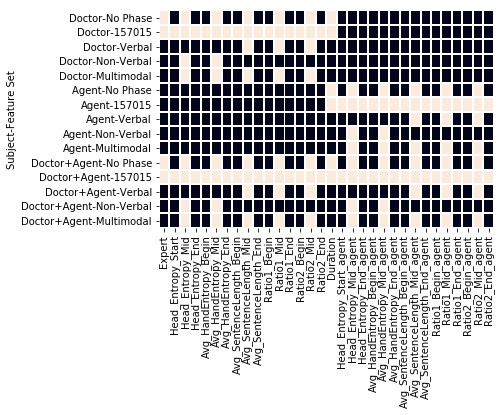

In [183]:


sns.heatmap(features_df.fillna(0).astype('int'), linecolor='white', linewidth=1, annot=False, cbar=False)
plt.savefig(os.path.join(config.OUT_PATH, 'features_sets.png'), bbox_inches = "tight")
plt.show()

# to avoid updating everything below for now

subject_features = get_features_set('Doctor', '157015')
agent_features = get_features_set('Agent', '157015')
all_features = get_features_set('Doctor+Agent', '157015')
subject_features_nophase = get_features_set('Doctor', 'No Phase')
agent_features_nophase = get_features_set('Agent', 'No Phase')
all_features_nophase = get_features_set('Doctor+Agent', 'No Phase')
subject_features_verbal = get_features_set('Doctor', 'Verbal')
agent_features_verbal = get_features_set('Agent', 'Verbal')
all_features_verbal = get_features_set('Doctor+Agent', 'Verbal')
subject_features_nonverbal = get_features_set('Doctor', 'Non-Verbal')
agent_features_nonverbal = get_features_set('Agent', 'Non-Verbal')
all_features_nonverbal = get_features_set('Doctor+Agent', 'Non-Verbal')
subject_features_multimodal = get_features_set('Doctor', 'Multimodal')
agent_features_multimodal = get_features_set('Agent', 'Multimodal')
all_features_multimodal = get_features_set('Doctor+Agent', 'Multimodal')
#subject_features_multimodal_duration = get_features_set('Doctor', 'Multimodal+Duration')
#agent_features_multimodal_duration = get_features_set('Agent', 'Multimodal+Duration')
#all_features_multimodal_duration = get_features_set('Doctor+Agent', 'Multimodal+Duration')


## Dataset preparation

In [184]:


out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)
    
OUT_PATH=os.path.join(config.OUT_PATH, 'cleaned-20190422')

def discretize_class(samples, prediction_task, bins=None, strategy=None, test_set=True):
    """
    Discretizes presence or co-presence score and put result in a new column (if not already existing).
    
    Returns: the name of the new column, or None if one of discretized groups only has 2 samples or less, or if discretization
    failed for any reason.
    """
    cols = []
    for col in samples.columns:
        if 'core' in col:
            cols.append(col)
    print('discretize_class columns %s' % str(cols))
    if bins is None or strategy is None:
        if prediction_task == 'presence':
            class_column='PresenceClass'
        else:
            class_column='CopresenceClass'
        return class_column
    else:
        if prediction_task == 'presence':
            score_column = 'Presence Score'
            class_column = 'PresenceClass_%d_%s' % (bins, strategy)
        else:
            score_column = 'Co-presence Score'
            class_column = 'CopresenceClass_%d_%s' % (bins, strategy)      
        
    if class_column not in samples.columns:
        samples[class_column], enc = discretize(samples[score_column], bins, strategy)
        #TODO: transform test data with discretizer fit on train data
    
    if any(samples[class_column] == -1) or any(samples[class_column].value_counts() < 3):
        return None
    else:
        return class_column

def prepare_train_data(samples, features, prediction_task, bins=None, strategy=None, upsample=None, test_set=True, arff=None, 
                       verbose=0):
    """
    Prepares a dataset for ML.
    
    Parameters
    ----------
    
    samples: DataFrame
    
    features: list
    
    prediction_task: str
        'presence' or 'copresence'
        
    upsample: None or str
        None: no oversampling
        For description of other oversampling method see https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
        imb_random
        imb_smote
        imb_adasyn
        imb_smotenc
        imb_borderlinesmote1
        imb_borderlinesmote2
        imb_svmsmote
    
    arff: str
        If str, arff files will be generated using provided path/name. Default is None.
    
    """
    if verbose > 0:
        print('prepare_train_data: prediction_task=%s, features=%s, upsamples=%s' % (prediction_task, features, upsample))
        #print('prepare_train_data: unique %d' %  len(np.unique(samples.loc[:, features], return_counts=True, axis=0)[1]))
    
    class_column = discretize_class(samples, prediction_task, bins, strategy)
    
    X_test = None
    y_test = None
    if prediction_task == "presence":
        train_idx = train_pres_idx
        test_idx = test_pres_idx
    else:
        train_idx = train_copres_idx
        test_idx = test_copres_idx
        
    if test_set:
        X = samples.loc[train_idx, features].fillna(0)
        X_test = samples.loc[test_idx, features].fillna(0)
        y = samples.loc[train_idx, class_column]
        y_test = samples.loc[test_idx, class_column]
    else:
        X = samples.loc[:, features].fillna(0)
        y = samples[class_column]
        
    ros = None
    if upsample == 'imb_random':
        ros = RandomOverSampler(random_state=RANDOM_STATE)
    elif upsample == 'imb_smote':
        ros = SMOTE(random_state=RANDOM_STATE) 
    elif upsample == 'imb_adasyn':
        ros = ADASYN(random_state=RANDOM_STATE)
    elif upsample == 'imb_smotenc':
        if 'Expert' in features:        
            # SMOTENC is the only one dealing specifically with categorical data (ie 'Expert' feature)
            categorical_vars_indices = [list(features).index('Expert')]
            print(categorical_vars_indices)
            ros = SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_vars_indices)
        else:
            ros = SMOTE(random_state=RANDOM_STATE)
        
    elif upsample == 'imb_borderlinesmote1':
        ros = BorderlineSMOTE(kind='borderline-1', random_state=RANDOM_STATE)      
    elif upsample == 'imb_borderlinesmote2':
        ros = BorderlineSMOTE(kind='borderline-2', random_state=RANDOM_STATE)     
    elif upsample == 'imb_svmsmote':
        ros = SVMSMOTE(random_state=RANDOM_STATE)

    if ros is not None:
        # test set is never oversampled
        print("prepare_train_data: Applying %s oversampling to data %d / %s / unique %d" 
              % (ros.__class__.__name__, len(X), collections.Counter(y), 
                 len(np.unique(X, return_counts=True, axis=0)[1]))) 
        X, y = ros.fit_resample(X, y)     
        X = pd.DataFrame(X, columns=features)
        print("prepare_train_data: Resampled data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))

    if arff is not None:
        generate_arff(arff+'-train', features, prediction_task, X, y)
        
    if test_set:
        if arff is not None:
            generate_arff(arff+'-test', features, prediction_task, X_test, y_test)
        return X, y, X_test, y_test
    else:
        return X, y
    
def generate_arff(fname, features, prediction_task, X, y):
    """
    Generates .arff file format required by JNCC2 java-based classifier.
    
    fname: file name to create without .arff extension (it may contain path information)
    """
    text_file = open(fname+'.arff', "w")
    text_file.write("@RELATION %s\n" % fname)
    for feature in features: #TODO handle types of features ?
        if feature == 'Expert':
            text_file.write("@ATTRIBUTE Expert {0,1}\n")
        else:
            text_file.write("@ATTRIBUTE %s NUMERIC\n" % feature)
    classes_str = '{'
    for idx, cl in enumerate(np.unique(y)):
        classes_str += str(int(cl))
        if idx < len(np.unique(y))-1:
            classes_str += ','
    classes_str += '}'
    if prediction_task == 'presence':
        text_file.write("@ATTRIBUTE PresenceClass %s\n" % classes_str)
    else:
        text_file.write("@ATTRIBUTE CopresenceClass %s\n" % classes_str)
    text_file.write("@DATA\n")
    Xarr = np.array(X)
    for idx, (x_,y_) in enumerate(zip(Xarr,y)):
        try:
            expertIndex = list(features).index('Expert')
            text_file.write("%d,%s,%d\n" % (int(x_[expertIndex]),
                                          ','.join(str(x__) for x__ in x_[1:]),
                                          y_))
        except ValueError:
            text_file.write("%s,%d\n" % (','.join(str(x__) for x__ in x_),
                                       y_))
    text_file.close()

def gridsearch(clf, X, y, prediction_task, param_grid, features, verbose=0):
    if verbose > 0:
        print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s)" 
              % (type(clf), prediction_task, param_grid, features))

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))
    print(np.unique(y, return_counts=True))
    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='f1_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=verbose)
    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

# prepare results
def update_results_from_gridsearch(rdf, cv_results_, p1, p2, p3, p4, p5):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    if p5 == 'score':
        cols = [col for col in df_best.columns if ('mean_test_' in col)]
    elif p5 == 'err':
        cols = [col for col in df_best.columns if ('mean_std_' in col)]
    print('update_results_from_gridsearch: cols %s' % cols)
    update_results(rdf, df_best[cols], p1, p2, p3, p4, p5)
    return rdf

def update_results(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.iloc[0].loc[col]
    return rdf


def update_results_single(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.loc[col]
    return rdf

In [185]:
if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_p_df = all_p_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_p_df
featureset = get_features_set('Doctor', '157015')
print(featureset)
X, y, X_test, y_test = prepare_train_data(dataset, featureset, 
                                          'presence', bins=5, strategy='kmeans', upsample='imb_smotenc', test_set=True, arff='test1')
print(y)

print('Expert feature' + str(X.iloc[:,0]))
print('Train (%d x %d) --> y (%d) ' % (len(X), len(X.iloc[0]), len(y)))
print('Test (%d x %d)' % (len(X_test), len(X_test.iloc[0]) if len(X_test) > 0 else 'n/a'))
print('Nb features %d' % len(featureset))
X

Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object')
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 29, 2.0: 25, 4.0: 14, 1.0: 11, 0.0: 7}) / unique 86
prepare_train_data: Resampled data 145 / Counter({0.0: 29, 1.0: 29, 2.0: 29, 3.0: 29, 4.0: 29}) / unique 145
[2. 1. 3. 3. 3. 0. 2. 3. 2. 3. 3. 2. 3. 4. 3. 2. 4. 2. 3. 4. 3. 0. 2. 2.
 1. 1. 3. 2. 3. 3. 4. 4. 2. 4. 4. 2. 0. 4. 3. 2. 1. 2. 4. 2. 1. 0. 3. 2.
 3. 3. 4. 3. 1. 1. 2. 3. 4. 3. 4. 2. 2. 2. 2. 3. 2. 4. 2. 3. 3. 3. 1. 3.
 3. 1. 1. 2. 0. 2. 3. 2. 3. 4. 1. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

,Expert,Head_Entropy_Start,Head_Entropy_Mid,Head_Entropy_End,Avg_HandEntropy_Begin,Avg_HandEntropy_Mid,Avg_HandEntropy_End,Avg_SentenceLength_Begin,Avg_SentenceLength_Mid,Avg_SentenceLength_End,Ratio1_Begin,Ratio1_Mid,Ratio1_End,Ratio2_Begin,Ratio2_Mid,Ratio2_End,Duration
0,0.0,2.024160,3.074972,1.666493,1.642187,2.376314,1.181431,32.000000,8.250000,7.333333,0.108108,0.146341,0.181818,0.189189,0.185366,0.272727,178.312500
1,0.0,2.158885,3.161219,1.675367,1.813640,2.596538,1.874611,8.200000,7.730769,6.000000,0.136364,0.157635,0.260870,0.204545,0.182266,0.173913,181.600000
2,1.0,1.343719,3.726830,2.307284,1.208490,3.288538,2.214258,14.750000,10.705882,4.909091,0.155844,0.175824,0.155556,0.181818,0.159341,0.155556,261.781250
3,0.0,1.607020,3.375025,1.685876,1.588827,3.276187,1.614408,9.166667,11.647059,7.125000,0.148649,0.169576,0.232143,0.202703,0.199501,0.160714,223.468750
4,0.0,2.000054,2.574184,1.505569,1.281890,2.227998,1.301602,8.166667,6.264706,6.125000,0.068966,0.162679,0.195122,0.206897,0.172249,0.097561,210.437500
5,0.0,0.845381,3.364054,1.024704,0.588017,2.785166,0.432376,4.000000,8.393939,8.000000,0.275000,0.157692,0.214286,0.075000,0.150000,0.142857,196.187500
6,1.0,1.379823,3.031654,1.986499,0.995905,2.864748,1.871523,2.875000,8.066667,6.400000,0.033333,0.122951,0.153846,0.133333,0.172131,0.192308,180.500000
7,1.0,1.910153,3.241893,1.306040,1.669470,2.535192,0.776897,6.666667,7.720000,4.375000,0.314286,0.203125,0.187500,0.085714,0.177083,0.125000,214.968750
8,1.0,1.878206,3.011313,2.369097,1.296718,2.173352,1.856159,5.642857,6.857143,6.285714,0.212500,0.159236,0.125000,0.150000,0.162420,0.200000,264.718750
9,0.0,1.348172,2.258025,1.228402,1.018977,2.338610,1.234306,0.000000,9.125000,9.000000,0.200000,0.205000,0.279070,0.000000,0.150000,0.186047,190.130000


## Feature importance

In [186]:
# from rfpimp

def dropcol_importances_sklearn(model, X_train, y_train, X_valid=None, y_valid=None, metric=None, sample_weights=None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns

    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """

    if X_valid is None: X_valid = X_train
    if y_valid is None: y_valid = y_train
    model_ = clone(model)
    #model_.random_state = RANDOM_STATE
    model_.fit(X_train, y_train)

    if callable(metric):
        baseline = metric(model_, X_valid, y_valid)
    else:
        baseline = model_.score(X_valid, y_valid)
    print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        print("column " + col)
        model__ = clone(model)
        #model__.random_state = RANDOM_STATE
        X_tr = X_train.drop(col, axis=1)
        X_va = X_valid.drop(col, axis=1)
        model__.fit(X_tr, y_train)
        if callable(metric):
            s = metric(model__, X_va, y_valid)
        else:
            s = model__.score(X_va, y_valid)
        print("new score " + str(s))
        drop_in_score = baseline - s
        imp.append(drop_in_score)

    imp = np.array(imp)

    #I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=False)
    
    return imp #I

def dropcol_importances(rf, X_train, y_train, random_state):
    rf_ = clone(rf)
    rf_.random_state = random_state
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    #print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = random_state
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    #I = pd.DataFrame(
    #        data={'Feature':X_train.columns,
    #              'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=True)
    return imp #I

## GridSearch

In [187]:
def score_forest(estimator, X_, y_):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_) # global variable - ugly trick
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def svm_fi(estimator, X_, y_):
    # for SVM dropcol feature importances computation, we use validation data (X_, y_) and train data (X, y) are global.
    #X_train_df = pd.DataFrame(X, columns=feats)
    #y_train_df = pd.DataFrame(y)
    #X_valid_df = pd.DataFrame(X_, columns=feats)
    #y_valid_df = pd.DataFrame(y_)
    #dcs = dropcol_importances_sklearn(clf, X_train_df, y_train_df, X_valid_df, y_valid_df)
    #all_dropcol_feature_importances.append(dcs)
    #print(dcs)
    return 0

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    labels = sorted(np.unique(y).astype(int))
    
    scoring = {}
    scoring['f1_macro'] = 'f1_macro'
    for idx, label in enumerate(labels):
        scoring['f1_macro_class_%d' % label] = make_scorer(f1_score, labels=[label], average='weighted')
    scoring['precision_macro'] = 'precision_macro'
    for idx, label in enumerate(labels):
        scoring['precision_macro_class_%d' % label] = make_scorer(precision_score, labels=[label], average='weighted')    
    scoring['recall_macro'] = 'recall_macro'
    for idx, label in enumerate(labels):
        scoring['recall_macro_class_%d' % label] = make_scorer(recall_score, labels=[label], average='weighted')     
    
    if type(clf) == RandomForestClassifier:
        scoring ['oob'] = score_forest
    else:
        scoring['fi'] = svm_fi
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)


def run_gridsearch(clf, param_grid, data, features, prediction_task, repeat=10, repeat_dc=300, test_set=False, upsample=None, fi=False, bins=None, strategy=None, verbose=0):

    X_test = None
    y_test = None
    
    if test_set:
        X, y, X_test, y_test = prepare_train_data(samples=data, features=features, prediction_task=prediction_task, test_set=test_set,
                                                  upsample=upsample, bins=bins, strategy=strategy, verbose=verbose) 
    else:
        X, y = prepare_train_data(samples=data, features=features, prediction_task=prediction_task, test_set=test_set,
                                  upsample=upsample, bins=bins, strategy=strategy, verbose=verbose) 
    
    # first evaluate best params through grid search for this particular dataset/featureset
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=features, 
                      verbose=verbose)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))

    all_scores=None
    
    if test_set:

        #clf.set_params(**best_params)
        #clf.fit(X, y)
        clf = grid.best_estimator_

        all_scores = run_cross_val_score(clf, 
                              X, y,  
                              verbose=verbose)
        all_scores = pd.DataFrame(all_scores)
        print('Train scores: ' )
        display(HTML(all_scores.to_html()))
        
        """from sklearn.metrics import roc_curve, auc

        y_predict_proba = clf.predict_proba(X_test)

        # Compute ROC curve and ROC AUC for each class
        n_classes = 3
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        all_y_test_i = np.array([])
        all_y_predict_proba = np.array([])
        for i in range(n_classes):
            y_test_i = map(lambda x: 1 if x == i else 0, y_test)
            all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
            all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
            fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
        roc_auc["average"] = auc(fpr["average"], tpr["average"])


        # Plot average ROC Curve
        plt.figure()
        plt.plot(fpr["average"], tpr["average"],
                 label='Average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["average"]),
                 color='deeppink', linestyle=':', linewidth=4)

        # Plot each individual ROC curve
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve %s / %s / test set ? %s / oversampling %s' % (clf.__class__.__name__, prediction_task, 
                                                                           test_set, upsample))
        plt.legend(loc="lower right")
        plt.show()"""
        
    if not test_set:
        print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))
        all_scores = []
        global all_feature_importances
        global all_dropcol_feature_importances
        for i in np.arange(repeat):
            #forest = RandomForestClassifier(oob_score=True)
            # set best params to classifier

            clf.set_params(**best_params)

            scores = run_cross_val_score(clf, 
                              X, y,  
                              verbose=verbose)
            print("iter # %d" % i)
            #    print(scores)
            scores_df = pd.DataFrame(scores)
            #print(scores_df)
            #print(scores_df.columns)
            all_scores.append(scores_df)


    
        # compute feature importance for random forest : we don't need validation data as it relies on oob score
        if type(clf) == RandomForestClassifier:
            all_feature_importances = pd.DataFrame(all_feature_importances, columns=features)        
            if fi:
                X_ = pd.DataFrame(X, columns=features)
                y_ = pd.DataFrame(y)        
                for i in np.arange(repeat_dc):
                    # alternative computation for feature importance
                    all_dropcol_feature_importances.append(dropcol_importances(clf, X_, y_, RANDOM_STATE+i))
        else:
            all_feature_importances = None
            all_dropcol_feature_importances = None
            '''print(X, y)
            skf = StratifiedKFold(n_splits=repeat, random_state=RANDOM_STATE, shuffle=True)
            for i in np.arange(repeat_dc):
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    X_train = pd.DataFrame(X_train, columns=features)
                    X_test = pd.DataFrame(X_test, columns=features)
                    y_train = pd.DataFrame(y_train)
                    y_test = pd.DataFrame(y_test)
                    # alternative computation for feature importance
                    dcs = dropcol_importances_sklearn(clf, X_train, y_train, X_test, y_test, RANDOM_STATE+i)
                    print("X_train %s X_test %s y_train %s y_test %s" % (len(X_train), len(X_test), len(y_train), len(y_test)))
                    print(dcs)
                    all_dropcol_feature_importances.append(dcs)'''

        all_scores = pd.concat(all_scores)
        if all_dropcol_feature_importances is not None:
            all_dropcol_feature_importances = pd.DataFrame(all_dropcol_feature_importances, columns=features)
            
    support = np.unique(y, return_counts=True)
    support_test = None
    if test_set:
        support_test = np.unique(y_test, return_counts=True)
    
    return grid, all_scores, all_dropcol_feature_importances, all_feature_importances, support, support_test, X, y, X_test, y_test


## Test plan utilities

### Global configuration

In [188]:
configuration = {
    'subject': {
        'doctor': {
            'name': 'Doctor',
            'modes': {
                'verbal': {
                    'dataset': subject_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': subject_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': subject_np_df,
                    'name': 'Multimodal'
                }
            },
            'phases': {
                'nophase': {
                    'dataset': subject_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': subject_p_df,
                    'name': '157015'
                }
            }
        },
        'agent': {
            'name': 'Agent',
            'modes': {
                'verbal': {
                    'dataset': agent_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': agent_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': agent_np_df,
                    'name': 'Multimodal'
                }
            },
            'phases': {
                'nophase': {
                    'dataset': agent_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': agent_p_df,
                    'name': '157015'
                }
            }            
        },
        'doctor+agent': {
            'name': 'Doctor+Agent',
            'modes': {
                'verbal': {
                    'dataset': all_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': all_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': all_np_df,
                    'name': 'Multimodal'
                }
            },
            'phases': {
                'nophase': {
                    'dataset': all_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': all_p_df,
                    'name': '157015'
                }
            }            
        }        
    },
    'features': {
        'verbal': 'Verbal',
        'nonverbal': 'Non-Verbal',
        'multimodal': 'Multimodal',
        'multimodal+duration': 'Multimodal+Duration',
        '157015': '157015',
        'nophase': 'No Phase'
    },
    'classifier': {
        'forest': {
            'clf': RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True),
            'param_grid': param_grid_rf,
            'name': 'RF'
        },
        'svm': {
            'clf': make_pipeline(ct, SVC(random_state=RANDOM_STATE, probability=True)),
            'param_grid': param_grid_svm,
            'name': 'SVM'
        },
        'gnb': {
            'clf': make_pipeline(ct, GaussianNB()),
            'param_grid': param_grid_gnb,
            'name': 'NB-G'
        },
        'name' : 'Classifier'
    },
    'prediction_task': {
        'presence': 'Presence',
        'copresence': 'Co-Presence'
    }
}

### Results utilities

In [189]:
def get_df_multiindex(test_plan_params):
    iindex = [['Presence', 'Co-Presence'],
              ['Doctor', 'Agent', 'Doctor+Agent']]
    inames = ['Target', 'Subject']

    if 'modes' in test_plan_params.keys():
        exps = test_plan_params['modes']
        exps_name = 'Mode'
    elif 'phases' in test_plan_params.keys():
        exps = test_plan_params['phases']
        exps_name = 'Phases'

    exp_level = []
    for exp in exps:
        exp_level.append(configuration['features'][exp])
    if len(exp_level) > 0:
        iindex.append(exp_level)
        inames.append(exps_name)

    clf_level = []
    for clf_id in test_plan_params['classifier']:
        clf_level.append(configuration['classifier'][clf_id]['name'])
    if len(clf_level) > 0:
        iindex.append(clf_level)
        inames.append('Classifier')

    if 'upsampling' in test_plan_params.keys():
        up_level = []
        for up_id in test_plan_params['upsampling']:
            up_level.append(str(up_id))
        iindex.append(up_level)
        inames.append('Oversampling')

    iindex.append(['score', 'err'])
    inames.append('Metric')

    scores_df_index = iindex
    print(scores_df_index)
    scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                      names = inames)
    return scores_df_multiindex

def get_results_tuple(test, upsample_strategy_default):
    subject = test['subject']
    subj_conf = configuration['subject'][subject]
    prediction_task = test['prediction_task']
    classifier = test['classifier']
    
    if 'modes' in test.keys():
        fset = test['modes']  
    elif 'phases' in test.keys():
        fset = test['phases']     

    if 'upsampling' in test:
        upsample = test['upsampling']
    else:
        upsample = upsample_strategy_default

    result_tuple = ()
    result_tuple = result_tuple + ('Presence',) if prediction_task == 'presence' else ('Co-Presence',)
    result_tuple = result_tuple + (subj_conf['name'],)
    result_tuple = result_tuple + (configuration['features'][fset],)
    result_tuple = result_tuple + (configuration['classifier'][classifier]['name'],)
    
    if 'upsampling' in test:
        result_tuple = result_tuple + (str(upsample),)
        
    return result_tuple

def get_categorical_features(X):
    if 'Expert' in X.columns:
        return ['Expert']
    else:
        return []

ct = make_column_transformer(
    (FunctionTransformer(), get_categorical_features), # default FunctionTransformer implements identity
    remainder=StandardScaler()
)

### Test plan runner

In [193]:
# number of kfolds folds for cross validations
cv = 10
# number of kfold cross validations performed to compute mean scores
repeat = 10
# number of random forest training performed to compute mean features importances
repeat_dc = 300
# number of bins for presence / co-presence discretization
n_bins_default = 5
# strategy for presence / co-presence discretization
bin_strategy_default = 'kmeans'
# default upsampling
upsample_strategy_default = 'imb_smotenc'
# whether to apply 'original' upsampling method
#upsample = True
verbose=1
test_set = True
fi = False

def run_test_plan(test_plan_params, group, exp, iter, test_set=True, cv=10, repeat_cv=10, repeat_fi=300, 
                  upsample_strategy=upsample_strategy_default, n_bins=n_bins_default, bin_strategy=bin_strategy_default, 
                  verbose=verbose):
    """
    """
    ### Create dataframe for results and context

    dh = DataHandler(group, exp, iter)
    scores_df_multiindex = get_df_multiindex(test_plan_params)

    scores_df = dh.load_obj('results', 'scores')
    if scores_df is None:
        scores_df = pd.DataFrame(index=scores_df_multiindex)
        dh.save_obj(scores_df, 'results', 'scores')
    context_df = dh.load_obj('.', 'context')
    if context_df is None:
        context_df = pd.DataFrame(index=scores_df_multiindex)
        context_df['Best Params'] = ''
        context_df['Best Params'] = context_df['Best Params'].apply(str)
        dh.save_obj(context_df, '.', 'context')
    
    ### Execute test plan and fill results dataframes
    
    test_plan = list(ParameterGrid(test_plan_params))
    print("%d tests to be performed" % len(test_plan))
    for test in test_plan:
        print(test)
    
    for idx, test in enumerate(test_plan):
        print("Test %d : %s" % (idx, test))

        #try:
        print("before")
        # make it global because we use them to compute feature importance for forests
        all_feature_importances = []    
        all_dropcol_feature_importances = []

        subject = test['subject']
        prediction_task = test['prediction_task']
        classifier = test['classifier']

        if 'upsampling' in test:
            upsample = test['upsampling']
        else:
            upsample = upsample_strategy

        clf = configuration['classifier'][classifier]['clf']
        pgrid = configuration['classifier'][classifier]['param_grid']
        subj_conf = configuration['subject'][subject]
        if 'modes' in test.keys():
            fset = test['modes']
            df = subj_conf['modes'][fset]['dataset']
            feats = get_features_set(subj_conf['name'], subj_conf['modes'][fset]['name'])      
        elif 'phases' in test.keys():
            fset = test['phases']
            df = subj_conf['phases'][fset]['dataset']
            feats = get_features_set(subj_conf['name'], subj_conf['phases'][fset]['name'])

        if upsample not in (None, 'imb_smotenc') and 'Expert' in feats:
            print ('ERROR: only SMOTE-NC is supported with categorical features, skipping test')
            continue

        print("after")

        start = time.time()

        #X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample, test_set=True) 

        grid, scores, dropcol_fis, fis, support, support_test, X, y, X_test, y_test = run_gridsearch(
                                                        clf, 
                                                        pgrid, 
                                                        df, feats, 
                                                        prediction_task, 
                                                        repeat=repeat_cv, repeat_dc=repeat_fi, 
                                                        upsample=upsample, 
                                                        test_set=test_set,
                                                        fi=fi,
                                                        bins=n_bins, strategy=bin_strategy,
                                                        verbose=verbose)
        print(scores.mean(axis='columns'))

        if test_set:
            clf = grid.best_estimator_
            y_pred = clf.predict(X_test)
            labels = sorted(support[0])
            print("LABELS " + str(labels))
            test_scores = {
                'test_balanced_acc': balanced_accuracy_score(y_test, y_pred),
                'test_balanced_acc_adjusted': balanced_accuracy_score(y_test, y_pred, adjusted=True),
                'test_f1_macro_weighted': f1_score(y_test, y_pred, average='weighted') }
            for idx, label in enumerate(labels):
                test_scores['test_f1_macro_class_%d' % label] = f1_score(y_test, y_pred, labels=[label], average='weighted')
            test_scores['test_precision_macro_weighted'] =  precision_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores['test_precision_macro_class_%d' % label] = precision_score(y_test, y_pred, labels=[label], average='weighted')            
            test_scores['test_recall_macro_weighted'] =  recall_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores['test_recall_macro_class_%d' % label] = recall_score(y_test, y_pred, labels=[label], average='weighted')            

            test_scores_df = pd.DataFrame([test_scores], index=['score']).T

        elapsed = time.time() - start
        print("   Elapsed %s seconds" % str(elapsed))

        isDoc = 'doctor' in subject
        isAgent = 'agent' in subject

        results_tuple = get_results_tuple(test, upsample_strategy_default=upsample_strategy)

        # compute err
        all_scores_ = scores.drop(['score_time'], axis=1).T
        final = pd.DataFrame(index=all_scores_.index)
        final['score'] = all_scores_.mean(axis=1)
        final['err'] = all_scores_.std(axis=1)
        final.index = [row.replace('test_', 'val_') for row in final.index]

        final_ = pd.concat([final, test_scores_df], axis=0, join='outer').T
        # display(HTML(final_.to_html()))
        final = pd.DataFrame(index=scores_df_multiindex, columns=final_.columns)
        #display(HTML(final.to_html()))
        final.loc[results_tuple + ('score',)] = final_.loc['score']
        final.loc[results_tuple + ('err',)] = final_.loc['err']
        final.dropna(axis='rows', how='all', inplace=True)
        #display(HTML(final.to_html()))


        #test_set_name = dh.get_grid_name(prediction_task, isDoc, isAgent, modes, classifier)
        print("      updating scores for %s" % str(results_tuple))

        # insert missing columns in results df
        s = set(final.columns) - set(scores_df.columns)
        print("DEBUG inserting new columns %s" % str(s))
        new = list(sorted(s))
        #new.extend(list(sorted(s)))
        for newcol in new:
            scores_df[newcol] = [np.nan]*len(scores_df)

        #print(final.loc[(presidx, subjidx, phidx, clfidx, osidx, 'score')].to_dict())
        #display(HTML(scores_df.dropna(axis='rows', how='all', inplace=False).to_html()))
        scores_df.loc[results_tuple + ('score',)] = pd.Series(final.loc[results_tuple + ('score',)].to_dict())
        scores_df.loc[results_tuple + ('err',)] = pd.Series(final.loc[results_tuple + ('err',)].to_dict())
        #display(HTML(scores_df.dropna(axis='rows', how='all', inplace=False).to_html()))
        #scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['score']).T, presidx, subjidx, phidx, clfidx, 'score')
        #scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['std']).T, presidx, subjidx, phidx, clfidx, 'err')    
        dh.save_obj(scores_df, 'results', 'scores')

        dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
        scores_df.to_excel(dumpPath, index=True)

        new_row = pd.Series({
            'UpSample': upsample, 
            'KFolds': cv, 
            'KFolds count': repeat_cv, 
            'FI count': repeat_fi,
            'Best Params': str(grid.best_params_), 
            'Duration': elapsed, 
            'Support': str(support), 
            'Support (test)': str(support_test), 
            'Features': str(feats)
        })
        context_df.loc[results_tuple + ('score',)] = new_row
        dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
        context_df.to_csv(dumpPath, index=True)


        """
        # features importances
        if dropcol_fis is not None:
            final_fi = dropcol_fis.T
            final_fi['means'] = final_fi.mean(axis=1)
            final_fi['std'] = final_fi.std(axis=1)
            final_fi['sem'] = final_fi.sem(axis=1)
            final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
            plot_importance('Columns Drop - ' + test_set_name, 
                            final_fi['means'],
                            final_fi['confidence'],
                            feats, 
                            sort=False)
            dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
            final_fi.to_excel(dumpPath, index=True)


        if fis is not None:
            final_fi_ = fis.T
            final_fi_['means'] = final_fi_.mean(axis=1)
            final_fi_['std'] = final_fi_.std(axis=1)
            final_fi_['sem'] = final_fi_.sem(axis=1)
            final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
            plot_importance('Gini - ' + test_set_name, 
                            final_fi_['means'],
                            final_fi_['confidence'],
                            feats, 
                            sort=False)
            dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
            final_fi.to_excel(dumpPath, index=True)"""

        #except Exception as e:
        #    print("ERROR: exception occurred, skiping test")
        #    print(e)
        
    return dh


### Plots

In [190]:
def plot_importance(title, importances, importances_err, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    if importances_err is not None:
        errs = [importances_err[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    if importances_err is not None:
        plt.bar(range(len(feature_names)), importances[indices], yerr=errs, xerr=0.1)
    else:
        plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    dh.save_fig(title)
    #plt.savefig(os.path.join(dh.root_path, 'figures', title+'.png'))
    plt.show()


In [219]:
# Some utilities for plots


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, nlevels=-1):
    ypos = -.1
    scale = 1./df.index.size
    if nlevels == -1:
        nlevels = df.index.nlevels
    for level in range(nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

# Experiments

## Random Forests - n_estimators evaluation
First for Random Forests Classifier, we study when out of bag score stabilizes for a range of n_estimators values.
We will use found n_estimator value with good balance between score and reliability, and performances.

Note: we hypothetize that we can find this value on a specific feature set (subject doctor, no phase) and use it for other sets of features, given overall domain and task remain similar.

In [72]:
def oob_score(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    score = estimator.oob_score_
    return score


X, y, X_test, y_test = prepare_train_data(all_p_df, get_features_set('Doctor+Agent', '157015'), prediction_task='presence', 
                                          upsample='imb_smotenc', bins=5, strategy='kmeans', test_set=True)

#n_estimators_range = np.arange(1,100, 10)#
n_estimators_range = np.unique(np.logspace(0, 3.5, 100, dtype=int)) #TODO launch with exp+5 and more values
scores = []
errs = []
test_acc = []
test_acc_adjusted = []
test_f1 = []
test_precision = []
test_recall = []
scoring = {
    'oob' : oob_score,
    'f1_macro' : 'f1_macro',
    'precision_macro' : 'precision_macro',
    'recall_macro' : 'recall_macro'         
}

from tqdm import tqdm, tqdm_notebook

pbar = tqdm_notebook(n_estimators_range, desc='n_estimators')
for i in pbar:
    pbar.set_description('n_estimators = %d / %s' % (i, n_estimators_range[-1]))
    clf = RandomForestClassifier(n_estimators=int(i), oob_score=True)
    result = cross_validate(clf, X, y, scoring=scoring, return_train_score=False, cv=5, verbose=0)
    scores.append(pd.DataFrame(result).mean().values)
    errs.append(pd.DataFrame(result).std().values)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    test_acc.append(balanced_accuracy_score(y_test, y_pred))
    test_acc_adjusted.append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    test_f1.append(f1_score(y_test, y_pred, average='weighted'))
    test_precision.append(precision_score(y_test, y_pred, average='weighted'))
    test_recall.append(precision_score(y_test, y_pred, average='weighted'))

[0]
prepare_train_data: Applying SMOTENC oversampling to data 76 / Counter({3.0: 24, 2.0: 23, 4.0: 13, 1.0: 10, 0.0: 6}) / unique 76
prepare_train_data: Resampled data 120 / Counter({0.0: 24, 1.0: 24, 2.0: 24, 3.0: 24, 4.0: 24}) / unique 120


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSduX2VzdGltYXRvcnMnLCBtYXg9ODAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


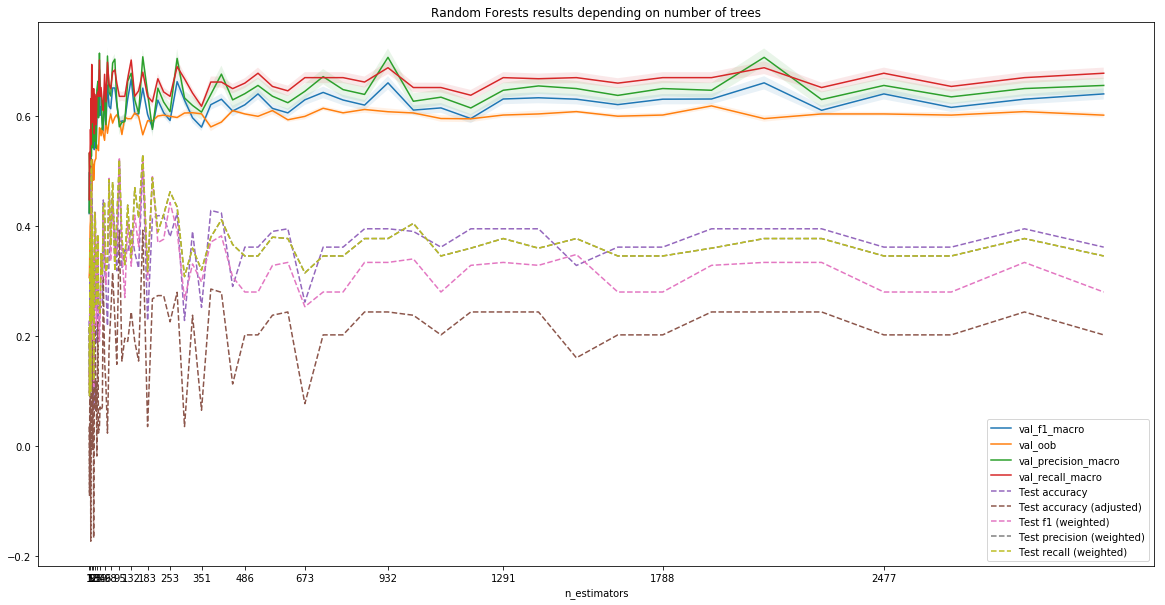

In [73]:
df = pd.DataFrame(scores, columns=pd.DataFrame(result).columns)
dferr = pd.DataFrame(errs, columns=pd.DataFrame(result).columns)
df = df.drop(['fit_time', 'score_time'], axis=1)
dferr = dferr.drop(['fit_time', 'score_time'], axis=1)
plt.figure(figsize=(20,10))
plt.hlines(y=df['test_oob'][400:].mean(), xmin=0.0, xmax=1000, color='black')
for key in df.columns:
    plt.plot(n_estimators_range, df[key], label=key.replace('test_', 'val_'))
    plt.fill_between(n_estimators_range, 
                     df[key]+(dferr[key]/np.sqrt(len(dferr))), 
                     df[key]-(dferr[key]/np.sqrt(len(dferr))),
                     alpha=0.1)
plt.plot(n_estimators_range, test_acc, '--', label='Test accuracy')
plt.plot(n_estimators_range, test_acc_adjusted, '--', label='Test accuracy (adjusted)')
plt.plot(n_estimators_range, test_f1, '--', label='Test f1 (weighted)')
plt.plot(n_estimators_range, test_precision, '--', label='Test precision (weighted)')
plt.plot(n_estimators_range, test_recall, '--', label='Test recall (weighted)')
plt.xticks(n_estimators_range[::4], n_estimators_range[::4])
plt.legend()
plt.xlabel('n_estimators')
plt.title('Random Forests results depending on number of trees')
dh = DataHandler('common', 'nb_trees')
#dh.save_fig(plt, 'RF_nb_trees_5bins_kmeans_smotenc_detailed')

## Gridsearch hyper-parameters ranges

In [256]:
# random forests
param_grid_rf =  {
    'n_estimators' : [30],
    'max_features': [None, 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}
# for quickly testing the loops
param_grid_rf_tests = {
    'n_estimators' : [10],
    'max_features': [None],
    "max_depth": [None],
    "min_samples_leaf": [1]
}

# SVM
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}

# Gaussian Naive Bayes
param_grid_gnb = {
    'gaussiannb__priors': [None], 
    'gaussiannb__var_smoothing': [1e-09]
}


## Experiment: upsampling strategy

In [257]:
test_plan_params_upsampling = {
    'classifier': ['gnb', 'svm', 'forest'],
    'subject': ['doctor+agent'],
    'prediction_task': ['presence'],
    'modes': ['multimodal'],
    'upsampling': [None, 'imb_random', 'imb_smote', 'imb_smotenc', 'imb_borderlinesmote1', 
               'imb_borderlinesmote2', 'imb_svmsmote']
}

In [258]:
dh_upsampling = run_test_plan(test_plan_params_upsampling, 'upsampling_strategy', 'NB-G', 1)

[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['Multimodal'], ['NB-G', 'SVM', 'RF'], ['None', 'imb_random', 'imb_smote', 'imb_smotenc', 'imb_borderlinesmote1', 'imb_borderlinesmote2', 'imb_svmsmote'], ['score', 'err']]
load_obj: opening C:\IAAA\TER\_output\upsampling_strategy\NB-G-1\results\scores.pkl
file does not yet exist C:\IAAA\TER\_output\upsampling_strategy\NB-G-1\results\scores.pkl
load_obj: opening C:\IAAA\TER\_output\upsampling_strategy\NB-G-1\.\context.pkl
file does not yet exist C:\IAAA\TER\_output\upsampling_strategy\NB-G-1\.\context.pkl
21 tests to be performed
{'upsampling': None, 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
{'upsampling': 'imb_random', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
{'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
{'upsampling'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.24777593207825763
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.005,0.052,0.327619,0.0,0.571429,0.666667,0.4,0.000000,0,0.313333,0.0,0.400000,0.666667,0.5,0.0,0.400000,0.0,1.0,0.666667,0.333333,0.0
1,0.006,0.053,0.294286,0.0,0.000000,0.571429,0.4,0.500000,0,0.300000,0.0,0.000000,0.500000,0.5,0.5,0.300000,0.0,0.0,0.666667,0.333333,0.5
2,0.004,0.041,0.133333,0.0,0.000000,0.000000,0.0,0.666667,0,0.200000,0.0,0.000000,0.000000,0.0,1.0,0.100000,0.0,0.0,0.000000,0.000000,0.5
3,0.005,0.050,0.371429,0.0,0.500000,0.857143,0.0,0.500000,0,0.316667,0.0,0.333333,0.750000,0.0,0.5,0.500000,0.0,1.0,1.000000,0.000000,0.5
4,0.005,0.047,0.066667,0.0,0.000000,0.333333,0.0,0.000000,0,0.066667,0.0,0.000000,0.333333,0.0,0.0,0.066667,0.0,0.0,0.333333,0.000000,0.0
5,0.006,0.046,0.400000,0.0,0.500000,1.000000,0.5,0.000000,0,0.466667,0.0,0.333333,1.000000,1.0,0.0,0.466667,0.0,1.0,1.000000,0.333333,0.0
6,0.005,0.038,0.088889,0.0,0.000000,0.444444,0.0,0.000000,0,0.057143,0.0,0.000000,0.285714,0.0,0.0,0.200000,0.0,0.0,1.000000,0.000000,0.0
7,0.004,0.038,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
8,0.005,0.037,0.493333,0.0,1.000000,0.000000,0.8,0.666667,0,0.500000,0.0,1.000000,0.000000,1.0,0.5,0.533333,0.0,1.0,0.000000,0.666667,1.0
9,0.005,0.037,0.291667,0.0,0.000000,0.666667,0.5,0.000000,0,0.375000,0.0,0.000000,1.000000,0.5,0.0,0.250000,0.0,0.0,0.500000,0.500000,0.0


0    0.300129
1    0.258320
2    0.125952
3    0.342075
4    0.059619
5    0.383429
6    0.100914
7    0.002000
8    0.438190
9    0.220254
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.838000059128 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'None')
DEBUG inserting new columns set(['val_precision_macro', 'test_recall_macro_weighted', 'fit_time', 'test_precision_macro_weighted', 'test_balanced_acc', 'val_recall_macro_class_2', 'val_recall_macro_class_3', 'val_recall_macro_class_0', 'val_recall_macro_class_1', 'val_f1_macro', 'val_recall_macro_class_4', 'test_balanced_acc_adjusted', 'test_f1_macro_weighted', 'val_recall_macro', 'test_recall_macro_class_4', 'test_recall_macro_class_0', 'test_recall_macro_class_1', 'test_recall_macro_class_2', 'test_recall_macro_class_3', 'val_f1_macro_class_2', 'val_f1_macro_class_3', 'val_f1_macro_class_0', 'val_f1_macro_class_1', 'val_f1_macro_class_4', 'test_precision_macro_class_4', 'test_precis

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


  Gridsearch evaluated best score 0.37872518286311385


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.005,0.041,0.319394,0.500000,0.363636,0.000000,0.400000,0.333333,0,0.416667,1.000000,0.250000,0.000000,0.5,0.333333,0.333333,0.333333,0.666667,0.000000,0.333333,0.333333
1,0.005,0.045,0.534286,0.571429,0.800000,0.400000,0.400000,0.500000,0,0.580000,0.500000,1.000000,0.500000,0.5,0.400000,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
2,0.005,0.043,0.373810,0.750000,0.285714,0.333333,0.000000,0.500000,0,0.436667,0.600000,0.250000,0.333333,0.0,1.000000,0.400000,1.000000,0.333333,0.333333,0.000000,0.333333
3,0.005,0.047,0.414286,0.750000,0.750000,0.571429,0.000000,0.000000,0,0.340000,0.600000,0.600000,0.500000,0.0,0.000000,0.533333,1.000000,1.000000,0.666667,0.000000,0.000000
4,0.006,0.044,0.438095,0.857143,0.666667,0.000000,0.000000,0.666667,0,0.383333,0.750000,0.500000,0.000000,0.0,0.666667,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
5,0.006,0.044,0.484762,0.666667,0.500000,0.857143,0.400000,0.000000,0,0.463333,0.666667,0.400000,0.750000,0.5,0.000000,0.533333,0.666667,0.666667,1.000000,0.333333,0.000000
6,0.005,0.040,0.230000,0.750000,0.400000,0.000000,0.000000,0.000000,0,0.220000,0.600000,0.500000,0.000000,0.0,0.000000,0.266667,1.000000,0.333333,0.000000,0.000000,0.000000
7,0.006,0.035,0.129870,0.363636,0.285714,0.000000,0.000000,0.000000,0,0.100000,0.250000,0.250000,0.000000,0.0,0.000000,0.200000,0.666667,0.333333,0.000000,0.000000,0.000000
8,0.005,0.034,0.487619,0.666667,0.285714,0.285714,0.800000,0.400000,0,0.533333,0.666667,0.250000,0.250000,1.0,0.500000,0.466667,0.666667,0.333333,0.333333,0.666667,0.333333
9,0.005,0.035,0.373333,0.000000,0.400000,0.400000,0.666667,0.400000,0,0.400000,0.000000,0.333333,0.333333,1.0,0.333333,0.400000,0.000000,0.500000,0.500000,0.500000,0.500000


0    0.307732
1    0.473129
2    0.348136
3    0.370367
4    0.389456
5    0.425646
6    0.206905
7    0.124772
8    0.426891
9    0.337143
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.755000114441 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'imb_random')
DEBUG inserting new columns set([])
Test 2 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.4536453201970443
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.048,0.426667,0.000000,0.400000,0.666667,0.400000,0.666667,0,0.423810,0.000000,0.285714,0.666667,0.500000,0.666667,0.466667,0.000000,0.666667,0.666667,0.333333,0.666667
1,0.006,0.048,0.601905,0.666667,0.800000,0.571429,0.400000,0.571429,0,0.633333,0.666667,1.000000,0.500000,0.500000,0.500000,0.600000,0.666667,0.666667,0.666667,0.333333,0.666667
2,0.006,0.049,0.288889,0.500000,0.444444,0.000000,0.000000,0.500000,0,0.346667,0.400000,0.333333,0.000000,0.000000,1.000000,0.333333,0.666667,0.666667,0.000000,0.000000,0.333333
3,0.005,0.053,0.333333,0.500000,0.500000,0.666667,0.000000,0.000000,0,0.293333,0.400000,0.400000,0.666667,0.000000,0.000000,0.400000,0.666667,0.666667,0.666667,0.000000,0.000000
4,0.006,0.044,0.454762,0.857143,0.750000,0.000000,0.000000,0.666667,0,0.403333,0.750000,0.600000,0.000000,0.000000,0.666667,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
5,0.006,0.040,0.723333,0.750000,0.666667,1.000000,0.800000,0.400000,0,0.753333,0.600000,0.666667,1.000000,1.000000,0.500000,0.733333,1.000000,0.666667,1.000000,0.666667,0.333333
6,0.005,0.035,0.342857,0.571429,0.857143,0.000000,0.000000,0.285714,0,0.300000,0.500000,0.750000,0.000000,0.000000,0.250000,0.400000,0.666667,1.000000,0.000000,0.000000,0.333333
7,0.004,0.037,0.367619,0.571429,0.600000,0.000000,0.000000,0.666667,0,0.319048,0.500000,0.428571,0.000000,0.000000,0.666667,0.466667,0.666667,1.000000,0.000000,0.000000,0.666667
8,0.004,0.035,0.534762,0.857143,0.750000,0.000000,0.666667,0.400000,0,0.503333,0.750000,0.600000,0.000000,0.666667,0.500000,0.600000,1.000000,1.000000,0.000000,0.666667,0.333333
9,0.004,0.034,0.466667,0.500000,0.666667,0.500000,0.666667,0.000000,0,0.500000,0.500000,0.500000,0.500000,1.000000,0.000000,0.500000,0.500000,1.000000,0.500000,0.500000,0.000000


0    0.378898
1    0.526925
2    0.279444
3    0.296095
4    0.399932
5    0.633619
6    0.299864
7    0.331476
8    0.469884
9    0.420857
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.801000118256 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'imb_smote')
DEBUG inserting new columns set([])
Test 3 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.4536453201970443
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.044,0.426667,0.000000,0.400000,0.666667,0.400000,0.666667,0,0.423810,0.000000,0.285714,0.666667,0.500000,0.666667,0.466667,0.000000,0.666667,0.666667,0.333333,0.666667
1,0.005,0.039,0.601905,0.666667,0.800000,0.571429,0.400000,0.571429,0,0.633333,0.666667,1.000000,0.500000,0.500000,0.500000,0.600000,0.666667,0.666667,0.666667,0.333333,0.666667
2,0.004,0.037,0.288889,0.500000,0.444444,0.000000,0.000000,0.500000,0,0.346667,0.400000,0.333333,0.000000,0.000000,1.000000,0.333333,0.666667,0.666667,0.000000,0.000000,0.333333
3,0.004,0.035,0.333333,0.500000,0.500000,0.666667,0.000000,0.000000,0,0.293333,0.400000,0.400000,0.666667,0.000000,0.000000,0.400000,0.666667,0.666667,0.666667,0.000000,0.000000
4,0.007,0.044,0.454762,0.857143,0.750000,0.000000,0.000000,0.666667,0,0.403333,0.750000,0.600000,0.000000,0.000000,0.666667,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
5,0.006,0.039,0.723333,0.750000,0.666667,1.000000,0.800000,0.400000,0,0.753333,0.600000,0.666667,1.000000,1.000000,0.500000,0.733333,1.000000,0.666667,1.000000,0.666667,0.333333
6,0.005,0.034,0.342857,0.571429,0.857143,0.000000,0.000000,0.285714,0,0.300000,0.500000,0.750000,0.000000,0.000000,0.250000,0.400000,0.666667,1.000000,0.000000,0.000000,0.333333
7,0.004,0.035,0.367619,0.571429,0.600000,0.000000,0.000000,0.666667,0,0.319048,0.500000,0.428571,0.000000,0.000000,0.666667,0.466667,0.666667,1.000000,0.000000,0.000000,0.666667
8,0.005,0.037,0.534762,0.857143,0.750000,0.000000,0.666667,0.400000,0,0.503333,0.750000,0.600000,0.000000,0.666667,0.500000,0.600000,1.000000,1.000000,0.000000,0.666667,0.333333
9,0.004,0.036,0.466667,0.500000,0.666667,0.500000,0.666667,0.000000,0,0.500000,0.500000,0.500000,0.500000,1.000000,0.000000,0.500000,0.500000,1.000000,0.500000,0.500000,0.000000


0    0.378707
1    0.526449
2    0.278778
3    0.295190
4    0.399980
5    0.633571
6    0.299816
7    0.331381
8    0.470027
9    0.420952
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.726000070572 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'imb_smotenc')
DEBUG inserting new columns set([])
Test 4 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote1
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying BorderlineSMOTE overs

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.4786580086580086
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.007,0.043,0.368889,0.000000,0.444444,0.666667,0.333333,0.400000,0,0.366667,0.000000,0.333333,0.666667,0.333333,0.500000,0.400000,0.000000,0.666667,0.666667,0.333333,0.333333
1,0.005,0.041,0.527619,0.666667,0.666667,0.333333,0.400000,0.571429,0,0.533333,0.666667,0.666667,0.333333,0.500000,0.500000,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
2,0.004,0.034,0.290476,0.666667,0.285714,0.000000,0.000000,0.500000,0,0.350000,0.500000,0.250000,0.000000,0.000000,1.000000,0.333333,1.000000,0.333333,0.000000,0.000000,0.333333
3,0.004,0.034,0.471429,0.750000,0.750000,0.857143,0.000000,0.000000,0,0.390000,0.600000,0.600000,0.750000,0.000000,0.000000,0.600000,1.000000,1.000000,1.000000,0.000000,0.000000
4,0.003,0.041,0.438095,0.857143,0.666667,0.000000,0.000000,0.666667,0,0.416667,0.750000,0.666667,0.000000,0.000000,0.666667,0.466667,1.000000,0.666667,0.000000,0.000000,0.666667
5,0.005,0.040,0.634762,0.666667,0.857143,0.750000,0.500000,0.400000,0,0.703333,0.666667,0.750000,0.600000,1.000000,0.500000,0.666667,0.666667,1.000000,1.000000,0.333333,0.333333
6,0.004,0.035,0.433333,1.000000,0.666667,0.000000,0.000000,0.500000,0,0.413333,1.000000,0.666667,0.000000,0.000000,0.400000,0.466667,1.000000,0.666667,0.000000,0.000000,0.666667
7,0.004,0.036,0.433333,0.750000,0.750000,0.000000,0.000000,0.666667,0,0.373333,0.600000,0.600000,0.000000,0.000000,0.666667,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
8,0.004,0.035,0.562424,0.800000,0.545455,0.000000,0.800000,0.666667,0,0.608333,1.000000,0.375000,0.000000,1.000000,0.666667,0.600000,0.666667,1.000000,0.000000,0.666667,0.666667
9,0.004,0.034,0.700000,1.000000,0.666667,0.666667,0.666667,0.500000,0,0.800000,1.000000,0.500000,1.000000,1.000000,0.500000,0.700000,1.000000,1.000000,0.500000,0.500000,0.500000


0    0.326825
1    0.457701
2    0.280041
3    0.419361
4    0.379646
5    0.574932
6    0.377095
7    0.384762
8    0.507788
9    0.630381
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.701000213623 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'imb_borderlinesmote1')
DEBUG inserting new columns set([])
Test 5 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying BorderlineSM

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


  Gridsearch evaluated best score 0.45262910798122064


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.051,0.306667,0.000000,0.400000,0.400000,0.333333,0.400000,0,0.323810,0.000000,0.285714,0.500000,0.333333,0.500000,0.333333,0.000000,0.666667,0.333333,0.333333,0.333333
1,0.006,0.053,0.527619,0.666667,0.666667,0.333333,0.400000,0.571429,0,0.533333,0.666667,0.666667,0.333333,0.500000,0.500000,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
2,0.007,0.045,0.300000,0.666667,0.333333,0.000000,0.000000,0.500000,0,0.366667,0.500000,0.333333,0.000000,0.000000,1.000000,0.333333,1.000000,0.333333,0.000000,0.000000,0.333333
3,0.006,0.053,0.397619,0.571429,0.750000,0.666667,0.000000,0.000000,0,0.353333,0.500000,0.600000,0.666667,0.000000,0.000000,0.466667,0.666667,1.000000,0.666667,0.000000,0.000000
4,0.007,0.047,0.438095,0.857143,0.666667,0.000000,0.000000,0.666667,0,0.383333,0.750000,0.500000,0.000000,0.000000,0.666667,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
5,0.005,0.040,0.635714,0.750000,0.857143,0.571429,0.500000,0.500000,0,0.770000,0.600000,0.750000,0.500000,1.000000,1.000000,0.666667,1.000000,1.000000,0.666667,0.333333,0.333333
6,0.005,0.036,0.390476,1.000000,0.666667,0.000000,0.000000,0.285714,0,0.383333,1.000000,0.666667,0.000000,0.000000,0.250000,0.400000,1.000000,0.666667,0.000000,0.000000,0.333333
7,0.004,0.036,0.313333,0.666667,0.500000,0.000000,0.000000,0.400000,0,0.280000,0.500000,0.400000,0.000000,0.000000,0.500000,0.400000,1.000000,0.666667,0.000000,0.000000,0.333333
8,0.005,0.037,0.724762,0.800000,0.857143,0.666667,0.800000,0.500000,0,0.783333,0.666667,0.750000,1.000000,1.000000,0.500000,0.733333,1.000000,1.000000,0.500000,0.666667,0.500000
9,0.004,0.050,0.593333,0.500000,0.800000,0.666667,0.500000,0.500000,0,0.633333,0.500000,0.666667,1.000000,0.500000,0.500000,0.600000,0.500000,1.000000,0.500000,0.500000,0.500000


0    0.278088
1    0.458320
2    0.288190
3    0.350701
4    0.389646
5    0.594252
6    0.337327
7    0.285714
8    0.642408
9    0.524476
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.822000026703 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'imb_borderlinesmote2')
DEBUG inserting new columns set([])
Test 6 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'classifier': 'gnb', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SVMSMOTE oversampling to dat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.48194129503653316
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.005,0.042,0.348889,0.000000,0.444444,0.500000,0.400000,0.400000,0,0.457143,0.00,0.285714,1.000000,0.5,0.500000,0.400000,0.0,1.0,0.333333,0.333333,0.333333
1,0.005,0.040,0.333333,0.666667,0.000000,0.500000,0.000000,0.500000,0,0.360000,1.00,0.000000,0.400000,0.0,0.400000,0.366667,0.5,0.0,0.666667,0.000000,0.666667
2,0.004,0.035,0.400000,0.500000,0.666667,0.333333,0.000000,0.500000,0,0.466667,0.50,0.500000,0.333333,0.0,1.000000,0.433333,0.5,1.0,0.333333,0.000000,0.333333
3,0.004,0.035,0.363333,0.666667,0.400000,0.750000,0.000000,0.000000,0,0.286667,0.50,0.333333,0.600000,0.0,0.000000,0.500000,1.0,0.5,1.000000,0.000000,0.000000
4,0.005,0.048,0.400000,0.666667,0.666667,0.000000,0.000000,0.666667,0,0.433333,0.50,1.000000,0.000000,0.0,0.666667,0.433333,1.0,0.5,0.000000,0.000000,0.666667
5,0.005,0.045,0.540000,0.333333,0.800000,0.666667,0.500000,0.400000,0,0.616667,0.25,0.666667,0.666667,1.0,0.500000,0.566667,0.5,1.0,0.666667,0.333333,0.333333
6,0.006,0.047,0.451429,1.000000,0.400000,0.285714,0.000000,0.571429,0,0.416667,1.00,0.333333,0.250000,0.0,0.500000,0.500000,1.0,0.5,0.333333,0.000000,0.666667
7,0.006,0.046,0.438095,0.666667,0.666667,0.000000,0.000000,0.857143,0,0.350000,0.50,0.500000,0.000000,0.0,0.750000,0.600000,1.0,1.0,0.000000,0.000000,1.000000
8,0.007,0.047,0.851429,1.000000,0.800000,0.800000,0.800000,0.857143,0,0.883333,1.00,0.666667,1.000000,1.0,0.750000,0.866667,1.0,1.0,0.666667,0.666667,1.000000
9,0.005,0.037,0.786667,1.000000,0.800000,0.666667,0.666667,0.800000,0,0.866667,1.00,0.666667,1.000000,1.0,0.666667,0.800000,1.0,1.0,0.500000,0.500000,1.000000


0    0.346819
1    0.305000
2    0.373286
3    0.330429
4    0.364429
5    0.494762
6    0.393408
7    0.399075
8    0.745837
9    0.702952
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.773000001907 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', 'imb_svmsmote')
DEBUG inserting new columns set([])
Test 7 : {'upsampling': None, 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
discretize_class columns ['Presence Score', 'Co-presence Score']
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_gri

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.2215393133997785
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.008,0.039,0.216667,0.0,0.000000,0.333333,0.250000,0.500000,0,0.206667,0.0,0.0,0.333333,0.200000,0.5,0.233333,0.0,0.0,0.333333,0.333333,0.5
1,0.008,0.038,0.080000,0.0,0.000000,0.000000,0.400000,0.000000,0,0.057143,0.0,0.0,0.000000,0.285714,0.0,0.133333,0.0,0.0,0.000000,0.666667,0.0
2,0.009,0.039,0.361905,0.0,0.000000,0.571429,0.571429,0.666667,0,0.400000,0.0,0.0,0.500000,0.500000,1.0,0.366667,0.0,0.0,0.666667,0.666667,0.5
3,0.008,0.045,0.146667,0.0,0.000000,0.333333,0.400000,0.000000,0,0.166667,0.0,0.0,0.333333,0.500000,0.0,0.133333,0.0,0.0,0.333333,0.333333,0.0
4,0.010,0.046,0.150000,0.0,0.000000,0.750000,0.000000,0.000000,0,0.120000,0.0,0.0,0.600000,0.000000,0.0,0.200000,0.0,0.0,1.000000,0.000000,0.0
5,0.010,0.035,0.233333,0.0,0.000000,0.666667,0.500000,0.000000,0,0.300000,0.0,0.0,0.500000,1.000000,0.0,0.266667,0.0,0.0,1.000000,0.333333,0.0
6,0.007,0.034,0.400000,0.0,0.666667,0.333333,0.000000,1.000000,0,0.350000,0.0,0.5,0.250000,0.000000,1.0,0.500000,0.0,1.0,0.500000,0.000000,1.0
7,0.008,0.034,0.166667,0.0,0.000000,0.500000,0.333333,0.000000,0,0.166667,0.0,0.0,0.500000,0.333333,0.0,0.166667,0.0,0.0,0.500000,0.333333,0.0
8,0.008,0.034,0.242857,0.0,0.000000,0.400000,0.571429,0.000000,0,0.208333,0.0,0.0,0.333333,0.500000,0.0,0.291667,0.0,0.0,0.500000,0.666667,0.0
9,0.008,0.033,0.250000,0.0,0.000000,0.666667,0.333333,0.000000,0,0.312500,0.0,0.0,1.000000,0.250000,0.0,0.250000,0.0,0.0,0.500000,0.500000,0.0


0    0.189857
1    0.079469
2    0.324735
3    0.130143
4    0.136952
5    0.230714
6    0.359095
7    0.144857
8    0.178871
9    0.195405
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 17.4460000992 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'None')
DEBUG inserting new columns set([])
Test 8 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying RandomOverSampler oversampling to data 86 / Counte

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7701477832512316
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.018,0.035,0.560000,0.8,1.0,0.0,0.500000,0.5,0,0.666667,1.0,1.0,0.0,0.333333,1.0,0.600000,0.666667,1.000000,0.000000,1.0,0.333333
1,0.019,0.036,0.680000,1.0,1.0,0.0,0.600000,0.8,0,0.685714,1.0,1.0,0.0,0.428571,1.0,0.733333,1.000000,1.000000,0.000000,1.0,0.666667
2,0.019,0.035,0.813333,1.0,0.8,0.8,0.666667,0.8,0,0.900000,1.0,1.0,1.0,0.500000,1.0,0.800000,1.000000,0.666667,0.666667,1.0,0.666667
3,0.021,0.046,0.680000,1.0,1.0,0.0,0.600000,0.8,0,0.685714,1.0,1.0,0.0,0.428571,1.0,0.733333,1.000000,1.000000,0.000000,1.0,0.666667
4,0.022,0.040,0.680000,1.0,1.0,0.0,0.600000,0.8,0,0.685714,1.0,1.0,0.0,0.428571,1.0,0.733333,1.000000,1.000000,0.000000,1.0,0.666667
5,0.019,0.032,0.850000,1.0,1.0,0.5,0.750000,1.0,0,0.920000,1.0,1.0,1.0,0.600000,1.0,0.866667,1.000000,1.000000,0.333333,1.0,1.000000
6,0.020,0.032,0.850000,1.0,1.0,0.5,0.750000,1.0,0,0.920000,1.0,1.0,1.0,0.600000,1.0,0.866667,1.000000,1.000000,0.333333,1.0,1.000000
7,0.018,0.034,0.733333,1.0,1.0,0.0,0.666667,1.0,0,0.700000,1.0,1.0,0.0,0.500000,1.0,0.800000,1.000000,1.000000,0.000000,1.0,1.000000
8,0.019,0.033,0.931429,1.0,1.0,0.8,0.857143,1.0,0,0.950000,1.0,1.0,1.0,0.750000,1.0,0.933333,1.000000,1.000000,0.666667,1.0,1.000000
9,0.019,0.031,1.000000,1.0,1.0,1.0,1.000000,1.0,0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


0    0.524429
1    0.602347
2    0.720667
3    0.602918
4    0.602680
5    0.755762
6    0.755810
7    0.640571
8    0.806694
9    0.859524
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.6360001564 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'imb_random')
DEBUG inserting new columns set([])
Test 9 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6716584564860428
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.012,0.033,0.726667,0.800000,0.666667,0.666667,0.5,1.000000,0,0.833333,1.000000,0.500000,0.666667,1.0,1.000000,0.733333,0.666667,1.000000,0.666667,0.333333,1.000000
1,0.011,0.033,0.673333,0.666667,0.500000,0.600000,0.8,0.800000,0,0.819048,0.666667,1.000000,0.428571,1.0,1.000000,0.666667,0.666667,0.333333,1.000000,0.666667,0.666667
2,0.011,0.033,0.534286,0.500000,0.571429,0.400000,0.4,0.800000,0,0.580000,0.400000,0.500000,0.500000,0.5,1.000000,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
3,0.009,0.037,0.544762,0.800000,0.571429,0.285714,0.4,0.666667,0,0.583333,1.000000,0.500000,0.250000,0.5,0.666667,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
4,0.014,0.045,0.784762,1.000000,1.000000,0.666667,0.4,0.857143,0,0.783333,1.000000,1.000000,0.666667,0.5,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
5,0.014,0.043,0.617143,0.857143,0.800000,0.571429,0.0,0.857143,0,0.600000,0.750000,1.000000,0.500000,0.0,0.750000,0.666667,1.000000,0.666667,0.666667,0.000000,1.000000
6,0.012,0.037,0.593333,0.666667,0.666667,0.333333,0.5,0.800000,0,0.700000,0.500000,0.666667,0.333333,1.0,1.000000,0.600000,1.000000,0.666667,0.333333,0.333333,0.666667
7,0.013,0.036,0.637143,0.571429,0.857143,0.500000,0.4,0.857143,0,0.700000,0.500000,0.750000,1.000000,0.5,0.750000,0.666667,0.666667,1.000000,0.333333,0.333333,1.000000
8,0.012,0.037,0.785714,1.000000,1.000000,0.571429,0.5,0.857143,0,0.850000,1.000000,1.000000,0.500000,1.0,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
9,0.012,0.037,0.893333,0.666667,1.000000,1.000000,1.0,0.800000,0,0.933333,1.000000,1.000000,1.000000,1.0,0.666667,0.900000,0.500000,1.000000,1.000000,1.000000,1.000000


0    0.657381
1    0.618966
2    0.472844
3    0.476884
4    0.679408
5    0.540946
6    0.543286
7    0.574850
8    0.698252
9    0.781381
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.481000185 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'imb_smote')
DEBUG inserting new columns set([])
Test 10 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6716584564860428
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.012,0.034,0.726667,0.800000,0.666667,0.666667,0.5,1.000000,0,0.833333,1.000000,0.500000,0.666667,1.0,1.000000,0.733333,0.666667,1.000000,0.666667,0.333333,1.000000
1,0.011,0.035,0.673333,0.666667,0.500000,0.600000,0.8,0.800000,0,0.819048,0.666667,1.000000,0.428571,1.0,1.000000,0.666667,0.666667,0.333333,1.000000,0.666667,0.666667
2,0.012,0.034,0.534286,0.500000,0.571429,0.400000,0.4,0.800000,0,0.580000,0.400000,0.500000,0.500000,0.5,1.000000,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
3,0.012,0.037,0.544762,0.800000,0.571429,0.285714,0.4,0.666667,0,0.583333,1.000000,0.500000,0.250000,0.5,0.666667,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
4,0.015,0.048,0.784762,1.000000,1.000000,0.666667,0.4,0.857143,0,0.783333,1.000000,1.000000,0.666667,0.5,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
5,0.016,0.037,0.617143,0.857143,0.800000,0.571429,0.0,0.857143,0,0.600000,0.750000,1.000000,0.500000,0.0,0.750000,0.666667,1.000000,0.666667,0.666667,0.000000,1.000000
6,0.012,0.035,0.593333,0.666667,0.666667,0.333333,0.5,0.800000,0,0.700000,0.500000,0.666667,0.333333,1.0,1.000000,0.600000,1.000000,0.666667,0.333333,0.333333,0.666667
7,0.012,0.035,0.637143,0.571429,0.857143,0.500000,0.4,0.857143,0,0.700000,0.500000,0.750000,1.000000,0.5,0.750000,0.666667,0.666667,1.000000,0.333333,0.333333,1.000000
8,0.012,0.035,0.785714,1.000000,1.000000,0.571429,0.5,0.857143,0,0.850000,1.000000,1.000000,0.500000,1.0,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
9,0.012,0.034,0.893333,0.666667,1.000000,1.000000,1.0,0.800000,0,0.933333,1.000000,1.000000,1.000000,1.0,0.666667,0.900000,0.500000,1.000000,1.000000,1.000000,1.000000


0    0.657429
1    0.619061
2    0.472939
3    0.477027
4    0.679599
5    0.540755
6    0.543190
7    0.574755
8    0.698156
9    0.781238
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.2679998875 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'imb_smotenc')
DEBUG inserting new columns set([])
Test 11 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote1
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying BorderlineSMOTE oversa

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6221047917599642
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.013,0.034,0.533810,0.800000,0.75,0.333333,0.285714,0.500000,0,0.636667,1.00,0.6,0.333333,0.250000,1.00,0.533333,0.666667,1.000000,0.333333,0.333333,0.333333
1,0.012,0.035,0.445714,0.800000,0.50,0.500000,0.428571,0.000000,0,0.654545,1.00,1.0,1.000000,0.272727,0.00,0.466667,0.666667,0.333333,0.333333,1.000000,0.000000
2,0.012,0.034,0.504444,1.000000,0.50,0.000000,0.222222,0.800000,0,0.633333,1.00,1.0,0.000000,0.166667,1.00,0.466667,1.000000,0.333333,0.000000,0.333333,0.666667
3,0.012,0.038,0.472727,1.000000,0.50,0.000000,0.363636,0.500000,0,0.650000,1.00,1.0,0.000000,0.250000,1.00,0.466667,1.000000,0.333333,0.000000,0.666667,0.333333
4,0.015,0.051,0.660000,1.000000,1.00,0.000000,0.500000,0.800000,0,0.680000,1.00,1.0,0.000000,0.400000,1.00,0.666667,1.000000,1.000000,0.000000,0.666667,0.666667
5,0.015,0.038,0.850000,1.000000,1.00,0.500000,0.750000,1.000000,0,0.920000,1.00,1.0,1.000000,0.600000,1.00,0.866667,1.000000,1.000000,0.333333,1.000000,1.000000
6,0.013,0.034,0.794286,1.000000,1.00,0.400000,0.571429,1.000000,0,0.800000,1.00,1.0,0.500000,0.500000,1.00,0.800000,1.000000,1.000000,0.333333,0.666667,1.000000
7,0.012,0.038,0.471429,0.857143,0.50,0.000000,0.500000,0.500000,0,0.616667,0.75,1.0,0.000000,0.333333,1.00,0.533333,1.000000,0.333333,0.000000,1.000000,0.333333
8,0.011,0.035,0.685714,1.000000,1.00,0.000000,0.571429,0.857143,0,0.650000,1.00,1.0,0.000000,0.500000,0.75,0.733333,1.000000,1.000000,0.000000,0.666667,1.000000
9,0.013,0.033,0.893333,1.000000,1.00,1.000000,0.800000,0.666667,0,0.933333,1.00,1.0,1.000000,0.666667,1.00,0.900000,1.000000,1.000000,1.000000,1.000000,0.500000


0    0.489041
1    0.449931
2    0.460603
3    0.456494
4    0.576476
5    0.755857
6    0.686320
7    0.465646
8    0.593347
9    0.781238
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.3880000114 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'imb_borderlinesmote1')
DEBUG inserting new columns set([])
Test 12 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying BorderlineSMO

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   19.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.615647216633132
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.011,0.033,0.510000,0.666667,0.750000,0.333333,0.400000,0.400000,0,0.520000,0.666667,0.600000,0.333333,0.5,0.500000,0.533333,0.666667,1.000000,0.333333,0.333333,0.333333
1,0.010,0.036,0.595238,0.571429,0.666667,0.666667,0.571429,0.500000,0,0.666667,0.500000,0.666667,0.666667,0.5,1.000000,0.600000,0.666667,0.666667,0.666667,0.666667,0.333333
2,0.010,0.037,0.418095,0.857143,0.333333,0.000000,0.400000,0.500000,0,0.396667,0.750000,0.333333,0.000000,0.5,0.400000,0.466667,1.000000,0.333333,0.000000,0.333333,0.666667
3,0.011,0.043,0.670000,0.750000,0.800000,0.500000,0.500000,0.800000,0,0.800000,0.600000,1.000000,0.400000,1.0,1.000000,0.666667,1.000000,0.666667,0.666667,0.333333,0.666667
4,0.014,0.060,0.725714,1.000000,0.857143,0.400000,0.571429,0.800000,0,0.750000,1.000000,0.750000,0.500000,0.5,1.000000,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
5,0.014,0.038,0.600000,0.857143,1.000000,0.571429,0.000000,0.571429,0,0.550000,0.750000,1.000000,0.500000,0.0,0.500000,0.666667,1.000000,1.000000,0.666667,0.000000,0.666667
6,0.011,0.034,0.594286,0.857143,0.857143,0.000000,0.400000,0.857143,0,0.550000,0.750000,0.750000,0.000000,0.5,0.750000,0.666667,1.000000,1.000000,0.000000,0.333333,1.000000
7,0.011,0.034,0.518095,0.666667,0.666667,0.000000,0.400000,0.857143,0,0.483333,0.500000,0.666667,0.000000,0.5,0.750000,0.600000,1.000000,0.666667,0.000000,0.333333,1.000000
8,0.010,0.034,0.751429,1.000000,0.857143,0.500000,0.400000,1.000000,0,0.750000,1.000000,0.750000,0.500000,0.5,1.000000,0.766667,1.000000,1.000000,0.500000,0.333333,1.000000
9,0.011,0.035,0.893333,1.000000,1.000000,0.666667,1.000000,0.800000,0,0.933333,1.000000,1.000000,1.000000,1.0,0.666667,0.900000,1.000000,1.000000,0.500000,1.000000,1.000000


0    0.448762
1    0.534163
2    0.368361
3    0.613048
4    0.634680
5    0.521524
6    0.519558
7    0.459694
8    0.650122
9    0.781238
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.8489999771 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'imb_borderlinesmote2')
DEBUG inserting new columns set([])
Test 13 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'classifier': 'svm', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SVMSMOTE oversampling to data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6162098307336403
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.011,0.034,0.482222,0.666667,0.800000,0.000000,0.444444,0.5,0,0.600000,1.000000,0.666667,0.000000,0.333333,1.0,0.500000,0.5,1.0,0.000000,0.666667,0.333333
1,0.011,0.034,0.620000,0.666667,0.666667,0.666667,0.600000,0.5,0,0.819048,1.000000,1.000000,0.666667,0.428571,1.0,0.600000,0.5,0.5,0.666667,1.000000,0.333333
2,0.010,0.033,0.433333,0.666667,0.666667,0.000000,0.333333,0.5,0,0.644444,1.000000,1.000000,0.000000,0.222222,1.0,0.400000,0.5,0.5,0.000000,0.666667,0.333333
3,0.010,0.039,0.452727,1.000000,0.000000,0.400000,0.363636,0.5,0,0.550000,1.000000,0.000000,0.500000,0.250000,1.0,0.466667,1.0,0.0,0.333333,0.666667,0.333333
4,0.016,0.047,0.380000,1.000000,0.000000,0.000000,0.400000,0.5,0,0.457143,1.000000,0.000000,0.000000,0.285714,1.0,0.400000,1.0,0.0,0.000000,0.666667,0.333333
5,0.014,0.039,0.706667,1.000000,0.666667,0.400000,0.666667,0.8,0,0.800000,1.000000,1.000000,0.500000,0.500000,1.0,0.700000,1.0,0.5,0.333333,1.000000,0.666667
6,0.011,0.033,0.714286,1.000000,0.666667,0.571429,0.333333,1.0,0,0.766667,1.000000,1.000000,0.500000,0.333333,1.0,0.700000,1.0,0.5,0.666667,0.333333,1.000000
7,0.010,0.035,0.710000,0.800000,1.000000,0.000000,0.750000,1.0,0,0.653333,0.666667,1.000000,0.000000,0.600000,1.0,0.800000,1.0,1.0,0.000000,1.000000,1.000000
8,0.009,0.034,0.780952,0.666667,1.000000,0.571429,0.666667,1.0,0,0.833333,1.000000,1.000000,0.500000,0.666667,1.0,0.766667,0.5,1.0,0.666667,0.666667,1.000000
9,0.011,0.035,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000


0    0.454206
1    0.584728
2    0.424270
3    0.422160
4    0.356469
5    0.633000
6    0.625224
7    0.620238
8    0.682320
9    0.859333
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 17.6229999065 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'SVM', 'imb_svmsmote')
DEBUG inserting new columns set([])
Test 14 : {'upsampling': None, 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
discretize_class columns ['Presence Score', 'Co-presence Score']
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTar

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 13.4min finished


  Gridsearch evaluated best score 0.22541528239202657


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.9s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.075,1.210,0.123810,0.0,0.333333,0.000000,0.285714,0.000000,0.306667,0.100000,0.0,0.250000,0.000000,0.250000,0.000000,0.166667,0.0,0.5,0.000000,0.333333,0.0
1,2.372,1.127,0.146667,0.0,0.000000,0.333333,0.400000,0.000000,0.315789,0.123810,0.0,0.000000,0.333333,0.285714,0.000000,0.200000,0.0,0.0,0.333333,0.666667,0.0
2,1.960,1.104,0.293333,0.0,0.000000,0.400000,0.400000,0.666667,0.381579,0.357143,0.0,0.000000,0.285714,0.500000,1.000000,0.300000,0.0,0.0,0.666667,0.333333,0.5
3,1.907,1.187,0.474286,0.0,1.000000,0.571429,0.400000,0.400000,0.263158,0.466667,0.0,1.000000,0.500000,0.500000,0.333333,0.500000,0.0,1.0,0.666667,0.333333,0.5
4,1.962,1.278,0.166667,0.0,0.000000,0.333333,0.500000,0.000000,0.272727,0.146667,0.0,0.000000,0.333333,0.400000,0.000000,0.200000,0.0,0.0,0.333333,0.666667,0.0
5,1.928,1.124,0.366667,0.0,0.500000,0.666667,0.666667,0.000000,0.294872,0.400000,0.0,0.333333,1.000000,0.666667,0.000000,0.433333,0.0,1.0,0.500000,0.666667,0.0
6,2.256,1.165,0.180952,0.0,0.000000,0.571429,0.333333,0.000000,0.294872,0.146667,0.0,0.000000,0.400000,0.333333,0.000000,0.266667,0.0,0.0,1.000000,0.333333,0.0
7,1.934,1.130,0.125000,0.0,0.000000,0.000000,0.500000,0.000000,0.329114,0.100000,0.0,0.000000,0.000000,0.400000,0.000000,0.166667,0.0,0.0,0.000000,0.666667,0.0
8,1.955,1.156,0.196429,0.0,0.000000,0.500000,0.285714,0.000000,0.291139,0.187500,0.0,0.000000,0.500000,0.250000,0.000000,0.208333,0.0,0.0,0.500000,0.333333,0.0
9,2.026,1.096,0.125000,0.0,0.000000,0.000000,0.500000,0.000000,0.262500,0.083333,0.0,0.000000,0.000000,0.333333,0.000000,0.250000,0.0,0.0,0.000000,1.000000,0.0


0    0.282596
1    0.316078
2    0.435640
3    0.571565
4    0.313939
5    0.502232
6    0.346742
7    0.254831
8    0.303021
9    0.270294
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 836.687000036 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'None')
DEBUG inserting new columns set(['val_oob'])
Test 15 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying RandomOverSampler oversampling to data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.2min finished


  Gridsearch evaluated best score 0.663152709359606


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.3s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,1.944,1.151,0.413333,0.666667,0.666667,0.000000,0.333333,0.400000,0.723077,0.400000,0.666667,0.50,0.000000,0.333333,0.500000,0.466667,0.666667,1.000000,0.000000,0.333333,0.333333
1,1.893,1.366,0.664286,1.000000,1.000000,0.000000,0.571429,0.750000,0.684615,0.620000,1.000000,1.00,0.000000,0.500000,0.600000,0.733333,1.000000,1.000000,0.000000,0.666667,1.000000
2,1.926,1.246,0.593333,1.000000,0.800000,0.500000,0.000000,0.666667,0.730769,0.613333,1.000000,1.00,0.400000,0.000000,0.666667,0.600000,1.000000,0.666667,0.666667,0.000000,0.666667
3,2.017,1.256,0.657143,0.857143,1.000000,0.571429,0.000000,0.857143,0.707692,0.600000,0.750000,1.00,0.500000,0.000000,0.750000,0.733333,1.000000,1.000000,0.666667,0.000000,1.000000
4,1.973,1.337,0.731429,1.000000,0.857143,0.666667,0.333333,0.800000,0.715385,0.750000,1.000000,0.75,0.666667,0.333333,1.000000,0.733333,1.000000,1.000000,0.666667,0.333333,0.666667
5,1.941,1.163,0.784762,1.000000,0.857143,0.666667,0.400000,1.000000,0.676923,0.783333,1.000000,0.75,0.666667,0.500000,1.000000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
6,1.915,1.152,0.718095,1.000000,1.000000,0.400000,0.333333,0.857143,0.723077,0.716667,1.000000,1.00,0.500000,0.333333,0.750000,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
7,1.905,1.263,0.521429,0.750000,1.000000,0.000000,0.000000,0.857143,0.738462,0.470000,0.600000,1.00,0.000000,0.000000,0.750000,0.600000,1.000000,1.000000,0.000000,0.000000,1.000000
8,2.568,1.177,0.660000,1.000000,0.750000,0.800000,0.000000,0.750000,0.707692,0.640000,1.000000,0.60,1.000000,0.000000,0.600000,0.733333,1.000000,1.000000,0.666667,0.000000,1.000000
9,1.923,1.256,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.688889,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


0    0.547527
1    0.764254
2    0.702037
3    0.758264
4    0.824474
5    0.856643
6    0.799936
7    0.640716
8    0.792985
9    1.041328
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 884.329999924 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'imb_random')
DEBUG inserting new columns set([])
Test 16 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.1min finished


  Gridsearch evaluated best score 0.61376026272578


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.5s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,1.982,1.258,0.548889,0.666667,0.444444,0.500000,0.333333,0.800000,0.607692,0.666667,0.666667,0.333333,1.000000,0.333333,1.00,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
1,1.888,1.133,0.470476,0.500000,0.666667,0.285714,0.400000,0.500000,0.630769,0.563333,1.000000,0.666667,0.250000,0.500000,0.40,0.466667,0.333333,0.666667,0.333333,0.333333,0.666667
2,1.962,1.125,0.499048,0.571429,0.666667,0.857143,0.000000,0.400000,0.638462,0.483333,0.500000,0.666667,0.750000,0.000000,0.50,0.533333,0.666667,0.666667,1.000000,0.000000,0.333333
3,1.909,1.133,0.619048,0.666667,1.000000,0.571429,0.000000,0.857143,0.592308,0.583333,0.666667,1.000000,0.500000,0.000000,0.75,0.666667,0.666667,1.000000,0.666667,0.000000,1.000000
4,1.914,1.130,0.718095,1.000000,0.857143,0.400000,0.333333,1.000000,0.592308,0.716667,1.000000,0.750000,0.500000,0.333333,1.00,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
5,1.920,1.268,0.776190,0.857143,0.857143,0.666667,0.500000,1.000000,0.592308,0.833333,0.750000,0.750000,0.666667,1.000000,1.00,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
6,1.905,1.147,0.776190,1.000000,0.857143,0.666667,0.500000,0.857143,0.646154,0.833333,1.000000,0.750000,0.666667,1.000000,0.75,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
7,2.580,1.139,0.434286,0.571429,0.600000,0.000000,0.000000,1.000000,0.615385,0.385714,0.500000,0.428571,0.000000,0.000000,1.00,0.533333,0.666667,1.000000,0.000000,0.000000,1.000000
8,1.923,1.178,0.561905,1.000000,0.571429,0.666667,0.000000,0.571429,0.646154,0.533333,1.000000,0.500000,0.666667,0.000000,0.50,0.600000,1.000000,0.666667,0.666667,0.000000,0.666667
9,1.915,1.202,0.793333,0.666667,0.500000,0.800000,1.000000,1.000000,0.570370,0.833333,1.000000,0.500000,0.666667,1.000000,1.00,0.800000,0.500000,0.500000,1.000000,1.000000,1.000000


0    0.682906
1    0.602601
2    0.610464
3    0.707076
4    0.792613
5    0.868450
6    0.864538
7    0.593066
8    0.662790
9    0.868922
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 881.910000086 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'imb_smote')
DEBUG inserting new columns set([])
Test 17 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter(

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.8min finished


  Gridsearch evaluated best score 0.61376026272578


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.2s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.228,1.172,0.548889,0.666667,0.444444,0.500000,0.333333,0.800000,0.607692,0.666667,0.666667,0.333333,1.000000,0.333333,1.00,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
1,2.213,1.177,0.470476,0.500000,0.666667,0.285714,0.400000,0.500000,0.630769,0.563333,1.000000,0.666667,0.250000,0.500000,0.40,0.466667,0.333333,0.666667,0.333333,0.333333,0.666667
2,2.060,1.157,0.499048,0.571429,0.666667,0.857143,0.000000,0.400000,0.638462,0.483333,0.500000,0.666667,0.750000,0.000000,0.50,0.533333,0.666667,0.666667,1.000000,0.000000,0.333333
3,1.956,1.186,0.619048,0.666667,1.000000,0.571429,0.000000,0.857143,0.592308,0.583333,0.666667,1.000000,0.500000,0.000000,0.75,0.666667,0.666667,1.000000,0.666667,0.000000,1.000000
4,1.947,1.187,0.718095,1.000000,0.857143,0.400000,0.333333,1.000000,0.592308,0.716667,1.000000,0.750000,0.500000,0.333333,1.00,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
5,1.987,1.218,0.776190,0.857143,0.857143,0.666667,0.500000,1.000000,0.592308,0.833333,0.750000,0.750000,0.666667,1.000000,1.00,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
6,2.106,1.300,0.776190,1.000000,0.857143,0.666667,0.500000,0.857143,0.646154,0.833333,1.000000,0.750000,0.666667,1.000000,0.75,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
7,1.935,1.169,0.434286,0.571429,0.600000,0.000000,0.000000,1.000000,0.615385,0.385714,0.500000,0.428571,0.000000,0.000000,1.00,0.533333,0.666667,1.000000,0.000000,0.000000,1.000000
8,1.939,1.178,0.561905,1.000000,0.571429,0.666667,0.000000,0.571429,0.646154,0.533333,1.000000,0.500000,0.666667,0.000000,0.50,0.600000,1.000000,0.666667,0.666667,0.000000,0.666667
9,2.007,1.183,0.793333,0.666667,0.500000,0.800000,1.000000,1.000000,0.570370,0.833333,1.000000,0.500000,0.666667,1.000000,1.00,0.800000,0.500000,0.500000,1.000000,1.000000,1.000000


0    0.690525
1    0.620173
2    0.616655
3    0.711838
4    0.796899
5    0.869260
6    0.881395
7    0.563780
8    0.663552
9    0.872399
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 920.813000202 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'imb_smotenc')
DEBUG inserting new columns set([])
Test 18 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote1
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying BorderlineSMOTE over

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.4min finished


  Gridsearch evaluated best score 0.6154679802955665


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   34.5s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.259,1.172,0.411429,0.800000,0.571429,0.285714,0.000000,0.400000,0.638462,0.450000,1.000000,0.500000,0.250000,0.000000,0.500000,0.400000,0.666667,0.666667,0.333333,0.000000,0.333333
1,2.237,1.191,0.446667,0.666667,0.666667,0.000000,0.500000,0.400000,0.623077,0.446667,0.666667,0.666667,0.000000,0.400000,0.500000,0.466667,0.666667,0.666667,0.000000,0.666667,0.333333
2,2.223,1.171,0.500317,0.857143,0.400000,0.444444,0.000000,0.800000,0.669231,0.516667,0.750000,0.500000,0.333333,0.000000,1.000000,0.533333,1.000000,0.333333,0.666667,0.000000,0.666667
3,2.318,1.182,0.651429,0.857143,0.666667,0.400000,0.666667,0.666667,0.615385,0.650000,0.750000,0.666667,0.500000,0.666667,0.666667,0.666667,1.000000,0.666667,0.333333,0.666667,0.666667
4,2.231,1.142,0.740000,1.000000,1.000000,0.400000,0.500000,0.800000,0.638462,0.780000,1.000000,1.000000,0.500000,0.400000,1.000000,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
5,2.506,1.331,0.657143,0.857143,0.857143,0.571429,0.000000,1.000000,0.615385,0.600000,0.750000,0.750000,0.500000,0.000000,1.000000,0.733333,1.000000,1.000000,0.666667,0.000000,1.000000
6,2.195,1.150,0.710000,1.000000,1.000000,0.400000,0.400000,0.750000,0.669231,0.720000,1.000000,1.000000,0.500000,0.500000,0.600000,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
7,2.154,1.289,0.654762,0.750000,1.000000,0.000000,0.666667,0.857143,0.630769,0.603333,0.600000,1.000000,0.000000,0.666667,0.750000,0.733333,1.000000,1.000000,0.000000,0.666667,1.000000
8,2.226,1.177,0.511111,1.000000,0.666667,0.000000,0.222222,0.666667,0.661538,0.500000,1.000000,0.666667,0.000000,0.166667,0.666667,0.533333,1.000000,0.666667,0.000000,0.333333,0.666667
9,2.253,1.130,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592593,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


0    0.554192
1    0.581480
2    0.636435
3    0.758284
4    0.834831
5    0.780726
6    0.809249
7    0.762969
8    0.634819
9    1.046457
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 899.485999823 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'imb_borderlinesmote1')
DEBUG inserting new columns set([])
Test 19 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying BorderlineS

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.3min finished


  Gridsearch evaluated best score 0.6173574782025487


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.8s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.179,1.189,0.437143,0.800000,0.600000,0.000000,0.285714,0.500000,0.669291,0.535714,1.000000,0.428571,0.000000,0.25,1.000000,0.466667,0.666667,1.000000,0.000000,0.333333,0.333333
1,2.646,1.360,0.507619,0.800000,0.571429,0.000000,0.500000,0.666667,0.645669,0.513333,1.000000,0.500000,0.000000,0.40,0.666667,0.533333,0.666667,0.666667,0.000000,0.666667,0.666667
2,2.620,1.366,0.450000,1.000000,0.333333,0.250000,0.000000,0.666667,0.598425,0.440000,1.000000,0.333333,0.200000,0.00,0.666667,0.466667,1.000000,0.333333,0.333333,0.000000,0.666667
3,2.788,1.299,0.601905,0.666667,0.800000,0.571429,0.400000,0.571429,0.566929,0.633333,0.666667,1.000000,0.500000,0.50,0.500000,0.600000,0.666667,0.666667,0.666667,0.333333,0.666667
4,3.338,1.417,0.717143,0.857143,0.857143,0.500000,0.571429,0.800000,0.622047,0.800000,0.750000,0.750000,1.000000,0.50,1.000000,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
5,2.495,1.296,0.776190,0.857143,0.857143,0.666667,0.500000,1.000000,0.566929,0.833333,0.750000,0.750000,0.666667,1.00,1.000000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
6,2.551,1.212,0.784762,1.000000,1.000000,0.666667,0.400000,0.857143,0.598425,0.783333,1.000000,1.000000,0.666667,0.50,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
7,2.222,1.298,0.496667,0.750000,0.333333,0.000000,0.400000,1.000000,0.622047,0.486667,0.600000,0.333333,0.000000,0.50,1.000000,0.533333,1.000000,0.333333,0.000000,0.333333,1.000000
8,2.868,1.891,0.680000,1.000000,0.666667,0.666667,0.400000,0.666667,0.630769,0.733333,1.000000,0.666667,1.000000,0.50,0.500000,0.700000,1.000000,0.666667,0.500000,0.333333,1.000000
9,2.685,1.145,0.793333,0.666667,1.000000,0.500000,1.000000,0.800000,0.583333,0.833333,1.000000,1.000000,0.500000,1.00,0.666667,0.800000,0.500000,1.000000,0.500000,1.000000,1.000000


0    0.603544
1    0.665590
2    0.605925
3    0.745969
4    0.899043
5    0.895956
6    0.884286
7    0.630574
8    0.860465
9    0.903492
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 898.608999968 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'imb_borderlinesmote2')
DEBUG inserting new columns set([])
Test 20 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'classifier': 'forest', 'prediction_task': 'presence', 'modes': 'multimodal'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SVMSMOTE oversampling to da

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 13.9min finished


  Gridsearch evaluated best score 0.5672562358276644


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.6s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.164,1.199,0.460952,1.000000,0.571429,0.000000,0.333333,0.400000,0.619469,0.446667,1.0,0.400000,0.000000,0.333333,0.50,0.533333,1.0,1.0,0.000000,0.333333,0.333333
1,2.022,1.128,0.363333,0.666667,0.000000,0.250000,0.500000,0.400000,0.610619,0.420000,1.0,0.000000,0.200000,0.400000,0.50,0.366667,0.5,0.0,0.333333,0.666667,0.333333
2,2.063,1.169,0.474286,0.666667,0.800000,0.333333,0.000000,0.571429,0.566372,0.500000,1.0,0.666667,0.333333,0.000000,0.50,0.500000,0.5,1.0,0.333333,0.000000,0.666667
3,2.079,1.150,0.540952,0.666667,0.666667,0.571429,0.400000,0.400000,0.522124,0.600000,0.5,1.000000,0.500000,0.500000,0.50,0.566667,1.0,0.5,0.666667,0.333333,0.333333
4,2.196,1.151,0.460000,1.000000,0.000000,0.400000,0.400000,0.500000,0.584071,0.557143,1.0,0.000000,0.500000,0.285714,1.00,0.466667,1.0,0.0,0.333333,0.666667,0.333333
5,2.024,1.163,0.664762,0.500000,0.800000,0.666667,0.500000,0.857143,0.539823,0.716667,0.5,0.666667,0.666667,1.000000,0.75,0.700000,0.5,1.0,0.666667,0.333333,1.000000
6,2.079,1.162,0.604762,1.000000,0.666667,0.500000,0.000000,0.857143,0.566372,0.630000,1.0,1.000000,0.400000,0.000000,0.75,0.633333,1.0,0.5,0.666667,0.000000,1.000000
7,2.107,1.160,0.626667,0.666667,0.800000,0.000000,0.666667,1.000000,0.592920,0.566667,0.5,0.666667,0.000000,0.666667,1.00,0.733333,1.0,1.0,0.000000,0.666667,1.000000
8,2.116,1.260,0.610000,0.666667,0.800000,0.500000,0.333333,0.750000,0.557522,0.720000,1.0,0.666667,1.000000,0.333333,0.60,0.633333,0.5,1.0,0.333333,0.333333,1.000000
9,2.139,1.180,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.521368,1.000000,1.0,1.000000,1.000000,1.000000,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.000000


0    0.601342
1    0.507649
2    0.602099
3    0.666516
4    0.611139
5    0.772162
6    0.715045
7    0.734282
8    0.748263
9    1.040018
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 871.463999987 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'Multimodal', 'RF', 'imb_svmsmote')
DEBUG inserting new columns set([])


load_obj: opening C:\IAAA\TER\_output\upsampling_strategy\NB-G-1\results\scores.pkl


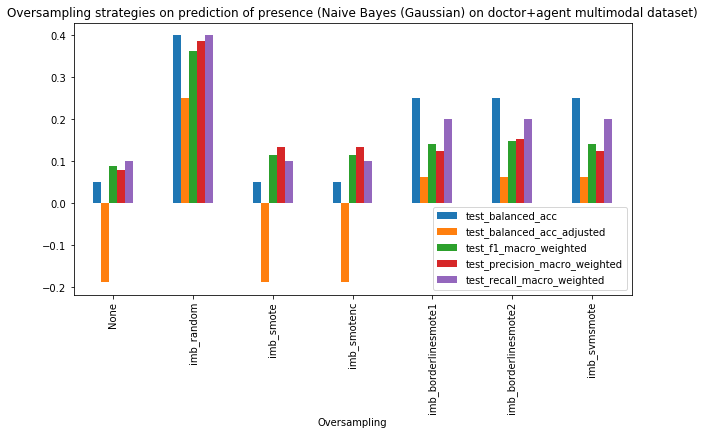

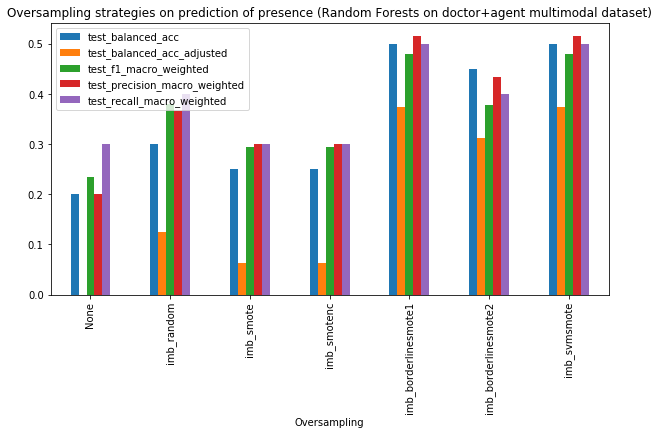

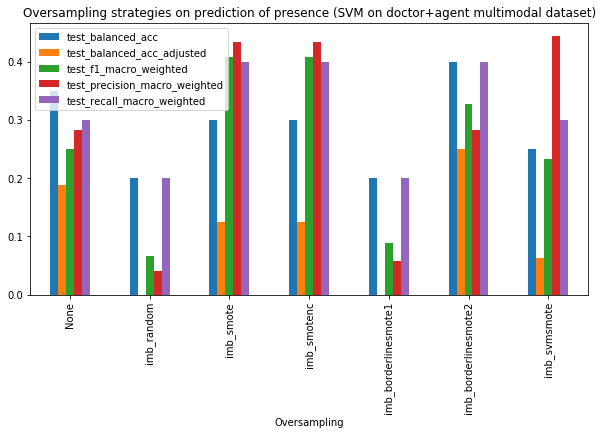

In [260]:
dh_upsampling = DataHandler('upsampling_strategy', 'NB-G', 1)
scores_df = dh_upsampling.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
columns = [col for col in scores_df.columns if 'test_' in col and 'class' not in col]

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'NB-G', :, 'score'][columns] \
    .plot.bar(figsize=(10,5),
              title='Oversampling strategies on prediction of presence (Naive Bayes (Gaussian) on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_NB-G.png'), bbox_inches = "tight")
plt.show()

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'RF', :, 'score'][columns] \
    .plot.bar(figsize=(10,5),
              title='Oversampling strategies on prediction of presence (Random Forests on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_RF.png'), bbox_inches = "tight")
plt.show()

ax = scores_df.loc['Presence', 'Doctor+Agent', 'Multimodal', 'SVM', :, 'score'][columns] \
    .plot.bar(figsize=(10,5),
              title='Oversampling strategies on prediction of presence (SVM on doctor+agent multimodal dataset)')
plt.savefig(os.path.join(dh_upsampling.root_path, 'oversampling_strategies_SVM.png'), bbox_inches = "tight")
plt.show()

## Experiment: Subject and Agent features, phases versus no phase

### Test plan

In [205]:
test_plan_params_phases = {
    'classifier': ['gnb', 'svm', 'forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'prediction_task': ['presence', 'copresence'],
    'phases': ['nophase', '157015']
}

### Run

In [ ]:
dh_phases = run_test_plan(test_plan_params_phases, 'Phases', 'phases', 0)

[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['No Phase', '157015'], ['NB-G', 'SVM', 'RF'], ['score', 'err']]
load_obj: opening C:\IAAA\TER\_output\Phases\phases-0\results\scores.pkl
file does not yet exist C:\IAAA\TER\_output\Phases\phases-0\results\scores.pkl
load_obj: opening C:\IAAA\TER\_output\Phases\phases-0\.\context.pkl
file does not yet exist C:\IAAA\TER\_output\Phases\phases-0\.\context.pkl
36 tests to be performed
{'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
{'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor'}
{'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'agent'}
{'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
{'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor'}
{'phases': 'nophase', 'classifier': 'gnb', 'prediction_task

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.46648604269293925
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.007,0.064,0.301429,0.000000,0.250000,0.285714,0.400000,0.571429,0,0.290000,0.000000,0.200000,0.250000,0.500000,0.500000,0.333333,0.000000,0.333333,0.333333,0.333333,0.666667
1,0.007,0.060,0.466667,0.666667,0.500000,0.333333,0.333333,0.500000,0,0.546667,0.666667,1.000000,0.333333,0.333333,0.400000,0.466667,0.666667,0.333333,0.333333,0.333333,0.666667
2,0.006,0.074,0.303175,0.444444,0.571429,0.000000,0.000000,0.500000,0,0.366667,0.333333,0.500000,0.000000,0.000000,1.000000,0.333333,0.666667,0.666667,0.000000,0.000000,0.333333
3,0.009,0.077,0.360952,0.400000,0.500000,0.571429,0.000000,0.333333,0,0.346667,0.500000,0.400000,0.500000,0.000000,0.333333,0.400000,0.333333,0.666667,0.666667,0.000000,0.333333
4,0.009,0.075,0.361905,0.571429,0.666667,0.000000,0.000000,0.571429,0,0.333333,0.500000,0.666667,0.000000,0.000000,0.500000,0.400000,0.666667,0.666667,0.000000,0.000000,0.666667
5,0.007,0.068,0.647619,0.666667,0.571429,1.000000,0.500000,0.500000,0,0.800000,0.500000,0.500000,1.000000,1.000000,1.000000,0.666667,1.000000,0.666667,1.000000,0.333333,0.333333
6,0.012,0.078,0.396667,0.400000,0.750000,0.333333,0.000000,0.500000,0,0.366667,0.500000,0.600000,0.333333,0.000000,0.400000,0.466667,0.333333,1.000000,0.333333,0.000000,0.666667
7,0.008,0.074,0.414286,0.750000,0.750000,0.000000,0.000000,0.571429,0,0.340000,0.600000,0.600000,0.000000,0.000000,0.500000,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
8,0.007,0.071,0.723333,1.000000,0.750000,0.400000,0.800000,0.666667,0,0.753333,1.000000,0.600000,0.500000,1.000000,0.666667,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
9,0.010,0.075,0.800000,1.000000,0.666667,0.666667,0.666667,1.000000,0,0.900000,1.000000,0.500000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,0.500000,0.500000,1.000000


0    0.267599
1    0.426048
2    0.290431
3    0.320558
4    0.316925
5    0.607653
6    0.355714
7    0.371796
8    0.635143
9    0.718333
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.37600016594 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'No Phase', 'NB-G')
DEBUG inserting new columns set(['val_precision_macro', 'test_recall_macro_weighted', 'fit_time', 'test_precision_macro_weighted', 'test_balanced_acc', 'val_recall_macro_class_2', 'val_recall_macro_class_3', 'val_recall_macro_class_0', 'val_recall_macro_class_1', 'val_f1_macro', 'val_recall_macro_class_4', 'test_balanced_acc_adjusted', 'test_f1_macro_weighted', 'val_recall_macro', 'test_recall_macro_class_4', 'test_recall_macro_class_0', 'test_recall_macro_class_1', 'test_recall_macro_class_2', 'test_recall_macro_class_3', 'val_f1_macro_class_2', 'val_f1_macro_class_3', 'val_f1_macro_class_0', 'val_f1_macro_class_1', 'val_f1_macro_class_4', 'test_precision_macro_class_4', 'test_precision_macro_c

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.35793103448275865
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.008,0.065,0.263333,0.000000,0.250000,0.0,0.666667,0.400000,0,0.230476,0.000000,0.200000,0.0,0.666667,0.285714,0.333333,0.000000,0.333333,0.000000,0.666667,0.666667
1,0.007,0.062,0.188889,0.000000,0.500000,0.0,0.000000,0.444444,0,0.266667,0.000000,1.000000,0.0,0.000000,0.333333,0.200000,0.000000,0.333333,0.000000,0.000000,0.666667
2,0.008,0.081,0.180952,0.000000,0.571429,0.0,0.000000,0.333333,0,0.166667,0.000000,0.500000,0.0,0.000000,0.333333,0.200000,0.000000,0.666667,0.000000,0.000000,0.333333
3,0.010,0.081,0.370476,0.400000,0.285714,0.5,0.000000,0.666667,0,0.363333,0.500000,0.250000,0.4,0.000000,0.666667,0.400000,0.333333,0.333333,0.666667,0.000000,0.666667
4,0.009,0.079,0.380000,0.333333,0.666667,0.0,0.400000,0.500000,0,0.380000,0.333333,0.666667,0.0,0.500000,0.400000,0.400000,0.333333,0.666667,0.000000,0.333333,0.666667
5,0.008,0.082,0.460952,0.500000,0.571429,0.4,0.500000,0.333333,0,0.546667,0.400000,0.500000,0.5,1.000000,0.333333,0.466667,0.666667,0.666667,0.333333,0.333333,0.333333
6,0.009,0.082,0.236667,0.250000,0.600000,0.0,0.000000,0.333333,0,0.192381,0.200000,0.428571,0.0,0.000000,0.333333,0.333333,0.333333,1.000000,0.000000,0.000000,0.333333
7,0.009,0.070,0.383333,0.666667,0.750000,0.0,0.000000,0.500000,0,0.333333,0.666667,0.600000,0.0,0.000000,0.400000,0.466667,0.666667,1.000000,0.000000,0.000000,0.666667
8,0.008,0.062,0.577619,0.666667,0.750000,0.5,0.400000,0.571429,0,0.653333,0.666667,0.600000,1.0,0.500000,0.500000,0.600000,0.666667,1.000000,0.333333,0.333333,0.666667
9,0.008,0.061,0.626667,0.800000,0.666667,0.0,0.666667,1.000000,0,0.633333,0.666667,0.500000,0.0,1.000000,1.000000,0.700000,1.000000,1.000000,0.000000,0.500000,1.000000


0    0.239803
1    0.190587
2    0.160701
3    0.328279
4    0.335619
5    0.425510
6    0.222156
7    0.341857
8    0.526463
9    0.563286
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.41499996185 seconds
      updating scores for ('Presence', 'Doctor', 'No Phase', 'NB-G')
DEBUG inserting new columns set([])
Test 2 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 29, 2.0: 25, 4.0: 14, 1.0: 11, 0.0: 7}) / unique 86
prepare_train_data: Resampled data 145 / Counter({0.0: 29, 1.0: 29, 2.0: 29, 3.0: 29, 4.0: 29}) / u

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.403431855500821
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.040,0.304444,0.000000,0.222222,0.400000,0.400000,0.500000,0,0.313333,0.000000,0.166667,0.500000,0.5,0.400000,0.333333,0.000000,0.333333,0.333333,0.333333,0.666667
1,0.003,0.032,0.283175,0.444444,0.000000,0.571429,0.000000,0.400000,0,0.266667,0.333333,0.000000,0.500000,0.0,0.500000,0.333333,0.666667,0.000000,0.666667,0.000000,0.333333
2,0.004,0.032,0.343333,0.250000,0.666667,0.400000,0.000000,0.400000,0,0.373333,0.200000,0.666667,0.500000,0.0,0.500000,0.333333,0.333333,0.666667,0.333333,0.000000,0.333333
3,0.004,0.034,0.342857,0.571429,0.571429,0.571429,0.000000,0.000000,0,0.300000,0.500000,0.500000,0.500000,0.0,0.000000,0.400000,0.666667,0.666667,0.666667,0.000000,0.000000
4,0.004,0.050,0.114286,0.285714,0.000000,0.000000,0.000000,0.285714,0,0.100000,0.250000,0.000000,0.000000,0.0,0.250000,0.133333,0.333333,0.000000,0.000000,0.000000,0.333333
5,0.005,0.045,0.667619,0.666667,0.571429,0.800000,0.800000,0.500000,0,0.800000,0.500000,0.500000,1.000000,1.0,1.000000,0.666667,1.000000,0.666667,0.666667,0.666667,0.333333
6,0.005,0.049,0.396667,0.400000,0.750000,0.333333,0.000000,0.500000,0,0.366667,0.500000,0.600000,0.333333,0.0,0.400000,0.466667,0.333333,1.000000,0.333333,0.000000,0.666667
7,0.007,0.050,0.327619,0.666667,0.571429,0.000000,0.000000,0.400000,0,0.300000,0.500000,0.500000,0.000000,0.0,0.500000,0.400000,1.000000,0.666667,0.000000,0.000000,0.333333
8,0.006,0.047,0.657619,0.800000,0.750000,0.571429,0.500000,0.666667,0,0.753333,1.000000,0.600000,0.500000,1.0,0.666667,0.666667,0.666667,1.000000,0.666667,0.333333,0.666667
9,0.005,0.044,0.693333,0.666667,0.800000,0.666667,0.666667,0.666667,0,0.833333,1.000000,0.666667,0.500000,1.0,1.000000,0.700000,0.500000,1.000000,1.000000,0.500000,0.500000


0    0.273937
1    0.254002
2    0.301714
3    0.299769
4    0.101891
5    0.612177
6    0.354000
7    0.296320
8    0.596129
9    0.638524
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.811000108719 seconds
      updating scores for ('Presence', 'Agent', 'No Phase', 'NB-G')
DEBUG inserting new columns set([])
Test 3 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 32, 2.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.40858752358752365
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.069,0.203419,0.333333,0.222222,0.000000,0.461538,0.000000,0,0.206667,0.500000,0.200000,0.000000,0.333333,0.000000,0.250000,0.250000,0.250000,0.000000,0.750000,0.000000
1,0.009,0.086,0.432900,0.545455,0.285714,0.000000,0.666667,0.666667,0,0.472381,0.428571,0.333333,0.000000,0.600000,1.000000,0.450000,0.750000,0.250000,0.000000,0.750000,0.500000
2,0.011,0.092,0.316667,0.666667,0.000000,0.250000,0.000000,0.666667,0,0.273333,0.666667,0.000000,0.200000,0.000000,0.500000,0.400000,0.666667,0.000000,0.333333,0.000000,1.000000
3,0.009,0.082,0.535238,0.571429,0.333333,0.400000,0.800000,0.571429,0,0.566667,0.500000,0.333333,0.500000,1.000000,0.500000,0.533333,0.666667,0.333333,0.333333,0.666667,0.666667
4,0.008,0.081,0.380952,0.571429,0.666667,0.000000,0.000000,0.666667,0,0.366667,0.500000,0.666667,0.000000,0.000000,0.666667,0.400000,0.666667,0.666667,0.000000,0.000000,0.666667
5,0.007,0.059,0.211111,0.500000,0.333333,0.222222,0.000000,0.000000,0,0.180000,0.400000,0.333333,0.166667,0.000000,0.000000,0.266667,0.666667,0.333333,0.333333,0.000000,0.000000
6,0.007,0.059,0.674286,0.800000,0.571429,0.500000,0.500000,1.000000,0,0.780000,1.000000,0.500000,0.400000,1.000000,1.000000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
7,0.007,0.075,0.504444,0.666667,0.333333,0.222222,0.500000,0.800000,0,0.633333,0.666667,0.333333,0.166667,1.000000,1.000000,0.466667,0.666667,0.333333,0.333333,0.333333,0.666667
8,0.010,0.080,0.364286,0.500000,0.571429,0.250000,0.500000,0.000000,0,0.420000,0.400000,0.500000,0.200000,1.000000,0.000000,0.400000,0.666667,0.666667,0.333333,0.333333,0.000000
9,0.007,0.081,0.522857,0.285714,0.857143,0.400000,0.500000,0.571429,0,0.600000,0.250000,0.750000,0.500000,1.000000,0.500000,0.533333,0.333333,1.000000,0.333333,0.333333,0.666667


0    0.192167
1    0.391747
2    0.287762
3    0.471544
4    0.332129
5    0.191079
6    0.609129
7    0.462317
8    0.342653
9    0.477388
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.45700001717 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'No Phase', 'NB-G')
DEBUG inserting new columns set([])
Test 4 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 32, 2.0: 24, 1.0: 15, 4.0: 9, 0.0: 6}) / unique 86
prepare_train_data: Resampled data 160 / Counter({0.0: 32, 1.0: 32, 2.0: 32, 3.0: 32, 4.0: 32}) / unique 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.3914488636363636
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.061,0.196667,0.333333,0.250000,0.000000,0.400000,0.000000,0,0.204545,0.500000,0.250000,0.000000,0.272727,0.000000,0.250000,0.250000,0.250000,0.000000,0.750000,0.000000
1,0.006,0.071,0.360519,0.545455,0.285714,0.000000,0.400000,0.571429,0,0.352381,0.428571,0.333333,0.000000,0.333333,0.666667,0.400000,0.750000,0.250000,0.000000,0.500000,0.500000
2,0.008,0.084,0.504762,1.000000,0.000000,0.333333,0.333333,0.857143,0,0.483333,1.000000,0.000000,0.333333,0.333333,0.750000,0.533333,1.000000,0.000000,0.333333,0.333333,1.000000
3,0.009,0.080,0.607619,0.571429,0.500000,0.500000,0.800000,0.666667,0,0.713333,0.500000,0.400000,1.000000,1.000000,0.666667,0.600000,0.666667,0.666667,0.333333,0.666667,0.666667
4,0.012,0.080,0.294286,0.500000,0.571429,0.000000,0.000000,0.400000,0,0.280000,0.400000,0.500000,0.000000,0.000000,0.500000,0.333333,0.666667,0.666667,0.000000,0.000000,0.333333
5,0.008,0.071,0.166667,0.250000,0.250000,0.333333,0.000000,0.000000,0,0.146667,0.200000,0.200000,0.333333,0.000000,0.000000,0.200000,0.333333,0.333333,0.333333,0.000000,0.000000
6,0.008,0.066,0.504762,0.666667,0.571429,0.285714,0.000000,1.000000,0,0.483333,0.666667,0.500000,0.250000,0.000000,1.000000,0.533333,0.666667,0.666667,0.333333,0.000000,1.000000
7,0.008,0.062,0.548889,0.666667,0.444444,0.333333,0.500000,0.800000,0,0.666667,0.666667,0.333333,0.333333,1.000000,1.000000,0.533333,0.666667,0.666667,0.333333,0.333333,0.666667
8,0.006,0.057,0.472222,0.444444,0.750000,0.666667,0.500000,0.000000,0,0.520000,0.333333,0.600000,0.666667,1.000000,0.000000,0.533333,0.666667,1.000000,0.666667,0.333333,0.000000
9,0.007,0.056,0.333333,0.000000,0.500000,0.333333,0.500000,0.333333,0,0.413333,0.000000,0.400000,0.333333,1.000000,0.333333,0.333333,0.000000,0.666667,0.333333,0.333333,0.333333


0    0.189251
1    0.321638
2    0.439075
3    0.553082
4    0.263701
5    0.150429
6    0.438218
7    0.503016
8    0.438873
9    0.311571
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.31500005722 seconds
      updating scores for ('Co-Presence', 'Doctor', 'No Phase', 'NB-G')
DEBUG inserting new columns set([])
Test 5 : {'phases': 'nophase', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 32, 2.0: 24, 1.0: 15, 4.0: 9, 0.0: 6}) / unique 86
prepare_train_data: Resampled data 160 / Counter({0.0: 32, 1.0: 32, 2.0: 32, 3.0: 32, 4.0: 32

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


  Gridsearch evaluated best score 0.3701573773448773


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.005,0.044,0.122727,0.250000,0.363636,0.000000,0.000000,0.000000,0,0.107143,0.250000,0.285714,0.000000,0.000000,0.00,0.150000,0.250000,0.500000,0.000000,0.000000,0.000000
1,0.005,0.037,0.543651,0.750000,0.444444,0.285714,0.571429,0.666667,0,0.550000,0.750000,0.400000,0.333333,0.666667,0.60,0.550000,0.750000,0.500000,0.250000,0.500000,0.750000
2,0.005,0.035,0.355556,0.666667,0.000000,0.444444,0.000000,0.666667,0,0.300000,0.666667,0.000000,0.333333,0.000000,0.50,0.466667,0.666667,0.000000,0.666667,0.000000,1.000000
3,0.004,0.034,0.400000,0.666667,0.000000,0.333333,0.500000,0.500000,0,0.446667,0.500000,0.000000,0.333333,1.000000,0.40,0.466667,1.000000,0.000000,0.333333,0.333333,0.666667
4,0.005,0.040,0.350000,0.750000,0.000000,0.000000,0.000000,1.000000,0,0.320000,0.600000,0.000000,0.000000,0.000000,1.00,0.400000,1.000000,0.000000,0.000000,0.000000,1.000000
5,0.006,0.043,0.216667,0.500000,0.333333,0.250000,0.000000,0.000000,0,0.186667,0.400000,0.333333,0.200000,0.000000,0.00,0.266667,0.666667,0.333333,0.333333,0.000000,0.000000
6,0.005,0.035,0.592381,0.571429,0.400000,0.333333,0.800000,0.857143,0,0.616667,0.500000,0.500000,0.333333,1.000000,0.75,0.600000,0.666667,0.333333,0.333333,0.666667,1.000000
7,0.005,0.044,0.346667,0.333333,0.400000,0.500000,0.000000,0.500000,0,0.326667,0.333333,0.500000,0.400000,0.000000,0.40,0.400000,0.333333,0.333333,0.666667,0.000000,0.666667
8,0.005,0.045,0.173810,0.285714,0.333333,0.250000,0.000000,0.000000,0,0.156667,0.250000,0.333333,0.200000,0.000000,0.00,0.200000,0.333333,0.333333,0.333333,0.000000,0.000000
9,0.004,0.040,0.624762,0.285714,0.800000,0.666667,0.800000,0.571429,0,0.683333,0.250000,1.000000,0.666667,1.000000,0.50,0.600000,0.333333,0.666667,0.666667,0.666667,0.666667


0    0.110868
1    0.471615
2    0.322540
3    0.377048
4    0.307857
5    0.193762
6    0.518776
7    0.309000
8    0.153946
9    0.547265
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.749000072479 seconds
      updating scores for ('Co-Presence', 'Agent', 'No Phase', 'NB-G')
DEBUG inserting new columns set([])
Test 6 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntro

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5002507836990595
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.054,0.544286,1.000000,0.750000,0.0,0.571429,0.400000,0,0.520000,1.000000,0.600000,0.0,0.50,0.500000,0.600000,1.000000,1.000000,0.000000,0.666667,0.333333
1,0.006,0.055,0.290476,0.333333,0.500000,0.0,0.285714,0.333333,0,0.263333,0.333333,0.400000,0.0,0.25,0.333333,0.333333,0.333333,0.666667,0.000000,0.333333,0.333333
2,0.007,0.065,0.247619,0.571429,0.666667,0.0,0.000000,0.000000,0,0.200000,0.500000,0.500000,0.0,0.00,0.000000,0.333333,0.666667,1.000000,0.000000,0.000000,0.000000
3,0.007,0.072,0.409091,0.500000,0.545455,0.5,0.000000,0.500000,0,0.555000,0.400000,0.375000,1.0,0.00,1.000000,0.466667,0.666667,1.000000,0.333333,0.000000,0.333333
4,0.006,0.070,0.451429,0.857143,0.600000,0.4,0.000000,0.400000,0,0.435714,0.750000,0.428571,0.5,0.00,0.500000,0.533333,1.000000,1.000000,0.333333,0.000000,0.333333
5,0.009,0.079,0.564762,0.857143,0.666667,0.4,0.500000,0.400000,0,0.650000,0.750000,0.500000,0.5,1.00,0.500000,0.600000,1.000000,1.000000,0.333333,0.333333,0.333333
6,0.010,0.080,0.590000,0.500000,0.750000,0.8,0.500000,0.400000,0,0.700000,0.400000,0.600000,1.0,1.00,0.500000,0.600000,0.666667,1.000000,0.666667,0.333333,0.333333
7,0.009,0.085,0.524762,0.600000,0.857143,0.5,0.000000,0.666667,0,0.569048,0.428571,0.750000,1.0,0.00,0.666667,0.600000,1.000000,1.000000,0.333333,0.000000,0.666667
8,0.008,0.079,0.733333,1.000000,0.666667,0.4,0.800000,0.800000,0,0.800000,1.000000,0.500000,0.5,1.00,1.000000,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
9,0.008,0.081,0.720000,1.000000,0.800000,1.0,0.000000,0.800000,0,0.666667,1.000000,0.666667,1.0,0.00,0.666667,0.800000,1.000000,1.000000,1.000000,0.000000,1.000000


0    0.478367
1    0.256374
2    0.226558
3    0.412550
4    0.409469
5    0.522694
6    0.544286
7    0.488422
8    0.651762
9    0.629000
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.32199978828 seconds
      updating scores for ('Presence', 'Doctor+Agent', '157015', 'NB-G')
DEBUG inserting new columns set([])
Test 7 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
pr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5760262725779967
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.007,0.061,0.414286,0.666667,0.500000,0.285714,0.285714,0.333333,0,0.500000,0.666667,1.000000,0.250000,0.250000,0.333333,0.400000,0.666667,0.333333,0.333333,0.333333,0.333333
1,0.006,0.057,0.306667,0.333333,0.800000,0.000000,0.000000,0.400000,0,0.323810,0.333333,1.000000,0.000000,0.000000,0.285714,0.333333,0.333333,0.666667,0.000000,0.000000,0.666667
2,0.007,0.072,0.333333,0.400000,0.666667,0.400000,0.200000,0.000000,0,0.361905,0.500000,0.666667,0.500000,0.142857,0.000000,0.333333,0.333333,0.666667,0.333333,0.333333,0.000000
3,0.007,0.068,0.588571,0.571429,0.571429,0.800000,0.000000,1.000000,0,0.600000,0.500000,0.500000,1.000000,0.000000,1.000000,0.600000,0.666667,0.666667,0.666667,0.000000,1.000000
4,0.006,0.055,0.731429,1.000000,0.666667,0.333333,0.800000,0.857143,0,0.750000,1.000000,0.666667,0.333333,1.000000,0.750000,0.733333,1.000000,0.666667,0.333333,0.666667,1.000000
5,0.007,0.058,0.613333,0.800000,1.000000,0.666667,0.000000,0.600000,0,0.619048,1.000000,1.000000,0.666667,0.000000,0.428571,0.666667,0.666667,1.000000,0.666667,0.000000,1.000000
6,0.006,0.058,0.600000,0.666667,1.000000,0.666667,0.000000,0.666667,0,0.566667,0.666667,1.000000,0.666667,0.000000,0.500000,0.666667,0.666667,1.000000,0.666667,0.000000,1.000000
7,0.007,0.072,0.680000,1.000000,1.000000,0.800000,0.000000,0.600000,0,0.685714,1.000000,1.000000,1.000000,0.000000,0.428571,0.733333,1.000000,1.000000,0.666667,0.000000,1.000000
8,0.010,0.080,0.776190,0.857143,1.000000,0.666667,0.500000,0.857143,0,0.833333,0.750000,1.000000,0.666667,1.000000,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
9,0.008,0.083,0.786667,1.000000,0.800000,0.666667,0.666667,0.800000,0,0.866667,1.000000,0.666667,1.000000,1.000000,0.666667,0.800000,1.000000,1.000000,0.500000,0.500000,1.000000


0    0.378748
1    0.278374
2    0.297639
3    0.514592
4    0.635694
5    0.545680
6    0.526857
7    0.603490
8    0.692721
9    0.705286
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.33100008965 seconds
      updating scores for ('Presence', 'Doctor', '157015', 'NB-G')
DEBUG inserting new columns set([])
Test 8 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


  Gridsearch evaluated best score 0.3464576802507837


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.006,0.045,0.409091,0.500000,0.545455,0.000000,0.500000,0.5,0,0.555000,0.400000,0.375000,0.0,1.000000,1.0,0.466667,0.666667,1.000000,0.000000,0.333333,0.333333
1,0.006,0.042,0.305556,0.250000,0.444444,0.000000,0.333333,0.5,0,0.373333,0.200000,0.333333,0.0,0.333333,1.0,0.333333,0.333333,0.666667,0.000000,0.333333,0.333333
2,0.005,0.035,0.157143,0.285714,0.500000,0.000000,0.000000,0.0,0,0.130000,0.250000,0.400000,0.0,0.000000,0.0,0.200000,0.333333,0.666667,0.000000,0.000000,0.000000
3,0.004,0.036,0.260000,0.400000,0.400000,0.500000,0.000000,0.0,0,0.314286,0.285714,0.285714,1.0,0.000000,0.0,0.333333,0.666667,0.666667,0.333333,0.000000,0.000000
4,0.004,0.042,0.333333,0.600000,0.666667,0.400000,0.000000,0.0,0,0.285714,0.428571,0.500000,0.5,0.000000,0.0,0.466667,1.000000,1.000000,0.333333,0.000000,0.000000
5,0.005,0.041,0.333333,0.600000,0.666667,0.400000,0.000000,0.0,0,0.285714,0.428571,0.500000,0.5,0.000000,0.0,0.466667,1.000000,1.000000,0.333333,0.000000,0.000000
6,0.005,0.035,0.400000,0.500000,0.600000,0.000000,0.500000,0.4,0,0.465714,0.400000,0.428571,0.0,1.000000,0.5,0.466667,0.666667,1.000000,0.000000,0.333333,0.333333
7,0.004,0.036,0.353333,0.600000,0.666667,0.000000,0.000000,0.5,0,0.385714,0.428571,0.500000,0.0,0.000000,1.0,0.466667,1.000000,1.000000,0.000000,0.000000,0.333333
8,0.004,0.036,0.543333,0.750000,0.666667,0.000000,0.500000,0.8,0,0.620000,0.600000,0.500000,0.0,1.000000,1.0,0.600000,1.000000,1.000000,0.000000,0.333333,0.666667
9,0.004,0.036,0.380952,0.571429,0.666667,0.666667,0.000000,0.0,0,0.380000,0.400000,0.500000,1.0,0.000000,0.0,0.500000,1.000000,1.000000,0.500000,0.000000,0.000000


0    0.411216
1    0.291492
2    0.141088
3    0.261224
4    0.312395
5    0.312395
6    0.382585
7    0.346395
8    0.505714
9    0.362177
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.728000164032 seconds
      updating scores for ('Presence', 'Agent', '157015', 'NB-G')
DEBUG inserting new columns set([])
Test 9 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntrop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6027983821733822
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.007,0.059,0.405641,0.666667,0.250000,0.250000,0.461538,0.400000,0,0.566667,1.000000,0.250000,0.250000,0.333333,1.00,0.400000,0.500000,0.250000,0.250000,0.750000,0.250000
1,0.007,0.058,0.623651,0.750000,0.857143,0.444444,0.400000,0.666667,0,0.696667,0.750000,1.000000,0.400000,0.333333,1.00,0.600000,0.750000,0.750000,0.500000,0.500000,0.500000
2,0.007,0.064,0.448889,1.000000,0.000000,0.000000,0.444444,0.800000,0,0.466667,1.000000,0.000000,0.000000,0.333333,1.00,0.466667,1.000000,0.000000,0.000000,0.666667,0.666667
3,0.008,0.069,0.723333,0.750000,0.666667,0.400000,0.800000,1.000000,0,0.753333,0.600000,0.666667,0.500000,1.000000,1.00,0.733333,1.000000,0.666667,0.333333,0.666667,1.000000
4,0.007,0.059,0.518095,1.000000,0.400000,0.000000,0.333333,0.857143,0,0.516667,1.000000,0.500000,0.000000,0.333333,0.75,0.533333,1.000000,0.333333,0.000000,0.333333,1.000000
5,0.006,0.059,0.716667,0.750000,0.666667,0.666667,0.500000,1.000000,0,0.786667,0.600000,0.666667,0.666667,1.000000,1.00,0.733333,1.000000,0.666667,0.666667,0.333333,1.000000
6,0.007,0.058,0.796190,0.857143,0.857143,0.666667,0.800000,0.800000,0,0.833333,0.750000,0.750000,0.666667,1.000000,1.00,0.800000,1.000000,1.000000,0.666667,0.666667,0.666667
7,0.007,0.057,0.670476,1.000000,0.666667,0.285714,0.400000,1.000000,0,0.683333,1.000000,0.666667,0.250000,0.500000,1.00,0.666667,1.000000,0.666667,0.333333,0.333333,1.000000
8,0.007,0.076,0.590476,0.666667,0.857143,0.571429,0.000000,0.857143,0,0.533333,0.666667,0.750000,0.500000,0.000000,0.75,0.666667,0.666667,1.000000,0.666667,0.000000,1.000000
9,0.009,0.082,0.593333,0.750000,0.750000,0.000000,0.666667,0.800000,0,0.573333,0.600000,0.600000,0.000000,0.666667,1.00,0.666667,1.000000,1.000000,0.000000,0.666667,0.666667


0    0.395231
1    0.551757
2    0.398302
3    0.635095
4    0.451170
5    0.642143
6    0.697245
7    0.580327
8    0.515517
9    0.528143
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.2349998951 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', '157015', 'NB-G')
DEBUG inserting new columns set([])
Test 10 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6013095238095238
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.007,0.059,0.343333,0.666667,0.250000,0.000000,0.400000,0.400000,0,0.504545,1.00,0.250000,0.00,0.272727,1.00,0.350000,0.50,0.250000,0.000000,0.750000,0.250000
1,0.007,0.058,0.712857,0.750000,0.857143,0.600000,0.500000,0.857143,0,0.750000,0.75,1.000000,0.50,0.500000,1.00,0.700000,0.75,0.750000,0.750000,0.500000,0.750000
2,0.007,0.066,0.504762,1.000000,0.000000,0.000000,0.666667,0.857143,0,0.483333,1.00,0.000000,0.00,0.666667,0.75,0.533333,1.00,0.000000,0.000000,0.666667,1.000000
3,0.009,0.081,0.681429,0.750000,1.000000,0.000000,0.800000,0.857143,0,0.670000,0.60,1.000000,0.00,1.000000,0.75,0.733333,1.00,1.000000,0.000000,0.666667,1.000000
4,0.010,0.087,0.518095,1.000000,0.400000,0.000000,0.333333,0.857143,0,0.516667,1.00,0.500000,0.00,0.333333,0.75,0.533333,1.00,0.333333,0.000000,0.333333,1.000000
5,0.009,0.082,0.514286,0.666667,0.333333,0.571429,0.500000,0.500000,0,0.666667,0.50,0.333333,0.50,1.000000,1.00,0.533333,1.00,0.333333,0.666667,0.333333,0.333333
6,0.008,0.079,0.803333,0.750000,0.666667,0.800000,0.800000,1.000000,0,0.853333,0.60,0.666667,1.00,1.000000,1.00,0.800000,1.00,0.666667,0.666667,0.666667,1.000000
7,0.008,0.059,0.661905,0.857143,0.666667,0.285714,0.500000,1.000000,0,0.733333,0.75,0.666667,0.25,1.000000,1.00,0.666667,1.00,0.666667,0.333333,0.333333,1.000000
8,0.007,0.068,0.657143,0.857143,1.000000,0.571429,0.000000,0.857143,0,0.600000,0.75,1.000000,0.50,0.000000,0.75,0.733333,1.00,1.000000,0.666667,0.000000,1.000000
9,0.009,0.078,0.664762,0.666667,0.857143,0.000000,0.800000,1.000000,0,0.650000,0.50,0.750000,0.00,1.000000,1.00,0.733333,1.00,1.000000,0.000000,0.666667,1.000000


0    0.345394
1    0.621054
2    0.438170
3    0.599932
4    0.452646
5    0.494129
6    0.706048
7    0.592306
8    0.572279
9    0.589313
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 1.31399989128 seconds
      updating scores for ('Co-Presence', 'Doctor', '157015', 'NB-G')
DEBUG inserting new columns set([])
Test 11 : {'phases': '157015', 'classifier': 'gnb', 'prediction_task': 'copresence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.512485119047619
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.005,0.045,0.461111,0.666667,0.222222,0.500000,0.250000,0.666667,0,0.510000,1.000000,0.200000,0.500000,0.250000,0.600000,0.450000,0.500000,0.250000,0.500000,0.250000,0.750000
1,0.005,0.046,0.605556,0.750000,0.666667,0.500000,0.666667,0.444444,0,0.650000,0.750000,1.000000,0.500000,0.600000,0.400000,0.600000,0.750000,0.500000,0.500000,0.750000,0.500000
2,0.007,0.048,0.410000,1.000000,0.000000,0.000000,0.250000,0.800000,0,0.440000,1.000000,0.000000,0.000000,0.200000,1.000000,0.400000,1.000000,0.000000,0.000000,0.333333,0.666667
3,0.005,0.055,0.487619,0.571429,0.400000,0.000000,0.800000,0.666667,0,0.500000,0.500000,0.500000,0.000000,1.000000,0.500000,0.533333,0.666667,0.333333,0.000000,0.666667,1.000000
4,0.005,0.044,0.286667,0.333333,0.500000,0.000000,0.000000,0.600000,0,0.352381,0.333333,1.000000,0.000000,0.000000,0.428571,0.333333,0.333333,0.333333,0.000000,0.000000,1.000000
5,0.007,0.044,0.652381,0.571429,0.666667,0.666667,0.500000,0.857143,0,0.716667,0.500000,0.666667,0.666667,1.000000,0.750000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
6,0.005,0.041,0.480000,0.600000,0.333333,0.000000,0.666667,0.800000,0,0.485714,0.428571,0.333333,0.000000,0.666667,1.000000,0.533333,1.000000,0.333333,0.000000,0.666667,0.666667
7,0.004,0.036,0.510000,0.750000,0.400000,0.333333,0.400000,0.666667,0,0.520000,0.600000,0.500000,0.333333,0.500000,0.666667,0.533333,1.000000,0.333333,0.333333,0.333333,0.666667
8,0.006,0.039,0.660000,0.800000,0.666667,0.666667,0.500000,0.666667,0,0.766667,1.000000,0.666667,0.666667,1.000000,0.500000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
9,0.004,0.037,0.557619,0.750000,0.571429,0.000000,0.666667,0.800000,0,0.553333,0.600000,0.500000,0.000000,0.666667,1.000000,0.600000,1.000000,0.666667,0.000000,0.666667,0.666667


0    0.408413
1    0.532587
2    0.359762
3    0.437415
4    0.280156
5    0.584061
6    0.430490
7    0.448571
8    0.600238
9    0.490796
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 0.832000017166 seconds
      updating scores for ('Co-Presence', 'Agent', '157015', 'NB-G')
DEBUG inserting new columns set([])
Test 12 : {'phases': 'nophase', 'classifier': 'svm', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 29, 2.0: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   25.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6753694581280787
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.015,0.059,0.862857,0.857143,0.857143,0.800000,0.800000,1.000000,0,0.900000,0.750000,0.75,1.000000,1.000000,1.000000,0.866667,1.000000,1.000000,0.666667,0.666667,1.000000
1,0.014,0.059,0.739048,0.800000,0.800000,0.666667,0.571429,0.857143,0,0.783333,1.000000,1.00,0.666667,0.500000,0.750000,0.733333,0.666667,0.666667,0.666667,0.666667,1.000000
2,0.014,0.079,0.444286,0.571429,0.750000,0.400000,0.000000,0.500000,0,0.520000,0.500000,0.60,0.500000,0.000000,1.000000,0.466667,0.666667,1.000000,0.333333,0.000000,0.333333
3,0.018,0.071,0.659048,0.857143,0.800000,0.571429,0.400000,0.666667,0,0.683333,0.750000,1.00,0.500000,0.500000,0.666667,0.666667,1.000000,0.666667,0.666667,0.333333,0.666667
4,0.014,0.064,0.661905,1.000000,0.857143,0.500000,0.285714,0.666667,0,0.733333,1.000000,0.75,1.000000,0.250000,0.666667,0.666667,1.000000,1.000000,0.333333,0.333333,0.666667
5,0.016,0.065,0.600000,0.666667,1.000000,0.666667,0.000000,0.666667,0,0.566667,0.666667,1.00,0.666667,0.000000,0.500000,0.666667,0.666667,1.000000,0.666667,0.000000,1.000000
6,0.015,0.064,0.513333,0.750000,0.750000,0.400000,0.000000,0.666667,0,0.473333,0.600000,0.60,0.500000,0.000000,0.666667,0.600000,1.000000,1.000000,0.333333,0.000000,0.666667
7,0.015,0.062,0.781429,0.857143,1.000000,0.750000,0.500000,0.800000,0,0.870000,0.750000,1.00,0.600000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,0.333333,0.666667
8,0.015,0.059,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000,0,0.733333,1.000000,1.00,0.333333,0.333333,1.000000,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
9,0.015,0.059,0.800000,0.666667,1.000000,1.000000,0.666667,0.666667,0,0.900000,0.500000,1.00,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,0.500000,0.500000


0    0.754816
1    0.647966
2    0.413272
3    0.578252
4    0.592830
5    0.527667
6    0.457095
7    0.704075
8    0.632095
9    0.717810
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 26.7479999065 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'No Phase', 'SVM')
DEBUG inserting new columns set([])
Test 13 : {'phases': 'nophase', 'classifier': 'svm', 'prediction_task': 'presence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 29, 2.0: 25, 4.0: 14, 1.0: 11, 0.0: 7}) / unique 86
prepare_train_data: Resampled data 145 / Counter({0.0: 29, 1.0: 29, 2.0: 29, 3.0: 29, 4.0: 29}) / unique 145
gri

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.5678653530377669
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.014,0.059,0.542857,1.0,0.857143,0.571429,0.285714,0.000000,0,0.500000,1.000000,0.75,0.5,0.250000,0.000000,0.600000,1.000000,1.000000,0.666667,0.333333,0.000000
1,0.014,0.059,0.491429,0.5,0.500000,0.000000,0.600000,0.857143,0,0.635714,1.000000,1.00,0.0,0.428571,0.750000,0.533333,0.333333,0.333333,0.000000,1.000000,1.000000
2,0.014,0.078,0.354444,0.8,0.750000,0.000000,0.222222,0.000000,0,0.353333,1.000000,0.60,0.0,0.166667,0.000000,0.400000,0.666667,1.000000,0.000000,0.333333,0.000000
3,0.018,0.069,0.477143,0.8,0.800000,0.000000,0.285714,0.500000,0,0.650000,1.000000,1.00,0.0,0.250000,1.000000,0.400000,0.666667,0.666667,0.000000,0.333333,0.333333
4,0.014,0.058,0.520317,0.5,0.857143,0.000000,0.444444,0.800000,0,0.616667,1.000000,0.75,0.0,0.333333,1.000000,0.533333,0.333333,1.000000,0.000000,0.666667,0.666667
5,0.014,0.059,0.550000,0.5,1.000000,0.250000,0.333333,0.666667,0,0.640000,1.000000,1.00,0.2,0.333333,0.666667,0.533333,0.333333,1.000000,0.333333,0.333333,0.666667
6,0.014,0.058,0.760000,0.6,0.800000,0.800000,0.800000,0.800000,0,0.885714,0.428571,1.00,1.0,1.000000,1.000000,0.733333,1.000000,0.666667,0.666667,0.666667,0.666667
7,0.014,0.058,0.533333,1.0,1.000000,0.000000,0.000000,0.666667,0,0.533333,1.000000,1.00,0.0,0.000000,0.666667,0.533333,1.000000,1.000000,0.000000,0.000000,0.666667
8,0.014,0.057,0.664286,0.8,0.750000,0.400000,0.571429,0.800000,0,0.720000,1.000000,0.60,0.5,0.500000,1.000000,0.666667,0.666667,1.000000,0.333333,0.666667,0.666667
9,0.014,0.058,0.893333,1.0,1.000000,1.000000,0.666667,0.800000,0,0.933333,1.000000,1.00,1.0,1.000000,0.666667,0.900000,1.000000,1.000000,1.000000,0.500000,1.000000


0    0.472864
1    0.477898
2    0.320889
3    0.440469
4    0.480662
5    0.495857
6    0.683156
7    0.460571
8    0.589367
9    0.782476
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 25.5209999084 seconds
      updating scores for ('Presence', 'Doctor', 'No Phase', 'SVM')
DEBUG inserting new columns set([])
Test 14 : {'phases': 'nophase', 'classifier': 'svm', 'prediction_task': 'presence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 29, 2.0: 25, 4.0: 14, 1.0: 11, 0.0: 7}) / unique 86
prepare_train_data: Resampled data 145 / Counter({0.0: 29, 1.0: 29, 2.0: 29, 3.0: 29, 4.0: 29}) / u

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6879340200029855
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.010,0.031,0.700000,0.750000,1.000000,0.500000,0.750000,0.500000,0,0.840000,0.600000,1.00,1.000000,0.600000,1.000000,0.733333,1.000000,1.000000,0.333333,1.000000,0.333333
1,0.010,0.033,0.664762,0.666667,0.800000,0.666667,0.333333,0.857143,0,0.683333,0.666667,1.00,0.666667,0.333333,0.750000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
2,0.011,0.033,0.366061,0.666667,0.800000,0.000000,0.363636,0.000000,0,0.383333,0.666667,1.00,0.000000,0.250000,0.000000,0.400000,0.666667,0.666667,0.000000,0.666667,0.000000
3,0.010,0.035,0.682222,1.000000,0.500000,0.666667,0.444444,0.800000,0,0.800000,1.000000,1.00,0.666667,0.333333,1.000000,0.666667,1.000000,0.333333,0.666667,0.666667,0.666667
4,0.011,0.047,0.619048,1.000000,0.857143,0.000000,0.571429,0.666667,0,0.583333,1.000000,0.75,0.000000,0.500000,0.666667,0.666667,1.000000,1.000000,0.000000,0.666667,0.666667
5,0.013,0.043,0.731429,0.800000,1.000000,0.333333,0.666667,0.857143,0,0.750000,1.000000,1.00,0.333333,0.666667,0.750000,0.733333,0.666667,1.000000,0.333333,0.666667,1.000000
6,0.012,0.033,0.866667,1.000000,1.000000,0.666667,0.666667,1.000000,0,0.866667,1.000000,1.00,0.666667,0.666667,1.000000,0.866667,1.000000,1.000000,0.666667,0.666667,1.000000
7,0.011,0.035,0.683333,0.750000,1.000000,0.000000,0.666667,1.000000,0,0.653333,0.600000,1.00,0.000000,0.666667,1.000000,0.733333,1.000000,1.000000,0.000000,0.666667,1.000000
8,0.011,0.034,0.740952,1.000000,1.000000,0.333333,0.571429,0.800000,0,0.766667,1.000000,1.00,0.333333,0.500000,1.000000,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
9,0.011,0.034,0.893333,0.800000,1.000000,1.000000,1.000000,0.666667,0,0.933333,0.666667,1.00,1.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.500000


0    0.651476
1    0.577694
2    0.330494
3    0.616111
4    0.536776
5    0.635456
6    0.745000
7    0.593619
8    0.642415
9    0.781190
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 18.8539998531 seconds
      updating scores for ('Presence', 'Agent', 'No Phase', 'SVM')
DEBUG inserting new columns set([])
Test 15 : {'phases': 'nophase', 'classifier': 'svm', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 32, 2.0:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   27.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7547253787878788
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.016,0.057,0.566667,1.000000,0.666667,0.0,0.500000,0.666667,0,0.666667,1.00,1.0,0.0,0.333333,1.0,0.600000,1.000000,0.500000,0.000000,1.000000,0.500000
1,0.016,0.057,0.662857,0.857143,0.666667,0.4,0.533333,0.857143,0,0.872727,1.00,1.0,1.0,0.363636,1.0,0.650000,0.750000,0.500000,0.250000,1.000000,0.750000
2,0.015,0.080,0.669091,0.800000,0.500000,0.5,0.545455,1.000000,0,0.875000,1.00,1.0,1.0,0.375000,1.0,0.666667,0.666667,0.333333,0.333333,1.000000,1.000000
3,0.021,0.072,0.931429,1.000000,1.000000,1.0,0.857143,0.800000,0,0.950000,1.00,1.0,1.0,0.750000,1.0,0.933333,1.000000,1.000000,1.000000,1.000000,0.666667
4,0.017,0.070,0.583333,0.500000,0.750000,0.0,0.666667,1.000000,0,0.620000,1.00,0.6,0.0,0.500000,1.0,0.666667,0.333333,1.000000,0.000000,1.000000,1.000000
5,0.017,0.066,0.689091,0.800000,0.800000,0.5,0.545455,0.800000,0,0.875000,1.00,1.0,1.0,0.375000,1.0,0.666667,0.666667,0.666667,0.333333,1.000000,0.666667
6,0.017,0.067,0.793333,0.800000,1.000000,0.5,0.666667,1.000000,0,0.900000,1.00,1.0,1.0,0.500000,1.0,0.800000,0.666667,1.000000,0.333333,1.000000,1.000000
7,0.015,0.067,0.813333,0.800000,1.000000,0.8,0.666667,0.800000,0,0.900000,1.00,1.0,1.0,0.500000,1.0,0.800000,0.666667,1.000000,0.666667,1.000000,0.666667
8,0.017,0.066,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0,1.000000,1.00,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.017,0.066,0.931429,0.857143,1.000000,1.0,0.800000,1.000000,0,0.950000,0.75,1.0,1.0,1.000000,1.0,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000


0    0.527286
1    0.627929
2    0.636169
3    0.808646
4    0.538429
5    0.641312
6    0.716381
7    0.722000
8    0.861095
9    0.808170
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 28.2330000401 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'No Phase', 'SVM')
DEBUG inserting new columns set([])
Test 16 : {'phases': 'nophase', 'classifier': 'svm', 'prediction_task': 'copresence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 32, 2.0: 24, 1.0: 15, 4.0: 9, 0.0: 6}) / unique 86
prepare_train_data: Resampled data 160 / Counter({0.0: 32, 1.0: 32, 2.0: 32, 3.0: 32, 4.0: 32}) / unique 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   26.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7371930846930846
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.015,0.055,0.522650,0.888889,0.750000,0.000000,0.307692,0.666667,0,0.554444,0.80,0.75,0.000000,0.222222,1.00,0.550000,1.000000,0.750000,0.000000,0.500000,0.500000
1,0.014,0.055,0.695934,0.857143,0.750000,0.400000,0.615385,0.857143,0,0.838889,1.00,0.75,1.000000,0.444444,1.00,0.700000,0.750000,0.750000,0.250000,1.000000,0.750000
2,0.014,0.067,0.669091,0.800000,0.500000,0.500000,0.545455,1.000000,0,0.875000,1.00,1.00,1.000000,0.375000,1.00,0.666667,0.666667,0.333333,0.333333,1.000000,1.000000
3,0.018,0.063,0.660000,1.000000,0.800000,0.666667,0.333333,0.500000,0,0.766667,1.00,1.00,0.500000,0.333333,1.00,0.666667,1.000000,0.666667,1.000000,0.333333,0.333333
4,0.015,0.058,0.782857,0.800000,1.000000,0.400000,0.857143,0.857143,0,0.800000,1.00,1.00,0.500000,0.750000,0.75,0.800000,0.666667,1.000000,0.333333,1.000000,1.000000
5,0.015,0.058,0.805714,1.000000,0.857143,0.571429,0.800000,0.800000,0,0.850000,1.00,0.75,0.500000,1.000000,1.00,0.800000,1.000000,1.000000,0.666667,0.666667,0.666667
6,0.014,0.058,0.656667,0.800000,0.400000,0.333333,0.750000,1.000000,0,0.686667,1.00,0.50,0.333333,0.600000,1.00,0.666667,0.666667,0.333333,0.333333,1.000000,1.000000
7,0.015,0.057,0.870000,1.000000,0.750000,0.800000,0.800000,1.000000,0,0.920000,1.00,0.60,1.000000,1.000000,1.00,0.866667,1.000000,1.000000,0.666667,0.666667,1.000000
8,0.015,0.058,0.931429,1.000000,1.000000,1.000000,0.800000,0.857143,0,0.950000,1.00,1.00,1.000000,1.000000,0.75,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000
9,0.015,0.056,0.862857,0.857143,0.800000,0.857143,0.800000,1.000000,0,0.900000,0.75,1.00,0.750000,1.000000,1.00,0.866667,1.000000,0.666667,1.000000,0.666667,1.000000


0    0.468217
1    0.641807
2    0.635502
3    0.601952
4    0.684293
5    0.705109
6    0.577714
7    0.762476
8    0.807694
9    0.754673
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 27.0320000648 seconds
      updating scores for ('Co-Presence', 'Doctor', 'No Phase', 'SVM')
DEBUG inserting new columns set([])
Test 17 : {'phases': 'nophase', 'classifier': 'svm', 'prediction_task': 'copresence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 32, 2.0: 24, 1.0: 15, 4.0: 9, 0.0: 6}) / unique 86
prepare_train_data: Resampled data 160 / Counter({0.0: 32, 1.0: 32, 2.0: 32, 3.0: 32, 4.0: 32

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   19.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7329067460317461
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.012,0.035,0.654762,1.000000,0.750000,0.000000,0.666667,0.857143,0,0.650000,1.000000,0.750000,0.000000,0.500000,1.000000,0.700000,1.000000,0.750000,0.000000,1.000000,0.750000
1,0.012,0.038,0.620635,0.888889,0.857143,0.000000,0.500000,0.857143,0,0.635000,0.800000,1.000000,0.000000,0.375000,1.000000,0.650000,1.000000,0.750000,0.000000,0.750000,0.750000
2,0.012,0.035,0.548095,0.800000,0.500000,0.333333,0.250000,0.857143,0,0.656667,1.000000,1.000000,0.333333,0.200000,0.750000,0.533333,0.666667,0.333333,0.333333,0.333333,1.000000
3,0.012,0.044,0.790000,1.000000,1.000000,0.750000,0.400000,0.800000,0,0.820000,1.000000,1.000000,0.600000,0.500000,1.000000,0.800000,1.000000,1.000000,1.000000,0.333333,0.666667
4,0.018,0.047,0.659048,0.800000,0.571429,0.400000,0.666667,0.857143,0,0.683333,1.000000,0.500000,0.500000,0.666667,0.750000,0.666667,0.666667,0.666667,0.333333,0.666667,1.000000
5,0.016,0.036,0.664762,0.800000,0.857143,0.666667,0.333333,0.666667,0,0.683333,1.000000,0.750000,0.666667,0.333333,0.666667,0.666667,0.666667,1.000000,0.666667,0.333333,0.666667
6,0.013,0.038,0.660952,0.666667,0.666667,0.571429,0.400000,1.000000,0,0.666667,0.666667,0.666667,0.500000,0.500000,1.000000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
7,0.012,0.037,0.931429,1.000000,1.000000,0.857143,0.800000,1.000000,0,0.950000,1.000000,1.000000,0.750000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000
8,0.014,0.037,0.931429,1.000000,1.000000,0.857143,0.800000,1.000000,0,0.950000,1.000000,1.000000,0.750000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000
9,0.014,0.036,0.931429,0.857143,1.000000,1.000000,0.800000,1.000000,0,0.950000,0.750000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000


0    0.575027
1    0.546848
2    0.498837
3    0.691238
4    0.577109
5    0.578122
6    0.572224
7    0.806551
8    0.806646
9    0.806599
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.8739998341 seconds
      updating scores for ('Co-Presence', 'Agent', 'No Phase', 'SVM')
DEBUG inserting new columns set([])
Test 18 : {'phases': '157015', 'classifier': 'svm', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntrop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   27.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.78240621447518
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.017,0.059,0.666667,1.0,1.0,0.333333,0.500000,0.500000,0,0.746667,1.0,1.0,0.333333,0.400000,1.00,0.666667,1.000000,1.000000,0.333333,0.666667,0.333333
1,0.016,0.060,0.540000,0.8,0.5,0.000000,0.400000,1.000000,0,0.657143,1.0,1.0,0.000000,0.285714,1.00,0.533333,0.666667,0.333333,0.000000,0.666667,1.000000
2,0.016,0.077,0.452308,1.0,0.8,0.000000,0.461538,0.000000,0,0.460000,1.0,1.0,0.000000,0.300000,0.00,0.533333,1.000000,0.666667,0.000000,1.000000,0.000000
3,0.020,0.062,0.790000,1.0,0.8,0.400000,0.750000,1.000000,0,0.820000,1.0,1.0,0.500000,0.600000,1.00,0.800000,1.000000,0.666667,0.333333,1.000000,1.000000
4,0.017,0.062,0.870000,1.0,1.0,0.800000,0.750000,0.800000,0,0.920000,1.0,1.0,1.000000,0.600000,1.00,0.866667,1.000000,1.000000,0.666667,1.000000,0.666667
5,0.016,0.058,0.864762,1.0,1.0,0.666667,0.800000,0.857143,0,0.883333,1.0,1.0,0.666667,1.000000,0.75,0.866667,1.000000,1.000000,0.666667,0.666667,1.000000
6,0.016,0.060,0.931429,1.0,1.0,0.800000,0.857143,1.000000,0,0.950000,1.0,1.0,1.000000,0.750000,1.00,0.933333,1.000000,1.000000,0.666667,1.000000,1.000000
7,0.017,0.059,0.850000,1.0,1.0,0.500000,0.750000,1.000000,0,0.920000,1.0,1.0,1.000000,0.600000,1.00,0.866667,1.000000,1.000000,0.333333,1.000000,1.000000
8,0.016,0.058,0.931429,1.0,1.0,0.800000,0.857143,1.000000,0,0.950000,1.0,1.0,1.000000,0.750000,1.00,0.933333,1.000000,1.000000,0.666667,1.000000,1.000000
9,0.017,0.058,1.000000,1.0,1.0,1.000000,1.000000,1.000000,0,1.000000,1.0,1.0,1.000000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


0    0.597905
1    0.498041
2    0.417469
3    0.692476
4    0.762810
5    0.750599
6    0.807837
7    0.756952
8    0.807741
9    0.860714
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 28.2009999752 seconds
      updating scores for ('Presence', 'Doctor+Agent', '157015', 'SVM')
DEBUG inserting new columns set([])
Test 19 : {'phases': '157015', 'classifier': 'svm', 'prediction_task': 'presence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
pr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   25.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.711313628899836
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.015,0.055,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667,0,0.733333,1.00,1.000000,0.333333,0.666667,0.666667,0.733333,1.000000,1.000000,0.333333,0.666667,0.666667
1,0.014,0.060,0.687143,0.800000,0.800000,0.800000,0.285714,0.750000,0,0.770000,1.00,1.000000,1.000000,0.250000,0.600000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
2,0.017,0.071,0.491429,1.000000,0.857143,0.000000,0.600000,0.000000,0,0.435714,1.00,0.750000,0.000000,0.428571,0.000000,0.600000,1.000000,1.000000,0.000000,1.000000,0.000000
3,0.018,0.068,0.619048,0.857143,0.666667,0.571429,0.000000,1.000000,0,0.583333,0.75,0.666667,0.500000,0.000000,1.000000,0.666667,1.000000,0.666667,0.666667,0.000000,1.000000
4,0.015,0.060,0.636190,0.857143,0.857143,0.400000,0.400000,0.666667,0,0.633333,0.75,0.750000,0.500000,0.500000,0.666667,0.666667,1.000000,1.000000,0.333333,0.333333,0.666667
5,0.014,0.060,0.724286,0.800000,1.000000,0.571429,0.500000,0.750000,0,0.820000,1.00,1.000000,0.500000,1.000000,0.600000,0.733333,0.666667,1.000000,0.666667,0.333333,1.000000
6,0.015,0.059,0.776190,1.000000,0.857143,0.666667,0.500000,0.857143,0,0.833333,1.00,0.750000,0.666667,1.000000,0.750000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
7,0.015,0.060,0.681429,0.857143,1.000000,0.800000,0.000000,0.750000,0,0.670000,0.75,1.000000,1.000000,0.000000,0.600000,0.733333,1.000000,1.000000,0.666667,0.000000,1.000000
8,0.016,0.067,0.931429,1.000000,1.000000,0.857143,0.800000,1.000000,0,0.950000,1.00,1.000000,0.750000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000
9,0.015,0.060,0.893333,1.000000,1.000000,1.000000,0.666667,0.800000,0,0.933333,1.00,1.000000,1.000000,1.000000,0.666667,0.900000,1.000000,1.000000,1.000000,0.500000,1.000000


0    0.631905
1    0.610327
2    0.440517
3    0.538109
4    0.556769
5    0.654272
6    0.691959
7    0.599218
8    0.808170
9    0.782619
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 26.9639999866 seconds
      updating scores for ('Presence', 'Doctor', '157015', 'SVM')
DEBUG inserting new columns set([])
Test 20 : {'phases': '157015', 'classifier': 'svm', 'prediction_task': 'presence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   19.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7077504105090312
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.012,0.032,0.660952,1.000000,1.000000,0.571429,0.333333,0.400000,0,0.666667,1.00,1.000000,0.500000,0.333333,0.50,0.666667,1.000000,1.000000,0.666667,0.333333,0.333333
1,0.013,0.033,0.535238,0.800000,0.400000,0.333333,0.285714,0.857143,0,0.566667,1.00,0.500000,0.333333,0.250000,0.75,0.533333,0.666667,0.333333,0.333333,0.333333,1.000000
2,0.012,0.034,0.484762,0.857143,0.666667,0.500000,0.400000,0.000000,0,0.540476,0.75,0.666667,1.000000,0.285714,0.00,0.533333,1.000000,0.666667,0.333333,0.666667,0.000000
3,0.012,0.038,0.864762,1.000000,0.800000,0.666667,0.857143,1.000000,0,0.883333,1.00,1.000000,0.666667,0.750000,1.00,0.866667,1.000000,0.666667,0.666667,1.000000,1.000000
4,0.017,0.045,0.862857,1.000000,0.857143,0.857143,0.800000,0.800000,0,0.900000,1.00,0.750000,0.750000,1.000000,1.00,0.866667,1.000000,1.000000,1.000000,0.666667,0.666667
5,0.015,0.038,0.864762,1.000000,0.857143,0.800000,0.666667,1.000000,0,0.883333,1.00,0.750000,1.000000,0.666667,1.00,0.866667,1.000000,1.000000,0.666667,0.666667,1.000000
6,0.012,0.034,0.794286,1.000000,1.000000,0.400000,0.571429,1.000000,0,0.800000,1.00,1.000000,0.500000,0.500000,1.00,0.800000,1.000000,1.000000,0.333333,0.666667,1.000000
7,0.012,0.033,0.622857,0.857143,1.000000,0.400000,0.000000,0.857143,0,0.600000,0.75,1.000000,0.500000,0.000000,0.75,0.666667,1.000000,1.000000,0.333333,0.000000,1.000000
8,0.012,0.034,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000,0,0.733333,1.00,1.000000,0.333333,0.333333,1.00,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
9,0.012,0.034,0.626667,1.000000,0.666667,0.800000,0.000000,0.666667,0,0.633333,1.00,1.000000,0.666667,0.000000,0.50,0.700000,1.000000,0.500000,1.000000,0.000000,1.000000


0    0.571891
1    0.469401
2    0.447497
3    0.749456
4    0.754245
5    0.749599
6    0.686272
7    0.542007
8    0.630762
9    0.562190
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 19.7969999313 seconds
      updating scores for ('Presence', 'Agent', '157015', 'SVM')
DEBUG inserting new columns set([])
Test 21 : {'phases': '157015', 'classifier': 'svm', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   34.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.8046554487179488
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.017,0.058,0.656410,1.0,0.666667,0.000000,0.615385,1.000000,0,0.688889,1.0,1.00,0.000000,0.444444,1.0,0.700000,1.0,0.500000,0.000000,1.000000,1.00
1,0.017,0.057,0.719048,1.0,0.666667,0.571429,0.500000,0.857143,0,0.808333,1.0,1.00,0.666667,0.375000,1.0,0.700000,1.0,0.500000,0.500000,0.750000,0.75
2,0.018,0.082,0.720000,1.0,0.500000,0.500000,0.600000,1.000000,0,0.885714,1.0,1.00,1.000000,0.428571,1.0,0.733333,1.0,0.333333,0.333333,1.000000,1.00
3,0.029,0.077,0.864762,1.0,0.800000,0.857143,0.666667,1.000000,0,0.883333,1.0,1.00,0.750000,0.666667,1.0,0.866667,1.0,0.666667,1.000000,0.666667,1.00
4,0.024,0.067,0.657143,1.0,1.000000,0.000000,0.285714,1.000000,0,0.650000,1.0,1.00,0.000000,0.250000,1.0,0.666667,1.0,1.000000,0.000000,0.333333,1.00
5,0.019,0.073,0.794286,1.0,1.000000,0.400000,0.571429,1.000000,0,0.800000,1.0,1.00,0.500000,0.500000,1.0,0.800000,1.0,1.000000,0.333333,0.666667,1.00
6,0.024,0.075,0.931429,1.0,1.000000,0.800000,0.857143,1.000000,0,0.950000,1.0,1.00,1.000000,0.750000,1.0,0.933333,1.0,1.000000,0.666667,1.000000,1.00
7,0.022,0.061,0.931429,1.0,0.857143,0.800000,1.000000,1.000000,0,0.950000,1.0,0.75,1.000000,1.000000,1.0,0.933333,1.0,1.000000,0.666667,1.000000,1.00
8,0.019,0.061,0.850000,1.0,1.000000,0.750000,0.500000,1.000000,0,0.920000,1.0,1.00,0.600000,1.000000,1.0,0.866667,1.0,1.000000,1.000000,0.333333,1.00
9,0.020,0.062,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0,1.000000,1.0,1.00,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.00


0    0.587943
1    0.639918
2    0.673061
3    0.752122
4    0.568279
5    0.688463
6    0.808932
7    0.808170
8    0.757143
9    0.861048
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 35.5819997787 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', '157015', 'SVM')
DEBUG inserting new columns set([])
Test 22 : {'phases': '157015', 'classifier': 'svm', 'prediction_task': 'copresence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7824147727272728
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.017,0.060,0.604156,0.800000,0.666667,0.333333,0.363636,0.857143,0,0.690476,0.666667,1.000000,0.500000,0.285714,1.00,0.600000,1.0,0.500000,0.250000,0.500000,0.75
1,0.017,0.060,0.709091,1.000000,0.571429,0.571429,0.545455,0.857143,0,0.752381,1.000000,0.666667,0.666667,0.428571,1.00,0.700000,1.0,0.500000,0.500000,0.750000,0.75
2,0.018,0.078,0.776190,1.000000,0.666667,0.500000,0.857143,0.857143,0,0.833333,1.000000,0.666667,1.000000,0.750000,0.75,0.800000,1.0,0.666667,0.333333,1.000000,1.00
3,0.022,0.061,0.850000,1.000000,1.000000,0.750000,0.500000,1.000000,0,0.920000,1.000000,1.000000,0.600000,1.000000,1.00,0.866667,1.0,1.000000,1.000000,0.333333,1.00
4,0.017,0.060,0.542857,1.000000,0.857143,0.000000,0.000000,0.857143,0,0.500000,1.000000,0.750000,0.000000,0.000000,0.75,0.600000,1.0,1.000000,0.000000,0.000000,1.00
5,0.017,0.060,0.862857,0.857143,0.857143,0.800000,0.800000,1.000000,0,0.900000,0.750000,0.750000,1.000000,1.000000,1.00,0.866667,1.0,1.000000,0.666667,0.666667,1.00
6,0.017,0.059,0.931429,1.000000,1.000000,0.800000,0.857143,1.000000,0,0.950000,1.000000,1.000000,1.000000,0.750000,1.00,0.933333,1.0,1.000000,0.666667,1.000000,1.00
7,0.016,0.060,0.781429,1.000000,0.857143,0.800000,0.500000,0.750000,0,0.870000,1.000000,0.750000,1.000000,1.000000,0.60,0.800000,1.0,1.000000,0.666667,0.333333,1.00
8,0.017,0.057,0.850000,1.000000,1.000000,0.750000,0.500000,1.000000,0,0.920000,1.000000,1.000000,0.600000,1.000000,1.00,0.866667,1.0,1.000000,1.000000,0.333333,1.00
9,0.017,0.055,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.0,1.000000,1.000000,1.000000,1.00


0    0.544990
1    0.621230
2    0.693007
3    0.757286
4    0.473054
5    0.754959
6    0.807837
7    0.704027
8    0.756857
9    0.860571
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 28.7889997959 seconds
      updating scores for ('Co-Presence', 'Doctor', '157015', 'SVM')
DEBUG inserting new columns set([])
Test 23 : {'phases': '157015', 'classifier': 'svm', 'prediction_task': 'copresence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsampl

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7308688186813187
Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_fi,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,0.013,0.036,0.643333,0.800000,0.666667,0.250000,0.500000,1.000000,0,0.683333,0.666667,1.000000,0.250000,0.500000,1.0,0.650000,1.000000,0.500000,0.250000,0.500000,1.00
1,0.014,0.036,0.663736,1.000000,0.666667,0.333333,0.461538,0.857143,0,0.766667,1.000000,1.000000,0.500000,0.333333,1.0,0.650000,1.000000,0.500000,0.250000,0.750000,0.75
2,0.014,0.035,0.615556,0.800000,0.500000,0.333333,0.444444,1.000000,0,0.733333,1.000000,1.000000,0.333333,0.333333,1.0,0.600000,0.666667,0.333333,0.333333,0.666667,1.00
3,0.014,0.049,0.864762,1.000000,0.857143,0.800000,0.666667,1.000000,0,0.883333,1.000000,0.750000,1.000000,0.666667,1.0,0.866667,1.000000,1.000000,0.666667,0.666667,1.00
4,0.017,0.044,0.581429,0.800000,0.857143,0.250000,0.000000,1.000000,0,0.590000,1.000000,0.750000,0.200000,0.000000,1.0,0.600000,0.666667,1.000000,0.333333,0.000000,1.00
5,0.016,0.035,0.710000,1.000000,0.750000,0.400000,0.400000,1.000000,0,0.720000,1.000000,0.600000,0.500000,0.500000,1.0,0.733333,1.000000,1.000000,0.333333,0.333333,1.00
6,0.015,0.036,0.798095,0.857143,0.666667,0.666667,0.800000,1.000000,0,0.816667,0.750000,0.666667,0.666667,1.000000,1.0,0.800000,1.000000,0.666667,0.666667,0.666667,1.00
7,0.014,0.035,0.783333,1.000000,0.750000,0.666667,0.500000,1.000000,0,0.853333,1.000000,0.600000,0.666667,1.000000,1.0,0.800000,1.000000,1.000000,0.666667,0.333333,1.00
8,0.014,0.033,0.850000,1.000000,1.000000,0.750000,0.500000,1.000000,0,0.920000,1.000000,1.000000,0.600000,1.000000,1.0,0.866667,1.000000,1.000000,1.000000,0.333333,1.00
9,0.013,0.033,0.850000,1.000000,1.000000,0.750000,0.500000,1.000000,0,0.920000,1.000000,1.000000,0.600000,1.000000,1.0,0.866667,1.000000,1.000000,1.000000,0.333333,1.00


0    0.567095
1    0.596782
2    0.559159
3    0.750075
4    0.509027
5    0.620524
6    0.692361
7    0.698524
8    0.755571
9    0.755524
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 23.5999999046 seconds
      updating scores for ('Co-Presence', 'Agent', '157015', 'SVM')
DEBUG inserting new columns set([])
Test 24 : {'phases': 'nophase', 'classifier': 'forest', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 29, 2.0:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.6min finished


  Gridsearch evaluated best score 0.6044334975369459


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.305,1.124,0.584762,0.500000,0.857143,0.400000,0.500000,0.666667,0.615385,0.663333,0.400000,0.750000,0.500000,1.000000,0.666667,0.600000,0.666667,1.000000,0.333333,0.333333,0.666667
1,2.029,1.226,0.514286,0.500000,0.500000,0.571429,0.333333,0.666667,0.623077,0.666667,1.000000,1.000000,0.500000,0.333333,0.500000,0.533333,0.333333,0.333333,0.666667,0.333333,1.000000
2,1.938,1.332,0.450000,0.666667,0.750000,0.333333,0.000000,0.500000,0.676923,0.520000,0.666667,0.600000,0.333333,0.000000,1.000000,0.466667,0.666667,1.000000,0.333333,0.000000,0.333333
3,2.014,1.166,0.538571,0.750000,0.800000,0.571429,0.000000,0.571429,0.638462,0.520000,0.600000,1.000000,0.500000,0.000000,0.500000,0.600000,1.000000,0.666667,0.666667,0.000000,0.666667
4,1.939,1.356,0.667143,1.000000,0.750000,0.500000,0.285714,0.800000,0.600000,0.770000,1.000000,0.600000,1.000000,0.250000,1.000000,0.666667,1.000000,1.000000,0.333333,0.333333,0.666667
5,2.265,1.267,0.781429,0.800000,0.857143,0.750000,0.500000,1.000000,0.553846,0.870000,1.000000,0.750000,0.600000,1.000000,1.000000,0.800000,0.666667,1.000000,1.000000,0.333333,1.000000
6,2.340,1.161,0.628571,1.000000,1.000000,0.285714,0.000000,0.857143,0.615385,0.600000,1.000000,1.000000,0.250000,0.000000,0.750000,0.666667,1.000000,1.000000,0.333333,0.000000,1.000000
7,1.984,1.254,0.613333,0.666667,1.000000,0.000000,0.400000,1.000000,0.607692,0.600000,0.500000,1.000000,0.000000,0.500000,1.000000,0.666667,1.000000,1.000000,0.000000,0.333333,1.000000
8,2.363,1.208,0.584762,1.000000,0.857143,0.400000,0.000000,0.666667,0.646154,0.583333,1.000000,0.750000,0.500000,0.000000,0.666667,0.600000,1.000000,1.000000,0.333333,0.000000,0.666667
9,2.047,1.124,0.720000,1.000000,0.800000,0.000000,0.800000,1.000000,0.585185,0.666667,1.000000,0.666667,0.000000,0.666667,1.000000,0.800000,1.000000,1.000000,0.000000,1.000000,1.000000


0    0.720617
1    0.674466
2    0.598425
3    0.655709
4    0.786565
5    0.894972
6    0.737515
7    0.720271
8    0.705987
9    0.803628
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 912.256999969 seconds
      updating scores for ('Presence', 'Doctor+Agent', 'No Phase', 'RF')
DEBUG inserting new columns set(['val_oob'])
Test 25 : {'phases': 'nophase', 'classifier': 'forest', 'prediction_task': 'presence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 29, 2.0: 25, 4.0: 14, 1.0: 11, 0.0: 7}) / unique 86
prepare_train_data: Resampled data 145 / Counter({0.0: 29, 1.0: 29, 2.0: 29, 3.0: 29, 4.0: 29}) / uni

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 13.9min finished


  Gridsearch evaluated best score 0.5488669950738917


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.0s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,1.946,1.157,0.577619,0.750000,0.666667,0.571429,0.400000,0.500000,0.530769,0.653333,0.60,0.666667,0.500000,0.500000,1.000000,0.600000,1.000000,0.666667,0.666667,0.333333,0.333333
1,1.945,1.255,0.360000,0.400000,0.400000,0.000000,0.400000,0.600000,0.561538,0.385714,0.50,0.500000,0.000000,0.500000,0.428571,0.400000,0.333333,0.333333,0.000000,0.333333,1.000000
2,1.890,1.164,0.440000,0.800000,0.750000,0.000000,0.250000,0.400000,0.569231,0.460000,1.00,0.600000,0.000000,0.200000,0.500000,0.466667,0.666667,1.000000,0.000000,0.333333,0.333333
3,1.910,1.159,0.500317,0.857143,0.800000,0.444444,0.000000,0.400000,0.538462,0.516667,0.75,1.000000,0.333333,0.000000,0.500000,0.533333,1.000000,0.666667,0.666667,0.000000,0.333333
4,1.916,1.191,0.384762,0.400000,0.857143,0.000000,0.000000,0.666667,0.553846,0.383333,0.50,0.750000,0.000000,0.000000,0.666667,0.400000,0.333333,1.000000,0.000000,0.000000,0.666667
5,1.985,1.413,0.611429,0.800000,1.000000,0.285714,0.400000,0.571429,0.553846,0.650000,1.00,1.000000,0.250000,0.500000,0.500000,0.600000,0.666667,1.000000,0.333333,0.333333,0.666667
6,1.931,1.165,0.594286,0.500000,1.000000,0.500000,0.400000,0.571429,0.530769,0.680000,0.40,1.000000,1.000000,0.500000,0.500000,0.600000,0.666667,1.000000,0.333333,0.333333,0.666667
7,1.902,1.142,0.776190,0.857143,0.857143,0.500000,0.666667,1.000000,0.500000,0.833333,0.75,0.750000,1.000000,0.666667,1.000000,0.800000,1.000000,1.000000,0.333333,0.666667,1.000000
8,1.948,1.274,0.536667,0.800000,0.750000,0.333333,0.000000,0.800000,0.530769,0.586667,1.00,0.600000,0.333333,0.000000,1.000000,0.533333,0.666667,1.000000,0.333333,0.000000,0.666667
9,2.521,1.229,0.786667,1.000000,0.800000,0.666667,0.666667,0.800000,0.518519,0.866667,1.00,0.666667,1.000000,1.000000,0.666667,0.800000,1.000000,1.000000,0.500000,0.500000,1.000000


0    0.696166
1    0.506468
2    0.563011
3    0.614732
4    0.508068
5    0.720020
6    0.708213
7    0.857197
8    0.652037
9    0.904215
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 868.817000151 seconds
      updating scores for ('Presence', 'Doctor', 'No Phase', 'RF')
DEBUG inserting new columns set([])
Test 26 : {'phases': 'nophase', 'classifier': 'forest', 'prediction_task': 'presence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 29, 2.0: 25, 4.0: 14, 1.0: 11, 0.0: 7}) / unique 86
prepare_train_data: Resampled data 145 / Counter({0.0: 29, 1.0: 29, 2.0: 29, 3.0: 29, 4.0: 29}) /

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 13.9min finished


  Gridsearch evaluated best score 0.5542036124794745


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,1.897,1.118,0.577619,0.666667,0.750000,0.400000,0.500000,0.571429,0.561538,0.653333,0.666667,0.60,0.500000,1.000000,0.500000,0.600000,0.666667,1.000000,0.333333,0.333333,0.666667
1,1.852,1.170,0.598095,0.666667,0.800000,0.333333,0.333333,0.857143,0.607692,0.616667,0.666667,1.00,0.333333,0.333333,0.750000,0.600000,0.666667,0.666667,0.333333,0.333333,1.000000
2,1.899,1.268,0.380952,0.666667,0.571429,0.333333,0.000000,0.333333,0.661538,0.366667,0.666667,0.50,0.333333,0.000000,0.333333,0.400000,0.666667,0.666667,0.333333,0.000000,0.333333
3,1.912,1.290,0.560000,0.857143,0.800000,0.571429,0.000000,0.571429,0.592308,0.550000,0.750000,1.00,0.500000,0.000000,0.500000,0.600000,1.000000,0.666667,0.666667,0.000000,0.666667
4,1.980,1.343,0.327619,0.400000,0.666667,0.000000,0.000000,0.571429,0.584615,0.300000,0.500000,0.50,0.000000,0.000000,0.500000,0.400000,0.333333,1.000000,0.000000,0.000000,0.666667
5,2.255,1.170,0.701429,0.857143,0.750000,0.500000,0.400000,1.000000,0.576923,0.770000,0.750000,0.60,1.000000,0.500000,1.000000,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
6,1.869,1.151,0.616667,1.000000,1.000000,0.333333,0.000000,0.750000,0.576923,0.586667,1.000000,1.00,0.333333,0.000000,0.600000,0.666667,1.000000,1.000000,0.333333,0.000000,1.000000
7,1.879,1.294,0.504762,0.666667,1.000000,0.000000,0.000000,0.857143,0.569231,0.450000,0.500000,1.00,0.000000,0.000000,0.750000,0.600000,1.000000,1.000000,0.000000,0.000000,1.000000
8,1.884,1.150,0.565714,1.000000,0.857143,0.400000,0.000000,0.571429,0.592308,0.550000,1.000000,0.75,0.500000,0.000000,0.500000,0.600000,1.000000,1.000000,0.333333,0.000000,0.666667
9,1.910,1.156,0.786667,0.800000,1.000000,0.666667,0.800000,0.666667,0.555556,0.866667,0.666667,1.00,1.000000,0.666667,1.000000,0.800000,1.000000,1.000000,0.500000,1.000000,0.500000


0    0.693441
1    0.691346
2    0.510203
3    0.669253
4    0.479682
5    0.820500
6    0.705568
7    0.622419
8    0.662885
9    0.873407
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 866.822999954 seconds
      updating scores for ('Presence', 'Agent', 'No Phase', 'RF')
DEBUG inserting new columns set([])
Test 27 : {'phases': 'nophase', 'classifier': 'forest', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 32, 2.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.2min finished


  Gridsearch evaluated best score 0.6703125


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   34.5s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.296,1.162,0.487619,0.800000,0.571429,0.000000,0.4,0.666667,0.700000,0.453333,0.666667,0.666667,0.000000,0.333333,0.60,0.550000,1.000000,0.500000,0.000000,0.500000,0.75
1,2.266,1.159,0.738571,1.000000,0.571429,0.571429,0.8,0.750000,0.685714,0.750000,1.000000,0.666667,0.666667,0.666667,0.75,0.750000,1.000000,0.500000,0.500000,1.000000,0.75
2,2.257,1.141,0.478095,0.800000,0.400000,0.333333,0.0,0.857143,0.703448,0.516667,1.000000,0.500000,0.333333,0.000000,0.75,0.466667,0.666667,0.333333,0.333333,0.000000,1.00
3,2.246,1.127,0.931429,1.000000,1.000000,0.857143,0.8,1.000000,0.675862,0.950000,1.000000,1.000000,0.750000,1.000000,1.00,0.933333,1.000000,1.000000,1.000000,0.666667,1.00
4,2.348,1.131,0.498095,0.800000,0.500000,0.333333,0.0,0.857143,0.717241,0.496667,1.000000,0.400000,0.333333,0.000000,0.75,0.533333,0.666667,0.666667,0.333333,0.000000,1.00
5,2.446,1.181,0.785714,1.000000,0.857143,0.571429,0.5,1.000000,0.648276,0.850000,1.000000,0.750000,0.500000,1.000000,1.00,0.800000,1.000000,1.000000,0.666667,0.333333,1.00
6,2.226,1.138,0.563175,0.571429,0.800000,0.444444,0.0,1.000000,0.703448,0.566667,0.500000,1.000000,0.333333,0.000000,1.00,0.600000,0.666667,0.666667,0.666667,0.000000,1.00
7,2.303,1.122,0.701429,1.000000,0.750000,0.400000,0.5,0.857143,0.627586,0.770000,1.000000,0.600000,0.500000,1.000000,0.75,0.733333,1.000000,1.000000,0.333333,0.333333,1.00
8,2.345,1.233,0.714286,0.857143,1.000000,0.857143,0.0,0.857143,0.662069,0.650000,0.750000,1.000000,0.750000,0.000000,0.75,0.800000,1.000000,1.000000,1.000000,0.000000,1.00
9,2.273,1.183,0.842857,0.857143,1.000000,0.857143,0.5,1.000000,0.675862,0.900000,0.750000,1.000000,0.750000,1.000000,1.00,0.866667,1.000000,1.000000,1.000000,0.333333,1.00


0    0.623986
1    0.835340
2    0.612858
3    0.997021
4    0.636420
5    0.899503
6    0.687928
7    0.822912
8    0.820275
9    0.942334
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 888.310000181 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', 'No Phase', 'RF')
DEBUG inserting new columns set([])
Test 28 : {'phases': 'nophase', 'classifier': 'forest', 'prediction_task': 'copresence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]
prepare_train_data: Applying SMOTENC oversampling to data 86 / Counter({3.0: 32, 2.0: 24, 1.0: 15, 4.0: 9, 0.0: 6}) / unique 86
prepare_train_data: Resampled data 160 / Counter({0.0: 32, 1.0: 32, 2.0: 32, 3.0: 32, 4.0: 32}) / unique

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.2min finished


  Gridsearch evaluated best score 0.6166062409812411


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.2s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,1.916,1.178,0.371429,0.800000,0.285714,0.000000,0.200000,0.571429,0.650000,0.366667,0.666667,0.333333,0.000000,0.166667,0.666667,0.400000,1.000000,0.250000,0.000000,0.250000,0.500000
1,1.964,1.186,0.703175,1.000000,0.750000,0.571429,0.444444,0.750000,0.614286,0.713333,1.000000,0.750000,0.666667,0.400000,0.750000,0.700000,1.000000,0.750000,0.500000,0.500000,0.750000
2,1.870,1.158,0.614762,0.800000,0.666667,0.500000,0.250000,0.857143,0.648276,0.723333,1.000000,0.666667,1.000000,0.200000,0.750000,0.600000,0.666667,0.666667,0.333333,0.333333,1.000000
3,1.878,1.180,0.785714,1.000000,1.000000,0.857143,0.571429,0.500000,0.634483,0.850000,1.000000,1.000000,0.750000,0.500000,1.000000,0.800000,1.000000,1.000000,1.000000,0.666667,0.333333
4,1.839,1.411,0.414286,0.500000,0.571429,0.333333,0.000000,0.666667,0.613793,0.466667,1.000000,0.500000,0.333333,0.000000,0.500000,0.466667,0.333333,0.666667,0.333333,0.000000,1.000000
5,2.013,1.252,0.716667,1.000000,0.750000,0.333333,0.500000,1.000000,0.606897,0.786667,1.000000,0.600000,0.333333,1.000000,1.000000,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
6,1.891,1.186,0.542424,0.666667,0.500000,0.545455,0.000000,1.000000,0.627586,0.608333,0.666667,1.000000,0.375000,0.000000,1.000000,0.600000,0.666667,0.333333,1.000000,0.000000,1.000000
7,1.974,1.211,0.701429,1.000000,0.750000,0.400000,0.500000,0.857143,0.593103,0.770000,1.000000,0.600000,0.500000,1.000000,0.750000,0.733333,1.000000,1.000000,0.333333,0.333333,1.000000
8,1.914,1.165,0.714286,0.857143,0.857143,1.000000,0.000000,0.857143,0.579310,0.650000,0.750000,0.750000,1.000000,0.000000,0.750000,0.800000,1.000000,1.000000,1.000000,0.000000,1.000000
9,1.885,1.177,0.654762,0.666667,1.000000,0.750000,0.000000,0.857143,0.593103,0.603333,0.666667,1.000000,0.600000,0.000000,0.750000,0.733333,0.666667,1.000000,1.000000,0.000000,1.000000


0    0.503456
1    0.783968
2    0.728802
3    0.871751
4    0.569024
5    0.823424
6    0.676625
7    0.809842
8    0.792573
9    0.743032
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 885.342000008 seconds
      updating scores for ('Co-Presence', 'Doctor', 'No Phase', 'RF')
DEBUG inserting new columns set([])
Test 29 : {'phases': 'nophase', 'classifier': 'forest', 'prediction_task': 'copresence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
prepare_train_data: Applying SMOTE oversampling to data 86 / Counter({3.0: 32, 2.0: 24, 1.0: 15, 4.0: 9, 0.0: 6}) / unique 86
prepare_train_data: Resampled data 160 / Counter({0.0: 32, 1.0: 32, 2.0: 32, 3.0: 32, 4.0: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 13.9min finished


  Gridsearch evaluated best score 0.6593501984126984


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.9s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,1.869,1.233,0.517619,0.750000,0.571429,0.000000,0.666667,0.600000,0.657143,0.503333,0.75,0.666667,0.000000,0.600000,0.500000,0.550000,0.750000,0.500000,0.000000,0.750000,0.750000
1,2.040,1.352,0.625397,0.888889,0.571429,0.333333,0.666667,0.666667,0.685714,0.633333,0.80,0.666667,0.500000,0.600000,0.600000,0.650000,1.000000,0.500000,0.250000,0.750000,0.750000
2,1.986,1.230,0.466667,0.500000,0.500000,0.333333,0.250000,0.750000,0.703448,0.626667,1.00,1.000000,0.333333,0.200000,0.600000,0.466667,0.333333,0.333333,0.333333,0.333333,1.000000
3,1.839,1.133,0.785714,1.000000,1.000000,0.857143,0.571429,0.500000,0.655172,0.850000,1.00,1.000000,0.750000,0.500000,1.000000,0.800000,1.000000,1.000000,1.000000,0.666667,0.333333
4,1.918,1.128,0.659048,0.800000,0.571429,0.666667,0.400000,0.857143,0.613793,0.683333,1.00,0.500000,0.666667,0.500000,0.750000,0.666667,0.666667,0.666667,0.666667,0.333333,1.000000
5,1.860,1.140,0.783333,1.000000,0.750000,0.666667,0.500000,1.000000,0.682759,0.853333,1.00,0.600000,0.666667,1.000000,1.000000,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
6,1.872,1.238,0.571429,0.857143,0.500000,0.000000,0.500000,1.000000,0.648276,0.630000,0.75,0.400000,0.000000,1.000000,1.000000,0.600000,1.000000,0.666667,0.000000,0.333333,1.000000
7,1.849,1.166,0.724762,0.800000,0.857143,0.800000,0.500000,0.666667,0.620690,0.850000,1.00,0.750000,1.000000,1.000000,0.500000,0.733333,0.666667,1.000000,0.666667,0.333333,1.000000
8,1.928,1.161,0.714762,0.857143,0.800000,0.750000,0.500000,0.666667,0.606897,0.803333,0.75,1.000000,0.600000,1.000000,0.666667,0.733333,1.000000,0.666667,1.000000,0.333333,0.666667
9,1.873,1.170,0.803333,0.750000,1.000000,0.800000,0.666667,0.800000,0.613793,0.853333,0.60,1.000000,1.000000,0.666667,1.000000,0.800000,1.000000,1.000000,0.666667,0.666667,0.666667


0    0.627850
1    0.739528
2    0.632355
3    0.868641
4    0.748289
5    0.871560
6    0.693659
7    0.832584
8    0.819260
9    0.876038
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 865.707000017 seconds
      updating scores for ('Co-Presence', 'Agent', 'No Phase', 'RF')
DEBUG inserting new columns set([])
Test 30 : {'phases': '157015', 'classifier': 'forest', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 15.2min finished


  Gridsearch evaluated best score 0.6651067323481117


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   40.0s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.977,1.144,0.651429,0.857143,1.000000,0.400000,0.666667,0.333333,0.653846,0.650000,0.750000,1.00,0.500000,0.666667,0.333333,0.666667,1.000000,1.000000,0.333333,0.666667,0.333333
1,2.750,1.136,0.414286,0.500000,0.571429,0.000000,0.400000,0.600000,0.676923,0.485714,1.000000,0.50,0.000000,0.500000,0.428571,0.466667,0.333333,0.666667,0.000000,0.333333,1.000000
2,2.800,1.160,0.384762,0.666667,0.571429,0.400000,0.285714,0.000000,0.692308,0.383333,0.666667,0.50,0.500000,0.250000,0.000000,0.400000,0.666667,0.666667,0.333333,0.333333,0.000000
3,2.800,1.252,0.670000,0.750000,0.800000,0.333333,0.800000,0.666667,0.661538,0.720000,0.600000,1.00,0.333333,1.000000,0.666667,0.666667,1.000000,0.666667,0.333333,0.666667,0.666667
4,2.745,1.159,0.653333,1.000000,0.666667,0.800000,0.000000,0.800000,0.653846,0.700000,1.000000,0.50,1.000000,0.000000,1.000000,0.666667,1.000000,1.000000,0.666667,0.000000,0.666667
5,2.759,1.134,0.781429,0.800000,0.857143,1.000000,0.500000,0.750000,0.692308,0.870000,1.000000,0.75,1.000000,1.000000,0.600000,0.800000,0.666667,1.000000,1.000000,0.333333,1.000000
6,2.761,1.295,0.842857,1.000000,1.000000,0.857143,0.500000,0.857143,0.646154,0.900000,1.000000,1.00,0.750000,1.000000,0.750000,0.866667,1.000000,1.000000,1.000000,0.333333,1.000000
7,2.902,1.208,0.592857,0.857143,0.857143,0.500000,0.000000,0.750000,0.653846,0.620000,0.750000,0.75,1.000000,0.000000,0.600000,0.666667,1.000000,1.000000,0.333333,0.000000,1.000000
8,2.841,1.256,0.842857,1.000000,0.857143,0.857143,0.500000,1.000000,0.653846,0.900000,1.000000,0.75,0.750000,1.000000,1.000000,0.866667,1.000000,1.000000,1.000000,0.333333,1.000000
9,2.870,1.163,0.893333,1.000000,1.000000,1.000000,0.666667,0.800000,0.651852,0.933333,1.000000,1.00,1.000000,1.000000,0.666667,0.900000,1.000000,1.000000,1.000000,0.500000,1.000000


0    0.789687
1    0.607758
2    0.555280
3    0.812073
4    0.794183
5    0.918756
6    0.969490
7    0.763857
8    0.971809
9    1.002136
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 958.093999863 seconds
      updating scores for ('Presence', 'Doctor+Agent', '157015', 'RF')
DEBUG inserting new columns set([])
Test 31 : {'phases': '157015', 'classifier': 'forest', 'prediction_task': 'presence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score']
[0]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.6min finished


  Gridsearch evaluated best score 0.688111658456486


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.483,1.147,0.807619,1.000000,1.000000,0.666667,0.800000,0.571429,0.646154,0.833333,1.000000,1.00,0.666667,1.00,0.50,0.800000,1.000000,1.000000,0.666667,0.666667,0.666667
1,2.343,1.129,0.410952,0.333333,0.571429,0.000000,0.400000,0.750000,0.700000,0.386667,0.333333,0.50,0.000000,0.50,0.60,0.466667,0.333333,0.666667,0.000000,0.333333,1.000000
2,2.393,1.128,0.365714,0.571429,0.571429,0.400000,0.285714,0.000000,0.730769,0.350000,0.500000,0.50,0.500000,0.25,0.00,0.400000,0.666667,0.666667,0.333333,0.333333,0.000000
3,2.373,1.150,0.606667,0.600000,0.800000,0.333333,0.500000,0.800000,0.707692,0.752381,0.428571,1.00,0.333333,1.00,1.00,0.600000,1.000000,0.666667,0.333333,0.333333,0.666667
4,2.449,1.255,0.681429,0.857143,0.750000,0.800000,0.000000,1.000000,0.684615,0.670000,0.750000,0.60,1.000000,0.00,1.00,0.733333,1.000000,1.000000,0.666667,0.000000,1.000000
5,2.347,1.179,0.862857,0.800000,0.857143,1.000000,0.800000,0.857143,0.700000,0.900000,1.000000,0.75,1.000000,1.00,0.75,0.866667,0.666667,1.000000,1.000000,0.666667,1.000000
6,2.383,1.123,0.931429,1.000000,1.000000,0.857143,0.800000,1.000000,0.661538,0.950000,1.000000,1.00,0.750000,1.00,1.00,0.933333,1.000000,1.000000,1.000000,0.666667,1.000000
7,2.343,1.129,0.604762,1.000000,0.857143,0.500000,0.000000,0.666667,0.669231,0.650000,1.000000,0.75,1.000000,0.00,0.50,0.666667,1.000000,1.000000,0.333333,0.000000,1.000000
8,2.387,1.133,0.784762,1.000000,0.857143,0.666667,0.400000,1.000000,0.653846,0.783333,1.000000,0.75,0.666667,0.50,1.00,0.800000,1.000000,1.000000,0.666667,0.333333,1.000000
9,2.352,1.243,0.893333,0.800000,1.000000,1.000000,0.666667,1.000000,0.659259,0.933333,0.666667,1.00,1.000000,1.00,1.00,0.900000,1.000000,1.000000,1.000000,0.500000,1.000000


0    0.901041
1    0.559891
2    0.521241
3    0.761189
4    0.804628
5    0.952531
6    1.002672
7    0.746181
8    0.875353
9    0.981631
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 913.114000082 seconds
      updating scores for ('Presence', 'Doctor', '157015', 'RF')
DEBUG inserting new columns set([])
Test 32 : {'phases': '157015', 'classifier': 'forest', 'prediction_task': 'presence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=presence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=im

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.7min finished


  Gridsearch evaluated best score 0.5710344827586207


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.5s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.356,1.274,0.476190,0.857143,0.857143,0.333333,0.000000,0.333333,0.623077,0.433333,0.750000,0.750000,0.333333,0.000000,0.333333,0.533333,1.000000,1.000000,0.333333,0.000000,0.333333
1,2.376,1.138,0.446667,0.500000,0.333333,0.400000,0.333333,0.666667,0.561538,0.533333,1.000000,0.333333,0.500000,0.333333,0.500000,0.466667,0.333333,0.333333,0.333333,0.333333,1.000000
2,2.373,1.137,0.384762,0.666667,0.571429,0.400000,0.285714,0.000000,0.623077,0.383333,0.666667,0.500000,0.500000,0.250000,0.000000,0.400000,0.666667,0.666667,0.333333,0.333333,0.000000
3,2.271,1.126,0.598095,0.857143,0.800000,0.333333,0.666667,0.333333,0.600000,0.616667,0.750000,1.000000,0.333333,0.666667,0.333333,0.600000,1.000000,0.666667,0.333333,0.666667,0.333333
4,2.305,1.126,0.560000,1.000000,0.666667,0.333333,0.000000,0.800000,0.584615,0.566667,1.000000,0.500000,0.333333,0.000000,1.000000,0.600000,1.000000,1.000000,0.333333,0.000000,0.666667
5,2.307,1.232,0.481429,0.800000,0.750000,0.000000,0.000000,0.857143,0.630769,0.470000,1.000000,0.600000,0.000000,0.000000,0.750000,0.533333,0.666667,1.000000,0.000000,0.000000,1.000000
6,2.435,1.197,0.654762,0.857143,1.000000,0.750000,0.000000,0.666667,0.584615,0.603333,0.750000,1.000000,0.600000,0.000000,0.666667,0.733333,1.000000,1.000000,1.000000,0.000000,0.666667
7,2.476,1.286,0.588095,0.750000,0.857143,0.000000,0.333333,1.000000,0.600000,0.536667,0.600000,0.750000,0.000000,0.333333,1.000000,0.666667,1.000000,1.000000,0.000000,0.333333,1.000000
8,2.283,1.282,0.850000,1.000000,1.000000,0.750000,0.500000,1.000000,0.576923,0.920000,1.000000,1.000000,0.600000,1.000000,1.000000,0.866667,1.000000,1.000000,1.000000,0.333333,1.000000
9,2.448,1.110,0.720000,1.000000,0.800000,1.000000,0.000000,0.800000,0.592593,0.666667,1.000000,0.666667,1.000000,0.000000,0.666667,0.800000,1.000000,1.000000,1.000000,0.000000,1.000000


0    0.614772
1    0.607407
2    0.530555
3    0.708837
4    0.684553
5    0.622778
6    0.769771
7    0.719551
8    0.950568
9    0.822409
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 920.705000162 seconds
      updating scores for ('Presence', 'Agent', '157015', 'RF')
DEBUG inserting new columns set([])
Test 33 : {'phases': '157015', 'classifier': 'forest', 'prediction_task': 'copresence', 'subject': 'doctor+agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntro

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 15.3min finished


  Gridsearch evaluated best score 0.7338690476190477


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.4s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.017,1.355,0.544762,0.800000,0.400000,0.333333,0.333333,0.857143,0.771429,0.683333,0.666667,1.000000,0.500000,0.25,1.00,0.550000,1.0,0.250000,0.250000,0.500000,0.75
1,2.013,1.143,0.723333,0.800000,1.000000,0.400000,0.666667,0.750000,0.714286,0.803333,0.666667,1.000000,1.000000,0.60,0.75,0.750000,1.0,1.000000,0.250000,0.750000,0.75
2,2.000,1.249,0.727619,1.000000,0.666667,0.400000,0.571429,1.000000,0.758621,0.733333,1.000000,0.666667,0.500000,0.50,1.00,0.733333,1.0,0.666667,0.333333,0.666667,1.00
3,1.993,1.176,0.781429,0.857143,0.500000,0.750000,0.800000,1.000000,0.717241,0.870000,0.750000,1.000000,0.600000,1.00,1.00,0.800000,1.0,0.333333,1.000000,0.666667,1.00
4,2.103,1.142,0.638095,1.000000,1.000000,0.333333,0.000000,0.857143,0.751724,0.616667,1.000000,1.000000,0.333333,0.00,0.75,0.666667,1.0,1.000000,0.333333,0.000000,1.00
5,2.001,1.145,0.785714,1.000000,0.857143,0.571429,0.500000,1.000000,0.724138,0.850000,1.000000,0.750000,0.500000,1.00,1.00,0.800000,1.0,1.000000,0.666667,0.333333,1.00
6,2.455,1.201,0.870000,1.000000,0.800000,0.750000,0.800000,1.000000,0.717241,0.920000,1.000000,1.000000,0.600000,1.00,1.00,0.866667,1.0,0.666667,1.000000,0.666667,1.00
7,2.188,1.365,0.681429,0.857143,1.000000,0.800000,0.000000,0.750000,0.744828,0.670000,0.750000,1.000000,1.000000,0.00,0.60,0.733333,1.0,1.000000,0.666667,0.000000,1.00
8,2.461,1.220,0.721429,1.000000,1.000000,0.750000,0.000000,0.857143,0.724138,0.670000,1.000000,1.000000,0.600000,0.00,0.75,0.800000,1.0,1.000000,1.000000,0.000000,1.00
9,2.097,1.129,0.931429,0.857143,1.000000,1.000000,0.800000,1.000000,0.703448,0.950000,0.750000,1.000000,1.000000,1.00,1.00,0.933333,1.0,1.000000,1.000000,0.666667,1.00


0    0.705333
1    0.834776
2    0.817778
3    0.885467
4    0.739300
5    0.880211
6    0.967297
7    0.800305
8    0.835891
9    0.991334
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 955.177999973 seconds
      updating scores for ('Co-Presence', 'Doctor+Agent', '157015', 'RF')
DEBUG inserting new columns set([])
Test 34 : {'phases': '157015', 'classifier': 'forest', 'prediction_task': 'copresence', 'subject': 'doctor'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smotenc
discretize_class columns ['Presence Score', 'Co-presence Score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 14.7min finished


  Gridsearch evaluated best score 0.7008748196248196


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train scores: 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.5s finished


,fit_time,score_time,test_f1_macro,test_f1_macro_class_0,test_f1_macro_class_1,test_f1_macro_class_2,test_f1_macro_class_3,test_f1_macro_class_4,test_oob,test_precision_macro,test_precision_macro_class_0,test_precision_macro_class_1,test_precision_macro_class_2,test_precision_macro_class_3,test_precision_macro_class_4,test_recall_macro,test_recall_macro_class_0,test_recall_macro_class_1,test_recall_macro_class_2,test_recall_macro_class_3,test_recall_macro_class_4
0,2.175,1.215,0.447792,0.800000,0.400000,0.285714,0.181818,0.571429,0.728571,0.561905,0.666667,1.000000,0.333333,0.142857,0.666667,0.450000,1.000000,0.250000,0.250000,0.250000,0.5
1,2.023,1.330,0.792063,0.888889,1.000000,0.500000,0.571429,1.000000,0.714286,0.793333,0.800000,1.000000,0.500000,0.666667,1.000000,0.800000,1.000000,1.000000,0.500000,0.500000,1.0
2,2.162,1.177,0.565714,0.857143,0.000000,0.400000,0.571429,1.000000,0.724138,0.550000,0.750000,0.000000,0.500000,0.500000,1.000000,0.600000,1.000000,0.000000,0.333333,0.666667,1.0
3,1.942,1.210,0.931429,1.000000,0.800000,0.857143,1.000000,1.000000,0.689655,0.950000,1.000000,1.000000,0.750000,1.000000,1.000000,0.933333,1.000000,0.666667,1.000000,1.000000,1.0
4,2.575,1.149,0.510476,0.800000,0.800000,0.285714,0.000000,0.666667,0.731034,0.550000,1.000000,1.000000,0.250000,0.000000,0.500000,0.533333,0.666667,0.666667,0.333333,0.000000,1.0
5,2.054,1.191,0.785714,1.000000,0.857143,0.571429,0.500000,1.000000,0.696552,0.850000,1.000000,0.750000,0.500000,1.000000,1.000000,0.800000,1.000000,1.000000,0.666667,0.333333,1.0
6,2.014,1.181,0.716667,1.000000,0.333333,0.750000,0.500000,1.000000,0.703448,0.786667,1.000000,0.333333,0.600000,1.000000,1.000000,0.733333,1.000000,0.333333,1.000000,0.333333,1.0
7,2.049,1.239,0.660000,0.750000,1.000000,0.800000,0.000000,0.750000,0.696552,0.640000,0.600000,1.000000,1.000000,0.000000,0.600000,0.733333,1.000000,1.000000,0.666667,0.000000,1.0
8,2.577,1.139,0.721429,1.000000,1.000000,0.750000,0.000000,0.857143,0.696552,0.670000,1.000000,1.000000,0.600000,0.000000,0.750000,0.800000,1.000000,1.000000,1.000000,0.000000,1.0
9,2.043,1.129,0.931429,0.857143,1.000000,1.000000,0.800000,1.000000,0.668966,0.950000,0.750000,1.000000,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,1.000000,0.666667,1.0


0    0.613179
1    0.875222
2    0.683687
3    0.987154
4    0.667519
5    0.883611
6    0.824688
7    0.770693
8    0.836244
9    0.987121
dtype: float64
LABELS [0.0, 1.0, 2.0, 3.0, 4.0]
   Elapsed 915.878000021 seconds
      updating scores for ('Co-Presence', 'Doctor', '157015', 'RF')
DEBUG inserting new columns set([])
Test 35 : {'phases': '157015', 'classifier': 'forest', 'prediction_task': 'copresence', 'subject': 'agent'}
before
after
prepare_train_data: prediction_task=copresence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsam

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


# Verbal, non-verbal, multi-modal and multi-modal + duration

### Test plan definition

In [192]:
test_plan_params_multimodal = {
    'classifier': [ 'gnb', 'svm', 'forest'],
    'subject': ['doctor+agent', 'agent', 'doctor+agent'],
    'prediction_task': ['presence', 'copresence'],
    'modes': ['multimodal'],
    'upsampling': [None, 'imb_random', 'imb_smote', 'imb_smotenc', 'imb_borderlinesmote1', 
                   'imb_borderlinesmote2', 'imb_svmsmote']
}
test_plan=None

### Run

In [195]:
run_test_plan(test_plan_params_multimodal, 'TEST', 'phases', 0)

[['Presence', 'Co-Presence'], ['Doctor', 'Agent', 'Doctor+Agent'], ['No Phase', '157015'], ['RF', 'SVM'], ['score', 'err']]
file does not yet exist C:\IAAA\TER\_output\TEST\phases-0\results\scores.pkl
file does not yet exist C:\IAAA\TER\_output\TEST\phases-0\.\context.pkl
24 tests to be performed
{'phases': 'nophase', 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': 'nophase', 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': 'nophase', 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': 'nophase', 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': 'nophase', 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
{'phases': 'nophase', 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
{'phases': '157015', 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': '157015', 'target': 'copresence', 'classifier':

KeyError: 'prediction_task'

# Visualizations

## Results

### Modes (verbal, non-verbal ...)

First we reload the results.

In [176]:
# Reload results
dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")

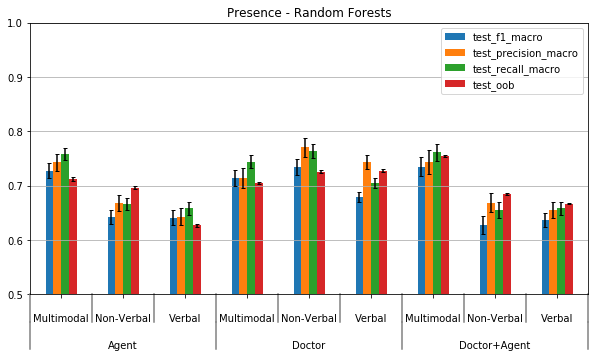

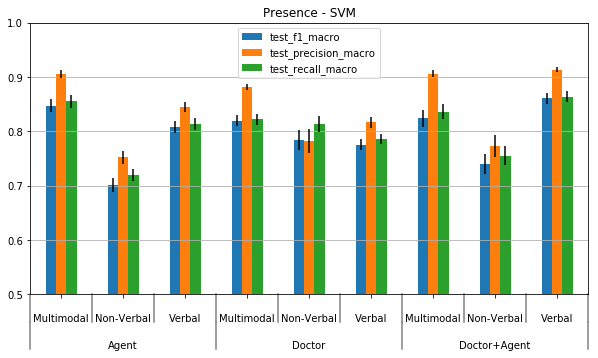

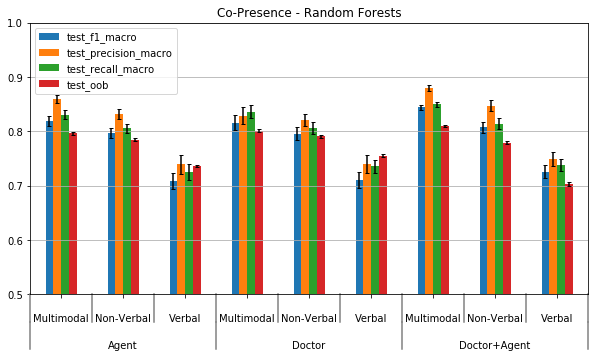

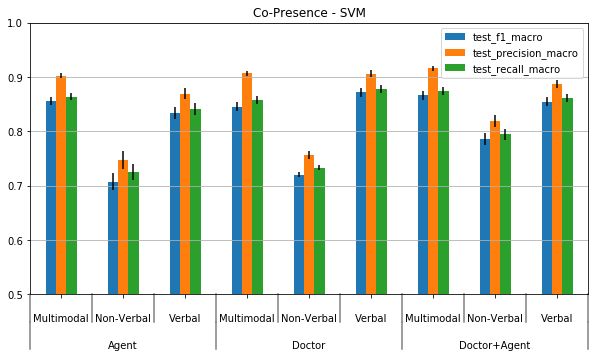

In [177]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm.png'), bbox_inches = "tight")
plt.show()


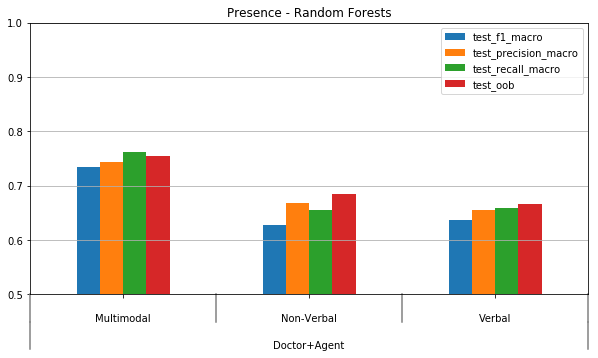

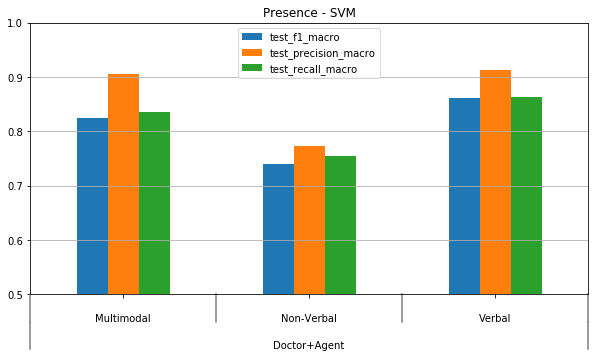

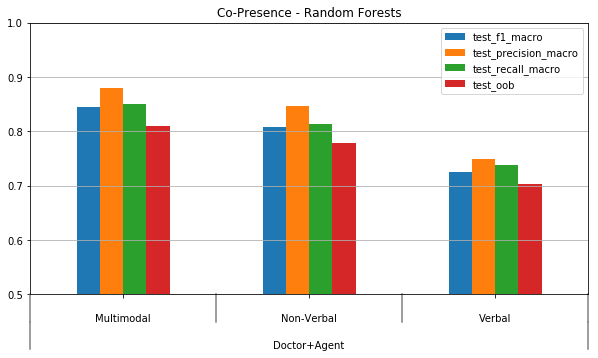

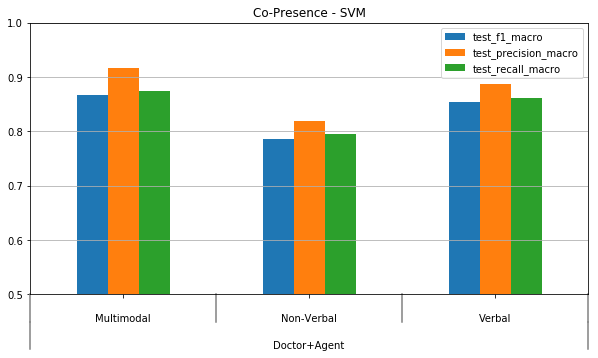

In [178]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_docagent.png'), bbox_inches = "tight")
plt.show()

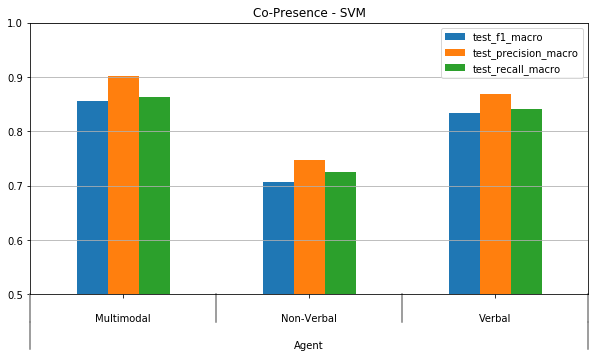

In [179]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]


# SVM - CO-presence - Agent

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Phases vs no phase

In [37]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase_imb-random', 1)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")
    
scores_df

test_f1_macro  \
Target      Subject      Phases   Classifier     Metric                  
Presence    Doctor       No Phase Random Forests score        0.527435   
                                                 err          0.139692   
                                  SVM            score        0.680211   
                                                 err          0.119242   
                         157015   Random Forests score        0.724507   
                                                 err          0.123291   
                                  SVM            score        0.714163   
                                                 err          0.127807   
            Agent        No Phase Random Forests score        0.558518   
                                                 err          0.099202   
                                  SVM            score        0.643868   
                                                 err          0.136048   
                         157015   Random Forests score        0.633419   
                                                 err          0.122877   
                                  SVM            score        0.746854   
                                                 err          0.087283   
            Doctor+Agent No Phase Random Forests score        0.611910   
                                                 err          0.117109   
                                  SVM            score        0.615946   
                                                 err          0.163411   
                         157015   Random Forests score        0.678592   
                                                 err          0.138833   
                                  SVM            score        0.738095   
                                                 err          0.136869   
Co-Presence Doctor       No Phase Random Forests score        0.620942   
                                                 err          0.116538   
                                  SVM            score        0.650386   
                                                 err          0.086620   
                         157015   Random Forests score        0.601401   
                                                 err          0.108398   
                                  SVM            score        0.742443   
                                                 err          0.100669   
            Agent        No Phase Random Forests score        0.647302   
                                                 err          0.117230   
                                  SVM            score        0.602470   
                                                 err          0.161172   
                         157015   Random Forests score        0.621981   
                                                 err          0.100024   
                                  SVM            score        0.629972   
                                                 err          0.107658   
            Doctor+Agent No Phase Random Forests score        0.708713   
                                                 err          0.113875   
                                  SVM            score        0.689882   
                                                 err          0.135071   
                         157015   Random Forests score        0.619559   
                                                 err          0.131289   
                                  SVM            score        0.678379   
                                                 err          0.090006   

                                                         test_f1_macro_class_1  \
Target      Subject      Phases   Classifier     Metric                          
Presence    Doctor       No Phase Random Forests score                0.732222   
                                                 err                  0.190591   
                            

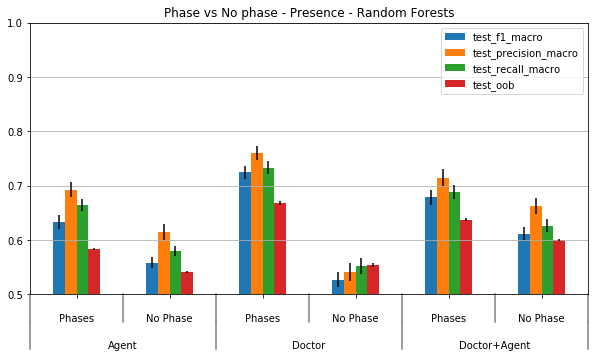

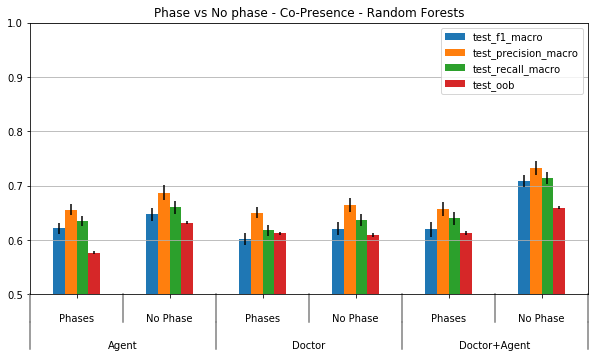

In [38]:
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence

mydf = rear.loc['score', 'Random Forests', 'Presence']
mydf.index = mydf.index.remove_unused_levels()
#mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'Random Forests', 'Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - Random Forests')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_rf.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence']
mydf.index = mydf.index.remove_unused_levels()
#mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'Random Forests', 'Co-Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - Random Forests')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_rf.png'), bbox_inches = "tight")
plt.show()

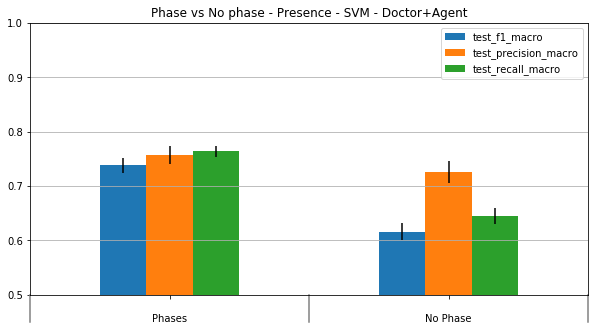

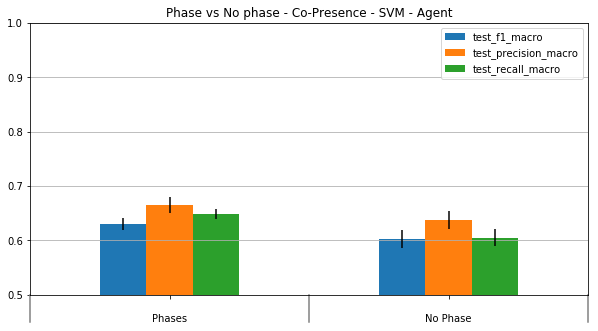

In [39]:
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence - doctor + agent

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - SVM - Doctor+Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - SVM - Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Exploring learnt classifiers
### Verbal / non-verbal


In [161]:

# reload best params found

dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")
 
context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df


Metric  \
Metric      Subject      Mode                Classifier     Metric                
Presence    Doctor       Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
            Agent        Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
...                                                                         ...   
Co-Presence Agent        Verbal              SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Non-Verbal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal+Duration Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
            Doctor+Agent Verbal              Random Forests score   Co-Presence   
                                                            err     Co-Presence   
      

In [309]:
print(str([scorer for scorer in sklearn.metrics.SCORERS.keys() if scorer.endswith('loss')]))

['neg_log_loss', 'brier_score_loss']


Test 0 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 's

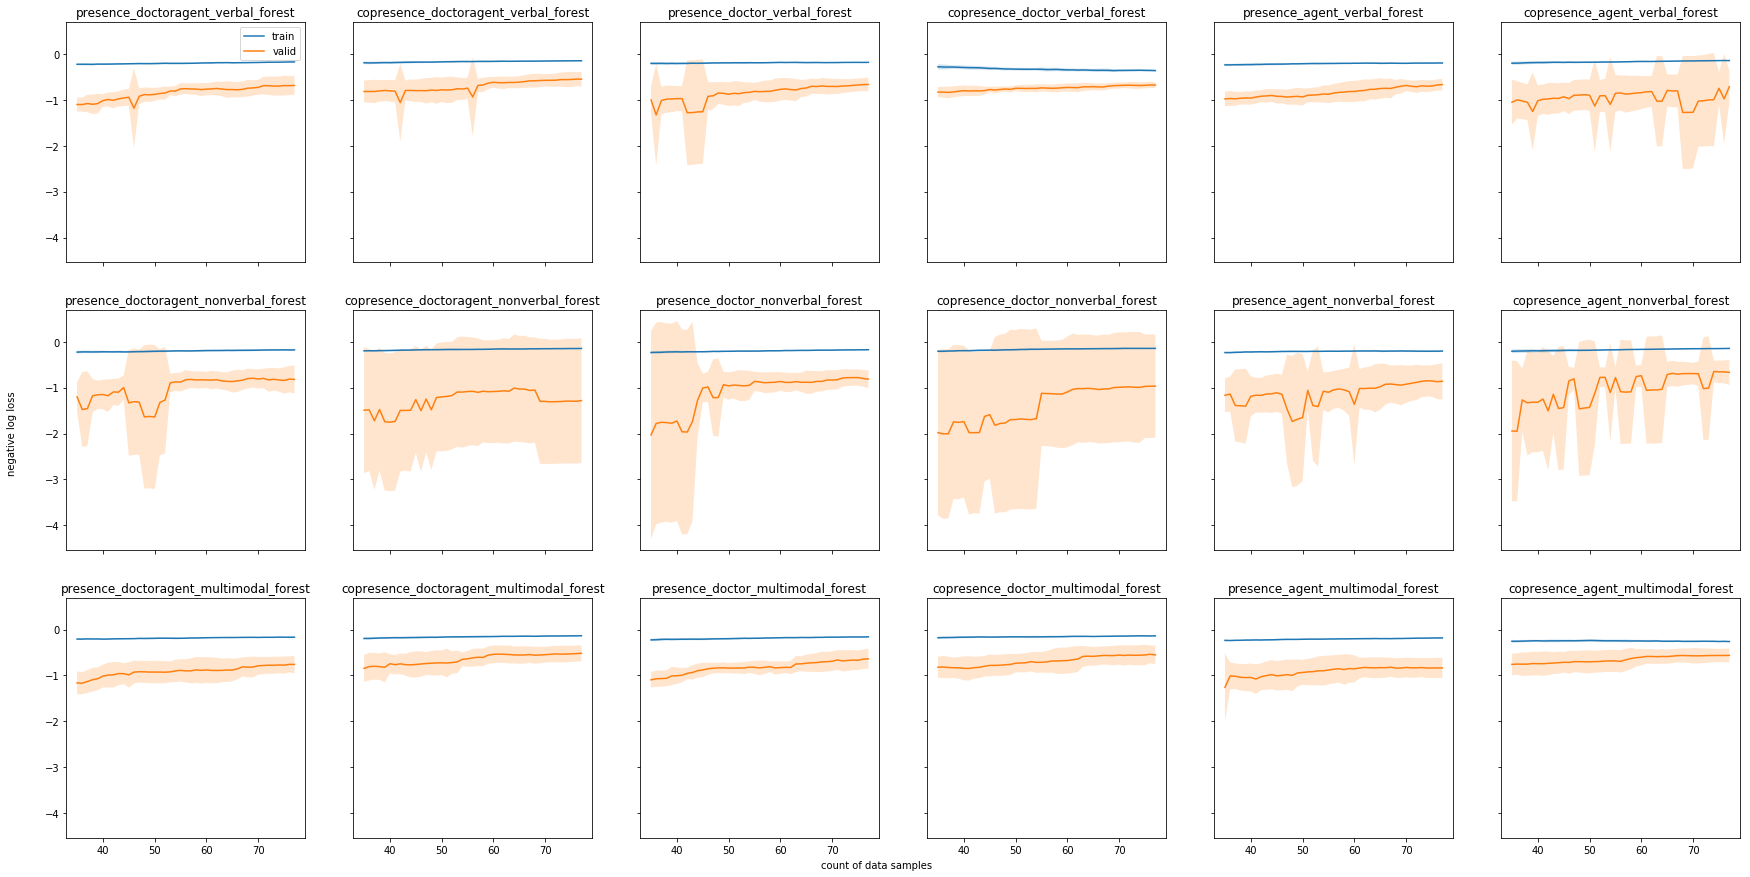

In [162]:
from sklearn.model_selection import learning_curve

test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,15))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    modes = test['modes']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm

    if subject == 'doctor':
        df = subject_np_df
        if modes == 'verbal':
            feats = subject_features_verbal
        elif modes == 'nonverbal':
            feats = subject_features_nonverbal
        elif modes == 'multimodal':
            feats = subject_features_multimodal
        elif modes == 'multimodal+duration':
            feats = subject_features_multimodal_duration
    elif subject == 'agent':
        df = agent_np_df
        if modes == 'verbal':
            feats = agent_features_verbal
        elif modes == 'nonverbal':
            feats = agent_features_nonverbal
        elif modes == 'multimodal':
            feats = agent_features_multimodal
        elif modes == 'multimodal+duration':
            feats = agent_features_multimodal_duration        
    else:
        df = all_np_df
        if modes == 'verbal':
            feats = all_features_verbal
        elif modes == 'nonverbal':
            feats = all_features_nonverbal
        elif modes == 'multimodal':
            feats = all_features_multimodal
        elif modes == 'multimodal+duration':
            feats = all_features_multimodal_duration        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    if modes == 'verbal':
        phidx = 'Verbal'
    elif modes == 'nonverbal':
        phidx = 'Non-Verbal'
    elif modes == 'multimodal':
        phidx = 'Multimodal'
    elif modes == 'multimodal+duration':
        phidx = 'Multimodal+Duration'
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, modes, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.1, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_verbal-nonverbal_forest.png') 
plt.show()

In [163]:
dh.save_obj(results, 'learning_curves', 'forest')

True

For non-verbal case we only have 2 features, we have then a chance to vizualize the classification results for some classifiers.

In [47]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA


df = subject_p_df
feats = all_features
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'Random Forests', 'score']['Best Params']
#forest.set_params(**eval(best_params))
forest = RandomForestClassifier(n_estimators=1)
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample='imb_smote', test_set=False)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
forest.fit(X_reduced,y)

model = forest
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# alpha blend the
# decision surfaces of the ensemble of classifiers

# Choose alpha blend level with respect to the number
# of estimators
# that are in use (noting that AdaBoost can use fewer estimators
# than its maximum if it achieves a good enough fit early on)
estimator_alpha = 1.0 / len(model.estimators_)
for idx, tree in enumerate(model.estimators_):
    print idx
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                        c=Z_points_coarser, cmap=cmap,
                        edgecolors="none")

# Plot the training points, these are clustered together and have a
# black outline
plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['r', 'y', 'b']),
            edgecolor='k', s=20)
plt.xlabel(feats[0])
plt.ylabel(feats[1])
plt.show()

prepare_train_data: Applying SMOTE oversampling to data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
0


MemoryError: 

In [115]:
from sklearn.decomposition import PCA

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)
    
df = all_p_df
feats = get_features_set('Doctor+Agent', '157015')
target = 'copresence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'SVM', 'score']['Best Params']
#svm.set_params(**eval(best_params))
X, y, X_test, y_test = prepare_train_data(samples=df, features=feats, target_model=target, upsample='imb_smote', test_set=True, verbose=1) 
#svm = SVC(C=0.1, gamma=1, kernel='rbf')
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}
grid = gridsearch(svm, 
                  X, y, 
                  'presence', 
                  param_grid=param_grid_svm, 
                  features=feats, 
                  verbose=verbose)
best_params = grid.best_params_
single_best_score = grid.best_score_

print('  Gridsearch evaluated best score %s' % (single_best_score))
print('    Best params %s ...' % (best_params))

prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversam

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.2s finished


  Gridsearch evaluated best score 0.6521419552669553
    Best params {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...


TRAIN 0.7291666666666666


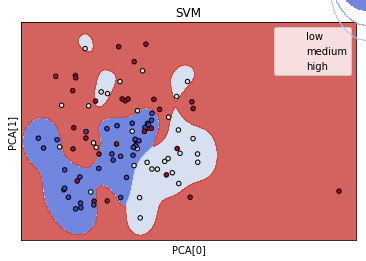

TEST 0.25
balanced accuracy 0 (0)


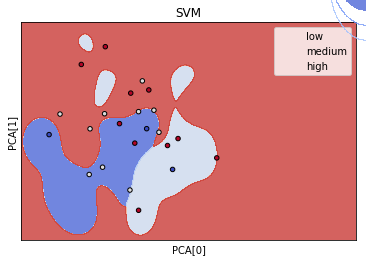

In [118]:
svm = SVC(C=0.1, gamma=1.0, kernel='rbf', random_state=RANDOM_STATE)


scaler = StandardScaler().fit(X)
X_ = scaler.transform(X)
pca = PCA(n_components=2).fit(X_)
X_reduced = pca.transform(X_)
svm.fit(X_reduced,y)
X_test_ = scaler.transform(X_test)
X_test_reduced = pca.transform(X_test_)
y_pred = svm.predict(X_test_reduced)

print('TRAIN ' + str(svm.score(X_reduced, y)))

# Set-up 2x2 grid for plotting.
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(svm, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
sct = plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PCA[0]')
plt.ylabel('PCA[1]')
plt.xticks(())
plt.yticks(())
plt.legend(['low', 'medium', 'high'])
plt.title('SVM')
plt.show()

print('TEST ' + str(svm.score(X_test_reduced, y_test)))
y_pred = svm.predict(X_test_reduced)
print('balanced accuracy %d (%d)' % (balanced_accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test,y_pred,
                                                                                                      adjusted=True)))

X2, X3 = X_test_reduced[:, 0], X_test_reduced[:, 1]
xx_, yy_ = make_meshgrid(X2, X3)
plot_contours(svm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
sct = plt.scatter(X2, X3, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PCA[0]')
plt.ylabel('PCA[1]')
plt.xticks(())
plt.yticks(())
plt.legend(['low', 'medium', 'high'])
plt.title('SVM')
plt.show()

In [65]:
print(all_p_df.columns)
all_p_df.loc[:, all_features]

Index([u'Candidate', u'Environment', u'Expert', u'Head_Entropy_Start',
       u'Head_Entropy_Mid', u'Head_Entropy_End', u'LeftWrist_Entropy_Start',
       u'LeftWrist_Entropy_Mid', u'LeftWrist_Entropy_End',
       u'RightWrist_Entropy_Start',
       ...
       u'Avg_SentenceLength_End_agent', u'Avg_IPUlen_Begin_agent',
       u'Avg_IPUlen_Middle_agent', u'Avg_IPUlen_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object', length=120)


,Expert,Head_Entropy_Start,Head_Entropy_Mid,Head_Entropy_End,Avg_HandEntropy_Begin,Avg_HandEntropy_Mid,Avg_HandEntropy_End,Avg_SentenceLength_Begin,Avg_SentenceLength_Mid,Avg_SentenceLength_End,...,Avg_HandEntropy_End_agent,Avg_SentenceLength_Begin_agent,Avg_SentenceLength_Mid_agent,Avg_SentenceLength_End_agent,Ratio1_Begin_agent,Ratio1_Mid_agent,Ratio1_End_agent,Ratio2_Begin_agent,Ratio2_Mid_agent,Ratio2_End_agent
0,0,1.770542,2.765996,2.104357,1.792061,2.856770,1.985333,9.333333,9.785714,10.750000,...,1.985333,0.000000,5.888889,2.500000,0.500000,0.173077,0.333333,0.000000,0.211538,0.166667
1,0,1.040199,2.647328,0.678702,1.014682,2.251775,0.452001,3.000000,7.181818,8.000000,...,0.452001,0.000000,7.500000,4.000000,0.000000,0.461538,0.000000,0.000000,0.076923,0.250000
2,0,1.362497,2.637082,0.769758,1.427926,2.284868,0.795238,0.000000,7.727273,14.000000,...,0.795238,1.000000,8.800000,5.000000,0.000000,0.214286,0.000000,0.000000,0.166667,0.250000
3,0,2.209341,2.992258,1.963007,1.974788,2.803599,1.146662,6.428571,8.540541,9.400000,...,1.146662,3.500000,4.388889,6.000000,0.150000,0.189189,0.000000,0.150000,0.202703,0.200000
4,0,1.961198,3.231085,1.580330,1.414102,2.529151,1.103200,4.000000,8.862069,5.800000,...,1.103200,0.000000,4.647059,12.000000,0.666667,0.328571,0.000000,0.000000,0.128571,0.250000
5,0,1.326662,2.690200,1.128224,1.323235,2.345850,1.398612,5.200000,8.250000,4.750000,...,1.398612,0.000000,6.750000,0.000000,0.000000,0.333333,NaN,0.000000,0.111111,NaN
6,0,1.661062,2.855386,1.725241,1.302170,2.360315,1.346796,11.666667,6.571429,5.666667,...,1.346796,1.000000,6.285714,8.000000,0.000000,0.315789,0.000000,0.000000,0.105263,0.250000
7,0,1.378208,3.691843,2.027476,1.502706,3.360969,1.911471,8.500000,10.294118,7.400000,...,1.911471,3.000000,2.900000,8.000000,0.500000,0.107143,0.000000,0.000000,0.178571,0.250000
8,1,1.379823,3.031654,1.986499,0.995905,2.864748,1.871523,2.875000,8.066667,6.400000,...,1.871523,1.666667,6.000000,6.000000,0.400000,0.285714,0.000000,0.000000,0.196429,0.250000
9,1,1.690235,3.447273,1.786774,1.220037,2.279745,0.904140,15.666667,9.277778,17.200000,...,0.904140,7.000000,4.000000,6.000000,0.428571,0.196429,0.285714,0.000000,0.178571,0.142857


In [22]:
from collections import Counter

samples = all_p_df.loc[:, all_features]
print('Original dataset shape %d: %s' % (len(samples), Counter(y)))
print(len(samples))
print(len(np.unique(samples, return_counts=True, axis=0)[1]))
resamples = resample(samples, n_samples=len(all_p_df)+10)
print(len(resamples))
print(len(np.unique(resamples, return_counts=True, axis=0)[1]))


from imblearn.over_sampling import RandomOverSampler

NameError: name 'y' is not defined

### phase / no phase

In [10]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Target', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")

context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df

ValueError: Length mismatch: Expected axis has 9 elements, new values have 48 elements

Test 0 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
  Computing learning curve for best

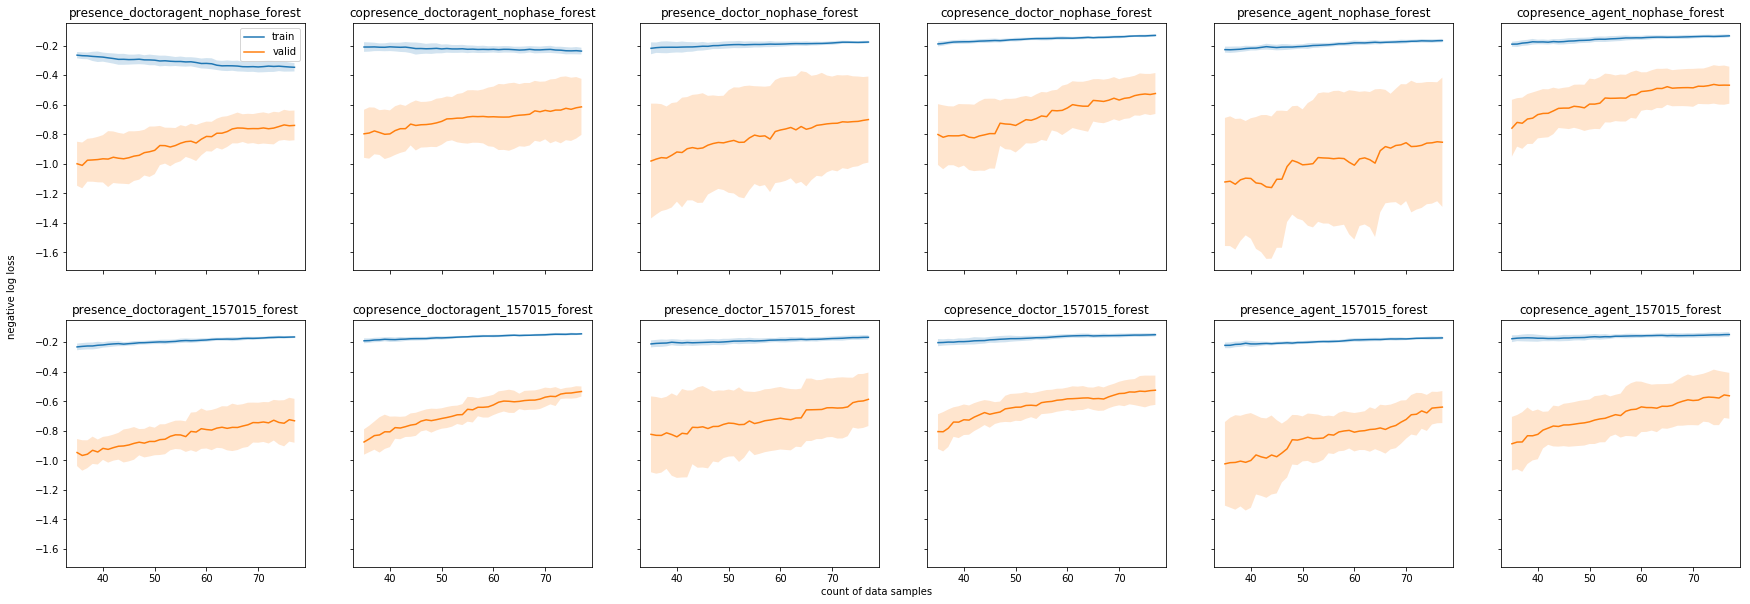

In [172]:
test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,10))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%02d%02d%02d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, phases, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.09, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_phase-nophase_forest.png') 
plt.show()

In [174]:
dh.save_obj(results, 'learning_curves', 'forest')

True

In [96]:
plt.show()

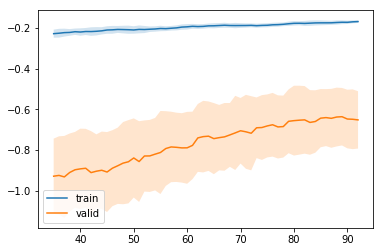

In [313]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, label='valid')
plt.fill_between(train_sizes, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [304]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(clf, X, y, "n_estimators",
                                               np.arange(1, 300, 10),
                                               cv=10)

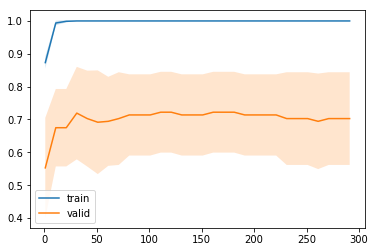

In [306]:
test_scores = valid_scores
x_range = np.arange(1,300,10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(x_range, train_scores_mean, label='train')
plt.fill_between(x_range, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(x_range, test_scores_mean, label='valid')
plt.fill_between(x_range, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('SVM Decision Region Boundary', size=6)
plt.show()

## Specific tests on 'Expert' feature

In [42]:
# specific test on expert importance

subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

subject_noexpert_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

In [43]:
grid1 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val1 = df_best_1.iloc[0]
df_best_1 = pd.DataFrame(df_best_val1.values, columns=['Doctor / Expert'], index=df_best_1.columns).T
df_best_1

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  6.1min finished


ValueError: Shape of passed values is (2, 83), indices imply (1, 83)

In [62]:
grid2 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_noexpert_features, upsample=True)
df = pd.DataFrame(grid2.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_ = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val2 = df_best_2.iloc[0]
df_best_2 = pd.DataFrame(df_best_val2.values, columns=['Doctor / No Expert'], index=df_best_2.columns).T
df_best_2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [63]:
grid3 = gridsearch(forest, agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.0min finished


ValueError: Shape of passed values is (6, 83), indices imply (1, 83)

In [64]:
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

,mean_fit_time,mean_score_time,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_train_f1_macro,mean_train_precision_macro,mean_train_recall_macro,param_class_weight,param_max_features,...,split9_train_precision_macro,split9_train_recall_macro,std_fit_time,std_score_time,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro
Agent / No Expert,0.0141,0.00369997,0.773156,0.831852,0.780952,0.997849,0.997917,0.997849,None,auto,...,1,1,0.00418211,0.00414847,0.118873,0.0914799,0.11225,0.00430219,0.00416667,0.00430108


In [65]:
df_best_all = pd.concat([df_best_1, df_best_2, df_best_3])
df_best_all[['mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro', 'params']]

,mean_test_precision_macro,mean_test_f1_macro,mean_test_recall_macro,params
Doctor / Expert,0.814921,0.746969,0.761905,"{u'max_features': None, u'n_estimators': 50, u..."
Doctor / No Expert,0.836531,0.793405,0.8,"{u'max_features': None, u'n_estimators': 100, ..."
Agent / No Expert,0.831852,0.773156,0.780952,"{u'max_features': u'auto', u'n_estimators': 10..."


In [68]:
df = pd.DataFrame(grid1.cv_results_)
cols = [col for col in df.columns if 'std' in col]
df[cols]

,std_fit_time,std_score_time,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,std_train_f1_macro,std_train_precision_macro,std_train_recall_macro
0,0.002871,0.002256,0.132134,0.165828,0.121312,0.004827,0.004678,0.004826
1,0.003661,0.001814,0.133546,0.166498,0.118634,0.003126,0.003030,0.003125
2,0.034886,0.003231,0.143855,0.179382,0.125628,0.000000,0.000000,0.000000
3,0.007099,0.004826,0.115380,0.097104,0.114120,0.000000,0.000000,0.000000
4,0.005590,0.002193,0.109027,0.079613,0.109971,0.000000,0.000000,0.000000
5,0.008237,0.003716,0.130162,0.124520,0.121187,0.000000,0.000000,0.000000
6,0.035410,0.018779,0.133596,0.128389,0.123044,0.000000,0.000000,0.000000
7,0.003807,0.003873,0.084147,0.073661,0.088363,0.004168,0.004040,0.004167
8,0.008453,0.002764,0.110407,0.116601,0.101872,0.000000,0.000000,0.000000
9,0.009600,0.004331,0.117534,0.126775,0.116220,0.000000,0.000000,0.000000


In [249]:
import numpy as np, scipy.stats as st

def confint(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

a = [1, 1.1, 0.9, 1.15, 0.8, 1.03, 0.99]
print(confint(a))

(0.8866952590268444, 1.1047333124017271)


In [40]:
rdf.index = rdf.index.swaplevel(2,3)
rdf.sort_index(inplace=True)

In [71]:
rdf

precision        f1  \
Classifier     Metric      Phases   Subject                             
Random Forests Co-Presence 157015   Agent          0.857977  0.843006   
                                    Doctor         0.843895  0.775644   
                                    Doctor+Agent   0.891758  0.857478   
                           No Phase Agent          0.916809  0.893617   
                                    Doctor         0.821652  0.798101   
                                    Doctor+Agent   0.868091  0.827934   
               Presence    157015   Agent          0.810794  0.754127   
                                    Doctor         0.778753  0.723586   
                                    Doctor+Agent   0.782381  0.747407   
                           No Phase Agent          0.763946  0.733961   
                                    Doctor         0.816032  0.776039   
                                    Doctor+Agent   0.844444  0.808904   
SVM            Co-Presence 157015   Agent          0.919678  0.882360   
                                    Doctor         0.881481  0.855305   
                                    Doctor+Agent   0.891209  0.858275   
                           No Phase Agent          0.920391  0.870184   
                                    Doctor         0.897212  0.821709   
                                    Doctor+Agent   0.890761  0.862064   
               Presence    157015   Agent          0.883039  0.793964   
                                    Doctor         0.927302  0.892880   
                                    Doctor+Agent   0.913515  0.862339   
                           No Phase Agent          0.818995  0.784713   
                                    Doctor         0.843900  0.801139   
                                    Doctor+Agent   0.898753  0.843911   

                                                    recall  \
Classifier     Metric      Phases   Subject                  
Random Forests Co-Presence 157015   Agent         0.846154   
                                    Doctor        0.794872   
                                    Doctor+Agent  0.863248   
                           No Phase Agent         0.897436   
                                    Doctor        0.803419   
                                    Doctor+Agent  0.837607   
               Presence    157015   Agent         0.771429   
                                    Doctor        0.742857   
                                    Doctor+Agent  0.752381   
                           No Phase Agent         0.742857   
                                    Doctor        0.780952   
                                    Doctor+Agent  0.819048   
SVM            Co-Presence 157015   Agent         0.888889   
                                    Doctor        0.871795   
                                    Doctor+Agent  0.871795   
                           No Phase Agent         0.880342   
                                    Doctor        0.837607   
                                    Doctor+Agent  0.880342   
               Presence    157015   Agent         0.800000   
                                    Doctor        0.895238   
                                    Doctor+Agent  0.866667   
                           No Phase Agent         0.809524   
                                    Doctor        0.809524   
                                    Doctor+Agent  0.847619   

                                                                                             params  
Classifier     Metric      Phases   Subject                                                          
Random Forests Co-Presence 157015   Agent         {'max_features': None, 'n_estimators': 40, 'cl...  
                                    Doctor        {'max_features': None, 'n_estimators': 10, 'cl...  
                                    Doctor+Agent  {'max_features': 'auto', 'n_estimators': 100, ...  
                           N

# Features importance experiments

We would like to check variance and quality of this estimator.
For this we first experiment cross validations with searching also n_estimators, or fixing it with a high value, and check if and how best parameters vary.
Then we will check for a specific set of params, how results and feature importance vary upon repeated runs.
Depending on results, we will compute feature importance for all test plan.

In [211]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def scoreForest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : scoreForest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(dataframe, target_model, features_names, upsample=True):

    scores = []

    X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(forest, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (n, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(n):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=subject_features_nophase)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=subject_features_nophase)

(array([1, 2, 3], dtype=int64), array([37, 37, 37]))
  Gridsearch evaluated best score 0.7525343525343525
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 30, 'max_depth': None, 'min_samples_leaf': 1} ...


In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def score_forest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : score_forest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(clf, param_grid, dataframe, target_model, repeat=10, upsample=True):

    scores = []

    X, y = prepare_train_data(dataframe, target_model, dataframe.columns, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(repeat):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=dataframe.columns)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=dataframe.columns)

forest = RandomForestClassifier()
run_gridsearch_with_feature_importances('rf', 
                                        param_grid, 
                                        subject_np_df[subject_features_nophase], 
                                        'presence', 
                                        upsample=True)

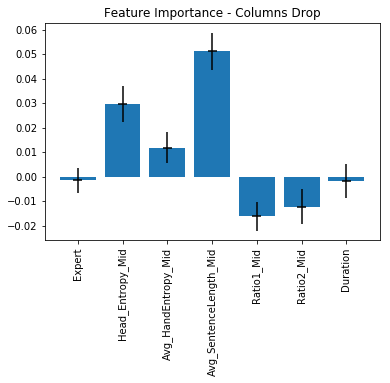

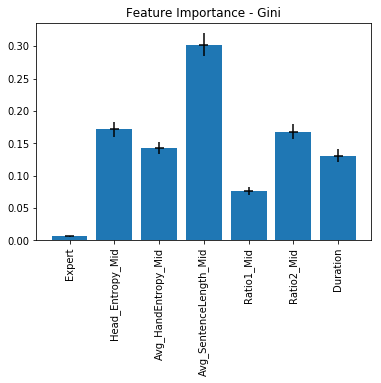

In [212]:

#print(all_scores)
all_scores_ = all_scores.drop(['fit_time', 'score_time'], axis=1).T
final = pd.DataFrame(index=all_scores_.index)

final['means'] = all_scores_.mean(axis=1)
final['std'] = all_scores_.std(axis=1)
final['sem'] = all_scores_.sem(axis=1)
final['confidence'] = all_scores_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)



final_fi = all_dropcol_features_importances.T
final_fi['means'] = final_fi.mean(axis=1)
final_fi['std'] = final_fi.std(axis=1)
final_fi['sem'] = final_fi.sem(axis=1)
final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Columns Drop', 
                final_fi['means'],
                final_fi['confidence'],
                subject_features_nophase, 
                sort=False)


final_fi_ = all_feature_importances.T
final_fi_['means'] = final_fi_.mean(axis=1)
final_fi_['std'] = final_fi_.std(axis=1)
final_fi_['sem'] = final_fi_.sem(axis=1)
final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Gini', 
                final_fi_['means'],
                final_fi_['confidence'],
                subject_features_nophase, 
                sort=False)


In [24]:
best_params = context_df[context_df['Metric.1'] == 'score']['Best Params']
print(best_params[0])
print(type(eval(best_params[0])))
print(eval(best_params[0]).keys())
unpacked = [[p[key] for p in best_params] for key in eval(best_params[0]).keys()]
df = pd.DataFrame(data=np.vstack((scores, unpacked))).T
df.columns=['score', 'max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']
print(df.sort_values(by=['score'], ascending=False))

{'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
<type 'dict'>
['max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']


TypeError: string indices must be integers, not str